# О проекте
<a id='target100'></a>

Предоставлены данные из онлайн платформы по продаже недвижимости. Это коллекция объявлений о продаже квартир в разделе "Санкт-Петербург". Задача - выяснить, какие факторы больше остальных влияют на окончательную цену, выставленную за квартиру и на какие факторы можно ориентироваться чтобы отличить настоящие объявления от мошеннических. Имеется список вопросов, на которые необходимо ответить. Также упомянуто, что в часть столбцов даты заполнены автоматически, часть - через пользовательский ввод.

## План работы:

Предобработка:
1. [анализ пропусков: пишем и запускаем несколько тематических функций](#target1) 
2. [аккуратно заполняем пропуски](#target2)
3. [изменяем тип данных в столбцах](#target3)
4. [ищем дубли в названиях населённых пунктов](#target4)
5. [анализируем выбросы](#target5)
 
Извлекаем из данных ответы на вопросы: 
1. [стоимость за квадратный метр относительно категориальных переменных и переменных с ограниченным числом значений](#target6)
2. [стоимость квадратного метра в десяти самых популярных населённых пунктах](#target7)
3. [действительно ли цена зависит от даты публикации](#target8)
4. [тенденции количественных переменных в центре города, на окраинах и в пригородных районах](#target9)

В чём состоял проект:
1. [резюме](#target10)

# Начало работы с файлом

In [9]:
from pandas import DataFrame, Series
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from collections import Counter
from IPython.display import display
%matplotlib inline
plt.rcParams['figure.facecolor'] = '#1c2423'

In [10]:
pd.read_csv('real_estate_data.csv', nrows = 3)

,total_images\tlast_price\ttotal_area\tfirst_day_exposition\trooms\tceiling_height\tfloors_total\tliving_area\tfloor\tis_apartment\tstudio\topen_plan\tkitchen_area\tbalcony\tlocality_name\tairports_nearest\tcityCenters_nearest\tparks_around3000\tparks_nearest\tponds_around3000\tponds_nearest\tdays_exposition
0,20\t13000000.0\t108.0\t2019-03-07T00:00:00\t3\...
1,7\t3350000.0\t40.4\t2018-12-04T00:00:00\t1\t\t...
2,10\t5196000.0\t56.0\t2015-08-20T00:00:00\t2\t\...


Это файл формата .tsv (tabulation separated values). Настраиваем функцию `read_csv`.

In [11]:
df = pd.read_csv('real_estate_data.csv', sep = '\t')

Лучше с самого начала оптимизировать работу с памятью. Это не такая сложная задача, чтобы откладывать на потомю


In [12]:
primary_mem_usage = df.memory_usage(deep = True).sum()
print('Currently the dataframe uses {:.2f} MB of memory'.format(primary_mem_usage / 1000000))

Currently the dataframe uses 6.54 MB of memory


У функции `pd.to_numeric` есть параметр `downcast` к которому я и обращусь. Переведу в категориальный формат строковые столбцы, если количество уникальных значений не больше 30-50% от всего объёма.

In [13]:
for column_name in df.select_dtypes(include = ['float64']).columns:
    df[column_name] = pd.to_numeric(df[column_name], errors = 'raise', downcast = 'float')
for column_name in df.select_dtypes(include = ['int64']).columns:
    if df[column_name].min() >= 0: 
        df[column_name] = pd.to_numeric(df[column_name], errors = 'raise', downcast = 'unsigned')
    else: 
        df[column_name] = pd.to_numeric(df[column_name], errors = 'raise', downcast = 'signed')
for column_name in df.select_dtypes(include = ['object']).columns:
    if len(df[column_name].unique()) / 0.3 < len(df[column_name]):
        df[column_name] = df[column_name].astype('category')

In [14]:
current_mem_usage = df.memory_usage(deep = True).sum()
print('Now dataframe takes up {:.2f} MB of storage.'.format(current_mem_usage / 1000000))
print("The space occupied by this dataframe is reduced by {:.0%} percent. Isn't that nice?".format(primary_mem_usage/current_mem_usage))

Now dataframe takes up 1.70 MB of storage.
The space occupied by this dataframe is reduced by 386% percent. Isn't that nice?


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   total_images          23699 non-null  uint8   
 1   last_price            23699 non-null  float32 
 2   total_area            23699 non-null  float32 
 3   first_day_exposition  23699 non-null  category
 4   rooms                 23699 non-null  uint8   
 5   ceiling_height        14504 non-null  float32 
 6   floors_total          23613 non-null  float32 
 7   living_area           21796 non-null  float32 
 8   floor                 23699 non-null  uint8   
 9   is_apartment          2775 non-null   category
 10  studio                23699 non-null  bool    
 11  open_plan             23699 non-null  bool    
 12  kitchen_area          21421 non-null  float32 
 13  balcony               12180 non-null  float32 
 14  locality_name         23650 non-null  category
 15  ai

- **airports_nearest** — расстояние до ближайшего аэропорта в метрах
- **balcony** — число балконов
- **ceiling_height** — высота потолков в метрах
- **cityCenters_nearest** — расстояние до центра в метрах
- **days_exposition** — как долго висело объявление (в днях)
- **first_day_exposition** — день публикации
- **floor** — этаж
- **floors_total** — этажей в доме
- **is_apartment** — аппартаменты (да или нет)ю Аппартаменты не относятся к жилому фонду, но в них созданы условия для проживания.
- **kitchen_area** — размер кухни (м²)
- **last_price** — последняя цена перед снятием с публикациим
- **living_area** — жилая площадь (м²)
- **locality_name** — название населённого пункта
- **open_plan** — свободная планировка (да или нет)
- **parks_around3000** — парков на расстоянии до 3 км
- **parks_nearest** — расстояние до ближайшего парка в метрах
- **ponds_around3000** — водоёмов на расстоянии до 3 км
- **ponds_nearest** — расстояние до ближайшего водоёма
- **rooms** — комнат в квартире
- **studio** — квартира-студия (да или нет)
- **total_area** — общая площадь (м²)
- **total_images** — фотографий, приложенных к объявлению 

Меня не полностью устраивают названия столбцов:
- цифры и заглавные буквы стоит заменить. ориентироваться будет проще, если разместить ключевые слова либо в начале, либо в конце фразы, но не посередине, и не по-разному.
- известно, что некоторые столбцы заполнены автоматически. Нам всерьёз требуется отличать эти столбцы от тех, которые заполнены пользователями лично - добавим к их названиям приставку 'auto'.
- когда часть столбцов будет начинается с буквы 'а', эту часть можно сгруппировать (сортировкой по алфавитному порядку) и сдвинуть в конец датафрейма.
- некоторые названия можно просто сократить.

In [16]:
df = df.rename(columns = {
    'total_images': 'auto_total_images',
    'cityCenters_nearest': 'auto_dist_to_centre',
    'airports_nearest': 'auto_dist_to_airport',
    'last_price': 'auto_last_price',
    'locality_name': 'auto_locality_name',
    'parks_around3000': 'auto_parks_nearby',
    'ponds_around3000': 'auto_ponds_nearby',
    'parks_nearest': 'auto_dist_to_park',
    'ponds_nearest': 'auto_dist_to_pond',
    'first_day_exposition': 'auto_first_day',
    'days_exposition': 'auto_days_posted'
    }).sort_index(axis = 1, ascending = False)

Наконец можем вызвать несколько строк и ознакомиться с данными.

In [17]:
df.iloc[:, :11].head(5)

,total_area,studio,rooms,open_plan,living_area,kitchen_area,is_apartment,floors_total,floor,ceiling_height,balcony
0,108.000000,False,3,False,51.000000,25.0,NaN,16.0,8,2.70,NaN
1,40.400002,False,1,False,18.600000,11.0,NaN,11.0,1,NaN,2.0
2,56.000000,False,2,False,34.299999,8.3,NaN,5.0,4,NaN,0.0
3,159.000000,False,3,False,NaN,NaN,NaN,14.0,9,NaN,0.0
4,100.000000,False,2,False,32.000000,41.0,NaN,14.0,13,3.03,NaN


In [18]:
df.iloc[:, 11:17].head(5)

,auto_total_images,auto_ponds_nearby,auto_parks_nearby,auto_locality_name,auto_last_price,auto_first_day
0,20,2.0,1.0,Санкт-Петербург,13000000.0,2019-03-07T00:00:00
1,7,0.0,0.0,посёлок Шушары,3350000.0,2018-12-04T00:00:00
2,10,2.0,1.0,Санкт-Петербург,5196000.0,2015-08-20T00:00:00
3,0,3.0,2.0,Санкт-Петербург,64900000.0,2015-07-24T00:00:00
4,2,1.0,2.0,Санкт-Петербург,10000000.0,2018-06-19T00:00:00


In [19]:
df.iloc[:, 17:].head(5)

,auto_dist_to_pond,auto_dist_to_park,auto_dist_to_centre,auto_dist_to_airport,auto_days_posted
0,755.0,482.0,16028.0,18863.0,NaN
1,NaN,NaN,18603.0,12817.0,81.0
2,574.0,90.0,13933.0,21741.0,558.0
3,234.0,84.0,6800.0,28098.0,424.0
4,48.0,112.0,8098.0,31856.0,121.0


Одно замечание: видим пропуски в столбце 'auto_days_posted', а значит, следующим шагом мы будем искать причину пропусков в коррелирующих столбцах. В  'auto_first_day' - в первую очередь, а в нём ерунда вместо данных. Значит, нужно отформатировать значения 'auto_first_day' сейчас, не дожидаясь пока мы дойдём до  форматирования остальных столбцов. 

Время публикации опущено: 00:00:00 вместо времени во всех строках. Значит, мы просто не включаем время.

In [20]:
df['auto_first_day'] = pd.to_datetime(df['auto_first_day'], format = '%Y-%m-%d')

# Предобработка
<a id='target1'></a>

## Пропуски

Приступим. Сколько пропусков в датафрейме?

In [21]:
print('Rows in total: ', df.shape[0], '\n' * 2, 'Number of missing values: \n', df.isna().sum(), sep = '')

Rows in total: 23699

Number of missing values: 
total_area                  0
studio                      0
rooms                       0
open_plan                   0
living_area              1903
kitchen_area             2278
is_apartment            20924
floors_total               86
floor                       0
ceiling_height           9195
balcony                 11519
auto_total_images           0
auto_ponds_nearby        5518
auto_parks_nearby        5518
auto_locality_name         49
auto_last_price             0
auto_first_day              0
auto_dist_to_pond       14589
auto_dist_to_park       15620
auto_dist_to_centre      5519
auto_dist_to_airport     5542
auto_days_posted         3181
dtype: int64


Много. И число нечасто совпадает - признак того, что они не сильно связаны друг с другом. Я хочу положить анализ пропусков в функцию, поскольку инструкция по работе с пропусками достаточно длинная, и если повторять весь цикл столько раз, сколько столбцов с пропусками, можно разлюбить аналитику. 

Функция должна разобраться со свойствами тех столбцов, в которых пропуски: в каком диапазоне значения, сколько пропусков в процентном соотношении, какие столбцы могут помощь в предсказании пропущенных значений, и не получится ли так, что у этих столбцов окажутся пропуски в тех же строчках.

In [22]:
def gaps_investigtion(df):
    """
    Принимает dataframe. Возвращает df, рассказывающих о столбцах, содержащих
    пропуски: кол-во пропусков, кол-во пропусков 
    в процентах от общего числа значений в столбце, минимальное и 
    максимальное значение в столбце, кол-во уникальных значений (если их 
    не более 3% от общего числа), два столбца с наибольшей корреляцией
    и доля пропусков в коррелирующих столбцах в тех же строчках. 
    Исключает строковые столбцы из рассмотрения. Корреляция считается
    по методам Спирмана и Пирсона.
    """
    indices = list(df.isna().sum()[ df.isna().sum() > 0 ].index)
    # names of columns which contain gaps are going to be set as indices
    for_check_up = list(df.select_dtypes(include=['object']))
    # you can never find a correlation to a string column or its' min( )/max( ). 
    # though we don't have those, i felt like emphasising it for future cases
    object_columns = []
    for x in indices.copy():
        if x in for_check_up:
            object_columns.append(x)
            indices.remove(x)
    if len(object_columns) > 0:
        print("I excluded following columns for being dtype='object':", object_columns)
    
    gaps = pd.DataFrame(index = indices, 
                        columns = ['total_gaps', 'pct_of_gaps', 'min_max', 'uniques',  
                                   'corr_max', 'gaps_resp_ly', 'runner_up', 'gaps_in_ru'])
    total_rows = df.shape[0]
    # we'll need it later

    for x in gaps.index:
        total_gaps = df[x].isna().sum()
        # we'll need it later #2

        gaps.loc[x, 'total_gaps'] = total_gaps
        gaps.loc[x, 'pct_of_gaps'] = '{:.0%}'.format(total_gaps / total_rows)

        category_columns = list(df.select_dtypes(include=['category']).columns)
         # you have to treat category columns differently to be able to apply
         # corr() to them. so i request a list of category columns
        all_other_cols = list(df.select_dtypes(exclude=['object']))
        all_other_cols.remove(x)
         # no need to compare a column to itself

        if x in category_columns:
            gaps.loc[x, 'uniques'] = df[x].cat.categories.shape[0]
        else:
            min_max = str(round(df[x].min(), 1)) + ' / ' + str(round(df[x].max(), 1))
            gaps.loc[x, 'min_max'] = min_max
            uniques = df[x].unique().shape[0]
            if uniques / total_rows < 0.03:
            # a small amount of unique values may lead us to describe the variable as categorical
                gaps.loc[x, 'uniques'] = uniques

        corrs_dict = {}
        # i've created a dictionary. Key is a correlation rate between 
        # constant 'x' column and a 'column', value is 'column''s name
        for column in all_other_cols:
            if column in category_columns and x in category_columns:                
                try:
                    corr_rate = int(df[x].cat.codes.corr(df[column].cat.codes) * 100)
                    corr_rate_sp = int(df[x].cat.codes.corr(df[column].cat.codes, method = 'spearman') * 100)
                    # i make integers [-100, 100] out of floats [-1.0, 1.0] to avoid obstacles,
                    # typical for calculations with floats. there is no way i could possibly track
                    # NaN values as soon as they are returned. either way I receive a float. since NaN's
                    # aren't equal to anything, i can't even bring a conditional expression to track them
                except ValueError: 
                    corr_rate = 0
                    corr_rate_sp = 0
                    # ValueError means that one of columns contains just one constant value that
                    # gives a standard deviation (std) of 0. instead of dividing by 0,
                    # corr( ) function returns NaN. once trying to do int(NaN) we receive ValueError 
                    # for us it is equal to having 0.0 corr rate.                   
                corrs_dict[corr_rate] = corrs_dict.get(corr_rate, '') + ' ' + column
                corrs_dict[corr_rate_sp] = corrs_dict.get(corr_rate_sp, '') + ' ' + column
            elif column in category_columns and x not in category_columns:
                try:
                    corr_rate = int(df[x].corr(df[column].cat.codes) * 100)
                    corr_rate_sp = int(df[x].corr(df[column].cat.codes, method = 'spearman') * 100)
                except ValueError:
                    corr_rate = 0
                    corr_rate_sp = 0
                except TypeError:
                    corr_rate = int(df[x].dt.date.astype('category').cat.codes.corr(df[column].cat.codes) * 100)
                    corr_rate_sp = int(df[x].dt.date.astype('category')
                                       .cat.codes.corr(df[column].cat.codes, method = 'spearman') * 100)
                    # TypeError means the columns' type is datetime. it's a typical situation
                corrs_dict[corr_rate] = corrs_dict.get(corr_rate, '') + ' ' + column
                corrs_dict[corr_rate_sp] = corrs_dict.get(corr_rate_sp, '') + ' ' + column
            elif column not in category_columns and x in category_columns:
                try:
                    corr_rate = int(df[x].cat.codes.corr(df[column]) * 100)
                    corr_rate_sp = int(df[x].cat.codes.corr(df[column], method = 'spearman') * 100)
                except ValueError:
                    corr_rate = 0
                    corr_rate_sp = 0
                except TypeError:
                    corr_rate = int(df[x].cat.codes.corr(df[column].dt.date.astype('category').cat.codes) * 100)
                    corr_rate_sp = int(df[x].cat.codes.corr(df[column].dt.date
                                                            .astype('category').cat.codes, method = 'spearman') * 100)
                corrs_dict[corr_rate] = corrs_dict.get(corr_rate, '') + ' ' + column
                corrs_dict[corr_rate_sp] = corrs_dict.get(corr_rate_sp, '') + ' ' + column
            else:
                try:
                    corr_rate = int(df[x].corr(df[column]) * 100)
                    corr_rate_sp = int(df[x].corr(df[column], method = 'spearman') * 100)
                except ValueError:
                    corr_rate = 0
                    corr_rate_sp = 0
                except TypeError:
                    if df[x].dtype == '<M8[ns]' and df[column].dtype == '<M8[ns]':
                        corr_rate = int(df[x].dt.date.astype('category').cat.codes
                                        .corr(df[column].dt.date.astype('category').cat.codes) * 100)
                        corr_rate_sp = int(df[x].dt.date.astype('category').cat.codes
                                           .corr(df[column].dt.date.astype('category').cat.codes, 
                                                 method = 'spearman') * 100)
                    elif df[x].dtype == '<M8[ns]':
                        corr_rate = int(df[x].dt.date.astype('category').cat.codes.corr(df[column]) * 100)
                        corr_rate_sp = int(df[x].dt.date.astype('category').cat.codes
                                           .corr(df[column], method = 'spearman') * 100)
                    elif df[column].dtype == '<M8[ns]':
                        corr_rate = int(df[x].corr(df[column].dt.date.astype('category').cat.codes) * 100)
                        corr_rate_sp = int(df[x].corr(df[column].dt.date.astype('category').cat.codes, 
                                                      method = 'spearman') * 100)
                corrs_dict[corr_rate] = corrs_dict.get(corr_rate, '') + ' ' + column
                corrs_dict[corr_rate_sp] = corrs_dict.get(corr_rate_sp, '') + ' ' + column
   
        max_corr = []
        max_corr_columns = []
        corrs_list = list(corrs_dict.keys())
        while len(max_corr) < 2:
            max_corr_key = max(corrs_list, key = abs)
            # we've picked up two maximal correlations and saved them in max_corr
            # now let's put'em in 'gaps' table
            corrs_list.remove(max_corr_key)
            columns_max_corr = corrs_dict[max_corr_key].split()
            # as you remember, we added ' ' to every value in dictionary to separate them. now it is time to
            # deconstuct those strings. here we make a list of column(s) with identical corr_rate (i.e. key)
            for col in columns_max_corr:
                if col not in max_corr_columns:
                    max_corr.append((max_corr_key, col))
                    max_corr_columns.append(col)
    
        if max_corr[0][0] != 0:
            gaps.loc[x, 'corr_max'] = f'{max_corr[0][0]}: {max_corr[0][1]}' 
            gaps.loc[x, 'gaps_resp_ly'] = '{:.0%}'.format(df[ df[max_corr[0][1]].isna() & 
                                                              df[x].isna() ].shape[0] / total_gaps)
            # this will tell us how many rows in two correlated columns match in having gaps
        if max_corr[1][0] != 0:
            gaps.loc[x, 'runner_up'] = f'{max_corr[1][0]}: {max_corr[1][1]}' 
            gaps.loc[x, 'gaps_in_ru'] = '{:.0%}'.format(df[ df[max_corr[1][1]].isna() & 
                                                              df[x].isna() ].shape[0] / total_gaps)
    return gaps.fillna('-')

Иногда пропуски в нескольких столбцах вызваны одной причиной - тогда они появляются в одних и тех же строчках. Такие пропуски нетрудно отследить, напишем функцию под эту задачу.

In [23]:
def gaps_duplicated(df):
    """
    Принимает dataframe. Сравнивает объединение столбцов с пропусками с пересечением
    столбцов с пропусками. Возвращает два dataframe'а, в первом обозначены пары столбцов,
    имеющиех более 40%, но менее 90% совпадающих строк с пропусками, во втором - более 90%.
    """
    matches_full = pd.DataFrame(index = df.isna().sum()[df.isna().sum() > 0].index,
                            columns = df.isna().sum()[df.isna().sum() > 0].index)
    
    matches_part = pd.DataFrame(index = df.isna().sum()[df.isna().sum() > 0].index,
                            columns = df.isna().sum()[df.isna().sum() > 0].index)
    
    for i in matches_full.columns:
        for j in matches_full.index:

            if i == j:
                continue

            match_rate = df[ df[j].isna() & df[i].isna() ].shape[0] / df[ df[j].isna() | df[i].isna() ].shape[0]
            if match_rate > 0.9:
                matches_full.loc[j, i] = '{:.2%} match'.format(match_rate)
            elif match_rate > 0.4:
                matches_part.loc[j, i] = '{:.2%} match'.format(match_rate)
                
    matches_part = (matches_part.dropna(how = 'all', axis = 0)
                                .dropna(how = 'all', axis = 1).fillna('-'))
    matches_full = (matches_full.dropna(how = 'all', axis = 0)
                                .dropna(how = 'all', axis = 1).fillna('-'))

    return matches_part, matches_full

In [24]:
part, full = gaps_duplicated(df)
part

,living_area,kitchen_area,is_apartment,balcony,auto_dist_to_pond,auto_dist_to_park
living_area,-,53.88% match,-,-,-,-
kitchen_area,53.88% match,-,-,-,-,-
is_apartment,-,-,-,51.60% match,56.98% match,60.62% match
balcony,-,-,51.60% match,-,-,-
auto_dist_to_pond,-,-,56.98% match,-,-,60.05% match
auto_dist_to_park,-,-,60.62% match,-,60.05% match,-


In [25]:
full

,auto_ponds_nearby,auto_parks_nearby,auto_dist_to_centre,auto_dist_to_airport
auto_ponds_nearby,-,100.00% match,99.98% match,99.57% match
auto_parks_nearby,100.00% match,-,99.98% match,99.57% match
auto_dist_to_centre,99.98% match,99.98% match,-,99.55% match
auto_dist_to_airport,99.57% match,99.57% match,99.55% match,-


In [26]:
gaps_investigtion(df)

,total_gaps,pct_of_gaps,min_max,uniques,corr_max,gaps_resp_ly,runner_up,gaps_in_ru
living_area,1903,8%,2.0 / 409.7,-,93: total_area,0%,91: rooms,0%
kitchen_area,2278,10%,1.3 / 112.0,-,60: total_area,0%,58: auto_last_price,0%
is_apartment,20924,88%,-,2,-24: auto_first_day,0%,7: ceiling_height,40%
floors_total,86,0%,1.0 / 60.0,37,67: floor,0%,37: kitchen_area,55%
ceiling_height,9195,39%,1.0 / 100.0,184,57: kitchen_area,15%,53: auto_last_price,0%
balcony,11519,49%,0.0 / 5.0,7,45: auto_first_day,0%,24: floors_total,0%
auto_ponds_nearby,5518,23%,0.0 / 3.0,5,-34: auto_dist_to_pond,100%,30: auto_parks_nearby,100%
auto_parks_nearby,5518,23%,0.0 / 3.0,5,30: auto_ponds_nearby,100%,-30: auto_dist_to_park,100%
auto_locality_name,49,0%,-,364,21: auto_dist_to_centre,16%,-16: auto_parks_nearby,16%
auto_dist_to_pond,14589,62%,13.0 / 1344.0,-,-34: auto_ponds_nearby,38%,-16: auto_parks_nearby,38%


Похоже, что ключевое значение в этом проекте будут иметь стобцы 'living_area', 'kitchen_area' и 'auto_dist_to_centre'. Значения на месте пропусков в первых двух стобцах можно будет, по крайней мере, предугадать - у этих столбцов есть сильные корреляции, и в коррелирующих столбцах нет пропусков. А предугадывать придётся, поскольку 10% пропусков в ключевых для анализа столбцах не хочется терять, особенно не попытавшись выяснить причины, по которым они появились - вдруг окажется, что за пропусками скрывается какая-то исключительная группа значений?!
  
  

Большой фрагмент данных (23%) - дублированные пропуски в столбцах 'auto_dist_to_airport', 'auto_dist_to_centre', 'auto_ponds_nearby' и 'auto_parks_nearby'. Кроме того,ет такого столбца, автоматически заполненного картографическимми данными, в котором было бы меньше 5518 пропусков (где больше - есть, но не меньше). А это наводит на мысль, что 5518 - это общие пропуски во всех этих столбцах (то есть одни и те же строчки), к которым могут добавляться пропуски по другие, "индивидуальные" пропуски.

Проверим, там ли это - вызовем число строк, в которых пропуски из числа тех минимальных 5518 штук сочетаются с ненулевыми значениями в других столбцах, содержащих картографическую информацию. Существуют ли такие строки?

In [27]:
(df[ df['auto_ponds_nearby'].isna() | df['auto_parks_nearby'].isna() ].loc[:, ('auto_dist_to_pond', 
                                                                              'auto_dist_to_park', 
                                                                              'auto_dist_to_airport', 
                                                                              'auto_dist_to_centre')]).notna().sum()

auto_dist_to_pond       0
auto_dist_to_park       0
auto_dist_to_airport    0
auto_dist_to_centre     0
dtype: int64

Значит, подтвердили.

Наивысшая корреляция этих столбцов - 0.4, и та - друг с другом - можно не рассчитывать на предсказание пропущенных значений. Минимальное и максимальное значения выглядят достоверно - вряд ли пропуски маскируют минимум (отсутствие) или максимум в этих столбцах. Так как пропуски появились одновременно в нескольких местах, вряд ли дело вообще дошло до рассчёта расстояний - в противном случае не было бы причины для стопроцентного совпадения в пропусках - где-то посчиталось бы корректно, а где-то нет. Это должна быть системная ошибка. И так складывается, что если не разобраться в том, какая это ошибка, то 23% данных придётся выкинуть. Попробуем найти закономерности в том, в каких строках появляются пропуски.

In [28]:
def gaps_histograms(main, *columns, datetime = '', rotation = 'horizontal'):
    """
    Использует глобальную переменную df. Первым аргументом принимает название столбца, содержащего пропуски.
    Затем список колонок, для которых будет построен рисунок. В параметре 'datetime =' можно
    через пробел передать названия datetime столбцов c пропусками (лучше заранее перевести вручную, имея 
    в виду возможные ошибки "автоматического" перевода без указания параметра 'format ='). Функция округлит
    значение datetime до даты. Рисунок будет состоять из двух наложенных друг на друга гистограмм. Одна гистограмма 
    (голубого цвета) показывает распределение 
    значений строчек, у которых нет пропусков в столбце main. Вторая (красного цвета) - тех, где есть пропуски.
    Для того чтобы привести гистограммы к одному масштабу (т.к. строк с пропусками заведомо меньше),
    гистограммы отражают процентное распределение значений (density) - до от 0% до 70%. Отображать выше 70% - 
    делало бы гистограмму менее наглядной, при том что семидесяти процентов в целом достаточно, чтобы понять,
    обнаружилась ли какая-то тенденция. Для строковых столбцов функция строит гистограмму для двадцати самых частых 
    уникальных значений, для числовых и datetime - гистограмму для интервалов (способы выделить корзины и их число
    отображаются в заголовке гистораммы). Если какое-то значение в одном срезе встречается на 8%+ чаще, чем 
    в другом, оно текстом появляется в соответствующем месте на гистограмме. Если текст не видно, его можно
    наклонить, передав параметр rotation= . Density не равна доле значений от общего числа, поэтому не нужно 
    заблужаться относительно размеров столбца на гистограмме, а стоит в первую очередь ориентироваться на текст, 
    т.к. он как раз появляется там, где нужно.
    """
    global df
    
    import matplotlib.patheffects as path_effects
    style = dict(size = 13, color = '#929591', rotation = rotation, 
                 path_effects = [path_effects.SimpleLineShadow(linewidth = 2, foreground = 'black'), 
                                 path_effects.Normal()])
    
    leng = len(columns) + len(datetime.split())
    
    nrows = [leng // 3 + 1 if leng % 3 != 0 else leng // 3][0]
    # here list comprehension calculates how many rows do we need (3 axes per row) 
    fig_height = 4 * nrows
    fig = plt.figure(figsize = (18, fig_height))
    grid = fig.add_gridspec(nrows, 3, wspace = 0.2, hspace = 0.3)
    # gridspec is a figure pattern that will help me to locate axes properly
    axes_made = 0
    for row in range(nrows):
        for col in range(3):
            if axes_made < leng:
                ax = fig.add_subplot(grid[row, col])
                # i create axes on gridspec coordinates until i've created enough
                ax.tick_params(labelbottom = False, labelleft = False, grid_alpha = 0.5)
                ax.set(ylim = (0, 0.7), ylabel = '0.0  <----  density  ---->  0.7')
                axes_made += 1
    ax = fig.axes
    # i place all the axes at the variable 'ax'. now i can acess axes via iterating over 
    # 'leng' variable, as long as their ('ax' and 'leng') lengths completely match 
    
    columns = list(columns)
    # the function provides user arguments in tuple format. before making changes
    # on it, we have to make a list out of it
    
    datetime_columns = []        
    if datetime != '':
        datetime = datetime.split()
        for dt_col in datetime:
        # if we don't convert a datetime column with NaN's from object-type to datetime,
        # we can't cut it via cut( ) or qcut( ). dropna( ) is not an option - new NaN's 
        # will instantly replace the dropped ones. i see two solutions to the problem: to fill NaN's
        # with an outlying, easily distinguished value (and to make a convertion now) or to
        # mark those columns out and to convert them as soon as we take their values out
        # of dataframe. as for me, the second solution is more consistent with plotting goals.
            df[dt_col + '_'] = df[dt_col].astype('object')
            datetime_columns.append(dt_col + '_')
            columns.append(dt_col + '_')
    
    category_columns = df.select_dtypes(include=['category']).columns
    for cat_col in category_columns:
        if cat_col in columns:
            df[cat_col + '_'] = df[cat_col].astype('object')
            # i am creating new object-type columns out of category ones,  
            # otherwise i won't be able to plot them the way i want. and i remove
            # category columns from the list of columns to be plotted
            columns.remove(cat_col)
            columns.append(cat_col + '_')
            
    def customizing_numeric_intervals(interval):
        interval = str(interval)
        left, right = interval.split()
        left_integer, left_decimals = left.split('.')
        left_integer = left_integer
        left_decimals = left_decimals[0]
        right_integer, right_decimals = right.split('.')
        right_decimals = right_decimals[0]
        return ''.join([left_integer, '.', left_decimals, '-', right_integer, '.', right_decimals + ']'])
    def customizing_datetime_intervals(interval):
        interval = str(interval)
        left, right = interval.split(', ')
        if len(left.split(' ')) == 2:
            left_date, left_time = left.split(' ')
            left_date = left_date[1:]
        else:
            left_date = left
        if len(right.split(' ')) == 2:
            right_date, right_time = right.split(' ')
        else:
            right_date = right
        return ''.join([left_date, ' / ', right_date])   
    
    for i in range(leng):
        
        if columns[i] in datetime_columns:
            is_datetime = True
        else:
            is_datetime = False
    
        if (df[columns[i]].dtype != 'O' or df[columns[i]].dtype != 'object') or is_datetime == True:
            
            if is_datetime == False:
                if (pd.cut(df[columns[i]], 20, duplicates = 'drop')
                    .value_counts(normalize = True)
                    .iloc[:4].sum() > 0.8):
                    # if after cut( ) operation first four elements accumulate more
                    # than 80% of values, a histogram won't be much illustrative. 
                    # in this case dividing by quantiles is more preferable.                
                    df[f'{columns[i]}_'] = pd.qcut(df[columns[i]], 10, duplicates = 'drop')
                    title = 'qcut'
                    # if the division by 20 quantiles is steady, an average occurence rate
                    # of a category will be 5%. a histogram won't be  
                    # very much illustrative as well. so let's divide by 10 quantiles.   
                else:
                    df[f'{columns[i]}_'] = pd.cut(df[columns[i]], 20, duplicates = 'drop')
                    title = 'cut'
            elif is_datetime == True:
                title = 'qcut'
                df[f'{columns[i]}_'] = pd.qcut(pd.to_datetime(df[ df[columns[i]].notna() ][columns[i]]), 
                                               10, duplicates = 'drop')
                        
            missing = df[ df[main].isna()][f'{columns[i]}_'].cat.codes
            normal = df[ df[main].notna()][f'{columns[i]}_'].cat.codes           
            # after cut( ) and qcut( ) we have to deal with a category column. 
            # it is impossible to plot intervals, though we can plot integers that 
            # substitute them in memory. 
            
            # both (q)cut( ) and hist( ) ignore NaN's in a slice and do their job as they
            # sould, but as far as i want to set labels that indicate how many rows are covered by
            # a histogram, i have to substract missing values from slice manually.
            # i need to mark them as a category, other than 'out_of_any_category_but_still_not_a_gap', 
            # as they are in default in category-type columns. or i can request the count - that sounds easier.
            # when NaN's are converted to category-type, they are stored under number -1. 
            try: 
                gaps_in_missing = missing.value_counts().loc[-1]
            except KeyError:
                gaps_in_missing = 0
            try:
                gaps_in_normal = normal.value_counts().loc[-1]
                bins = df[f'{columns[i]}_'].unique().shape[0] - 1
                # if cut( ) or qcut( ) have had a parameter bins = 15 and slice has 
                # contained NaNs, resulting column now has 16 unique values, one of which 
                # won't be plotted. if so, the number of bins that i should pass is 15, not 16. 
            except KeyError:
                gaps_in_normal = 0
                bins = df[f'{columns[i]}_'].unique().shape[0]
            
            title = title + f'({bins}): {columns[i]}'
            label_for_miss = f'{missing.shape[0] - gaps_in_missing} rows'
            label_for_norm = f'{normal.shape[0] - gaps_in_normal} rows'
            
            ax[i].hist(normal, histtype = 'bar', bins = bins, density = True, 
                    color = '#01ecb1', alpha = 0.8, label = label_for_norm)
            ax[i].hist(missing, histtype = 'bar', bins = bins, density = True, 
                    color = '#ec2d01', alpha = 0.7, label = label_for_miss)
            ax[i].legend()
            ax[i].set(title = title)
            
            misses_for_inscr = df[ df[main].isna() ][f'{columns[i]}_'].value_counts(normalize = True)
                # this block of code is dedicated to making inscriptions on places where two histograms dispart
            normals_for_inscr = df[ df[main].notna() ][f'{columns[i]}_'].value_counts(normalize = True)
            for_inscr = pd.concat([normals_for_inscr, misses_for_inscr], axis = 1)
                # 'for_inscr' is a dataframe that keeps the occurance rate of every 
                # value in two different slices. slices are identical to those that provide 
                # a base for histograms: one slice - rows with gaps, another - rows without gaps.
            for_inscr['difference'] = abs(for_inscr.iloc[:, 0].sub(for_inscr.iloc[:, 1]))
                # adding modular subtraction of occurence rates in two slices.
                # the resulting number doesn't refer to anything real, but it reflects
                # the very difference in bars 
            for_inscr = (for_inscr[ for_inscr['difference'] > 0.08 ]
                         .sort_values(by = 'difference', ascending = False).head(3))
                # here i'm releasing all values except those three of them that differ the most. 
                # since there is no need in making an indcation when the difference 
                # is still too low, i've decided to set 10% (0.1) threshold
            for_inscr['maximal'] = for_inscr.iloc[:, :2].max(axis = 1)
                # maximal occurance rate will be a coordinate on Y-axis where to place. 
                # an inscription. still it's not a density, but something proportional
            for_inscr['maximal'] = for_inscr['maximal'].where(for_inscr['maximal'] < 0.65, 0.65)
                # y-axis is constrained by 0.7, while occurence rate is not.
                # suppose, we don't want to place an inscription above the drawin
            for_inscr = for_inscr.drop(f'{columns[i]}_', axis = 1)
            for_inscr = for_inscr.reset_index()
                # after .reset_index( ) we got a new column accessible via .iloc[:, 0]
            for_inscr['codes'] = for_inscr.iloc[:, 0].cat.codes
            if is_datetime:
                for_inscr['inscription'] = for_inscr.iloc[:, 0].apply(customizing_datetime_intervals)
            else:
                for_inscr['inscription'] = for_inscr.iloc[:, 0].apply(customizing_numeric_intervals)
                

            if for_inscr.shape[0] > 0:
                for y in range(for_inscr.shape[0]):
                    ax[i].text(for_inscr.loc[y, 'codes'], 
                               for_inscr.loc[y, 'maximal'],
                               "{}: {:.0f}prc".format(for_inscr.loc[y, 'inscription'], (for_inscr.loc[y, 'difference'] * 100)),
                               **style)
            
        else:
            top = df.groupby(columns[i])[columns[i]].count().sort_values(ascending = False).index[:20]
            missing = df[ df[main].isna() & df[columns[i]].notna() ].query(f'{columns[i]} in @top')[columns[i]]
            normal = df[ df[main].notna() & df[columns[i]].notna() ].query(f'{columns[i]} in @top')[columns[i]]
            if len(top) < 20:
                # we've finished using 'top' variable to make slices.
                # now we can use it to store the number of bins
                top = len(top)
            else:
                top = 20
            label_for_miss = f'{missing.shape[0]} rows'
            label_for_norm = f'{normal.shape[0]} rows'
            title = f'top({top}): {columns[i]}'
            ax[i].hist(normal, histtype = 'bar', bins = top, density = True, 
                    color = '#01ecb1', alpha = 0.8, label = label_for_norm)
            ax[i].hist(missing, histtype = 'bar', bins = top, density = True, 
                    color = '#ec2d01', alpha = 0.7, label = label_for_miss)
            ax[i].legend()
            ax[i].set(title = title)
            
        
            misses_for_inscr = df[ df[main].isna() ][f'{columns[i]}'].value_counts(normalize = True)
            normals_for_inscr = df[ df[main].notna() ][f'{columns[i]}'].value_counts(normalize = True)
            for_inscr = pd.concat([normals_for_inscr, misses_for_inscr], axis = 1).fillna(0)
                # after concateration we will compare values that are present in both
                # slices, others will return NaN. i replace them with 0 to calculate the difference
            for_inscr['difference'] = abs(for_inscr.iloc[:, 0].sub(for_inscr.iloc[:, 1]))
            for_inscr = (for_inscr[ for_inscr['difference'] > 0.08 ]
                         .sort_values(by = 'difference', ascending = False).head(3))
            for_inscr['maximal'] = for_inscr.iloc[:, :2].max(axis = 1) 
            for_inscr['maximal'] = for_inscr['maximal'].where(for_inscr['maximal'] < 0.60, 0.60) 
            for_inscr = for_inscr.reset_index()

            if for_inscr.shape[0] > 0:
                for y in range(for_inscr.shape[0]):
                    ax[i].text(for_inscr.loc[y, 'index'], 
                               for_inscr.loc[y, 'maximal'], 
                               "{}: {:.0f}prc".format(for_inscr.loc[y, 'index'], (for_inscr.loc[y, 'difference'] * 100)),
                               **style)
    display(fig)
    plt.close(fig)
            
    for x in df.columns:
        symbols = list(x)
        if symbols[-1] == '_':
            df = df.drop(x, axis = 1)
            # i'm dropping auxiliary columns with suffix '_' at the end of their names

Скормим функции несколько столбцов: исследуем их отношение к любому столбцу, содержащему те самые 23% пропусков. Пусть это будет 'auto_dist_to_centre'.

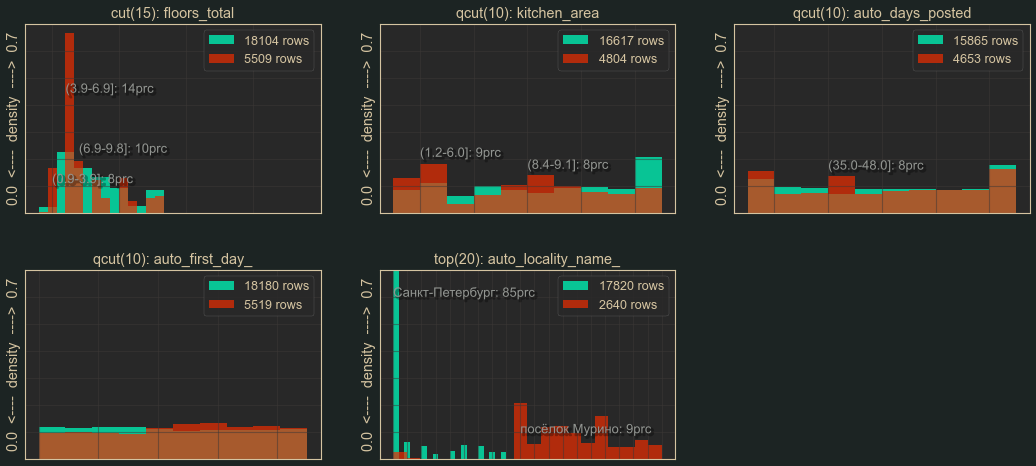

In [29]:
gaps_histograms('auto_dist_to_centre', 'auto_locality_name', 
                'floors_total', 'kitchen_area', 'auto_days_posted', datetime = 'auto_first_day')

Вот и разгадка наметилась. Обратим внимание на гистограмму для столбца 'auto_locality_name': публикации, относящиеся к целой группе населённых пунктов (возглавляемой Мурино), повально содержат пропуски в столбцах с картографическими данными. Для квартир из других населённых пунктов расстояния, напротив, подсчитываются без проблем (исключая небольшое число объявлений из Санкт-Петербурга).

Расстояние между Мурино и центром города, бесспорно,  исчисляется в веках, а не в километрах, но компьютер этого знать не должен. 

Гистограмма - хорошо, но для проверки получим срез, в котором для объявлений из Мурино и Всеволожска будет рассчитано какое-нибудь расстояние.

In [30]:
df[ ((df['auto_locality_name'] == 'посёлок Мурино') | 
     (df['auto_locality_name'] == 'Всеволожск')) & 
      df['auto_dist_to_airport'].notna() ].shape[0]

0

Неудивительно, что в этих объявлениях с пропусками большая доля малоэтажных зданий по сравнению с объявлениями без пропусков. В пригородах высотные здания встречаются реже. 

Теперь можно определиться с отношением к этим пропускам: можно смириться с ними всеми, кроме тех, что в столбце 'auto_dist_to_centre'. Нам нужны значения этого столбца в принципе, и в особенности пропущенные значения, если они относятся к пригородам, т.к. данные по пригородам нам будет нужно исследовать отдельно. 
  
Давайте составим топ-20 популярных населённых пунктов среди тех, для которых не подсчитывается расстояние до центра. Узнаем, какую долю занимают объявления из этих населённых пунктов от общего числа объявлений с рассматриваемыми пропусками.

In [31]:
df[ df['auto_dist_to_centre'].isna() ]['auto_locality_name'].value_counts().iloc[:20].sum()

3346

In [32]:
_ / df['auto_dist_to_centre'].isna().sum()

0.6062692516760283

Получается, что если мы вручную заполним расстояние до центра всего лишь для этих двадцати населённых пунктов, то избавимся от шестидесяти процентов пропусков. Думаю, что нам это будет по силам.

Отложим заполнение на потом. Что делать с остальными пропусками?

Пусть мы разобрались с ~5000 пропущенных значений в столбцах с расстояниями. Среди этих столбцов есть два таких, где сверх того - ещё 10.000 пропусков: 'dist_to_park 'и 'dist_to_pond'.

Примечательно, что максимальные значения в этих столбцах подозрительно малы: 3 км и 1.5 км. Есть выписка из документации, где сказано, что лимит в 3км существует на самом деле, однако об этом лимите упомянуто в связи с другими столбцами: 'auto_ponds_nearby' и  'auto_parks_nearby'.

Либо в пределах трёх километрах есть парк (пруд), и информация о нём отображается в двух столбцах одновременно, либо же в 'ponds_nearby' - ноль, а в 'dist_to_pond' - пропуск. Давайте проверим - сделаем срез значений в 'auto_parks_nearby' в тех строчках, где стоят пропуски в 'auto_dist_to_park'.

In [33]:
print(df[ df.auto_dist_to_park.isna() & df.auto_parks_nearby.notna() ]['auto_parks_nearby'].value_counts())
print(df[ df.auto_dist_to_pond.isna() & df.auto_ponds_nearby.notna() ]['auto_ponds_nearby'].value_counts())

0.0    10102
Name: auto_parks_nearby, dtype: int64
0.0    9071
Name: auto_ponds_nearby, dtype: int64


В самом деле, везде нули. А бывают такие ненулевые значения в 'auto_dist_to_park', чтобы в 'auto_parks_nearby' всё-таки стоял ноль?

In [34]:
print(df[ df.auto_dist_to_park.notna() & df.auto_parks_nearby.notna() ]['auto_parks_nearby'].value_counts())
print(df[ df.auto_dist_to_pond.notna() & df.auto_ponds_nearby.notna() ]['auto_ponds_nearby'].value_counts())

1.0    5681
2.0    1747
3.0     647
0.0       4
Name: auto_parks_nearby, dtype: int64
1.0    5717
2.0    1892
3.0    1501
Name: auto_ponds_nearby, dtype: int64


Всего 4 штуки, и, судя по всему, они как раз и превышают на 190 метров отметку в 3км (мы видели по таблице 'gaps_investigation', что максимальное значение в 'auto_dist_to_park', если быть точным, не 3км, а 3.19км) 

В итоге получается, что информация в двух столбцах о парках и двух столбцах о водоёмах дополняет друг друга. Так ли это задумывалось? Либо столбец с расстоянием служит для уточнения данных, наподобие: "2 парка рядом, до ближайшего 300 метров), либо для большего охвата: "парков рядом нет, но до ближайшего всего 4км". Скорее всего, речь о первом варианте, а ноль вместо пропусков не стоит потому, что означал бы "0 метров до парка". В любом случае, пропуски означают, что рядом нет ни парка, ни водоема. Поскольку мы выяснили значение пропусков, их нужно заполнить не так, как мы заполним неизвестные значения из числа, к примеру, предыдущих 5500. Одни мы заполним значением переменной `unknown`, а другие - переменной `zero`. 

Что можно сказать о столбце 'is_apartment'?

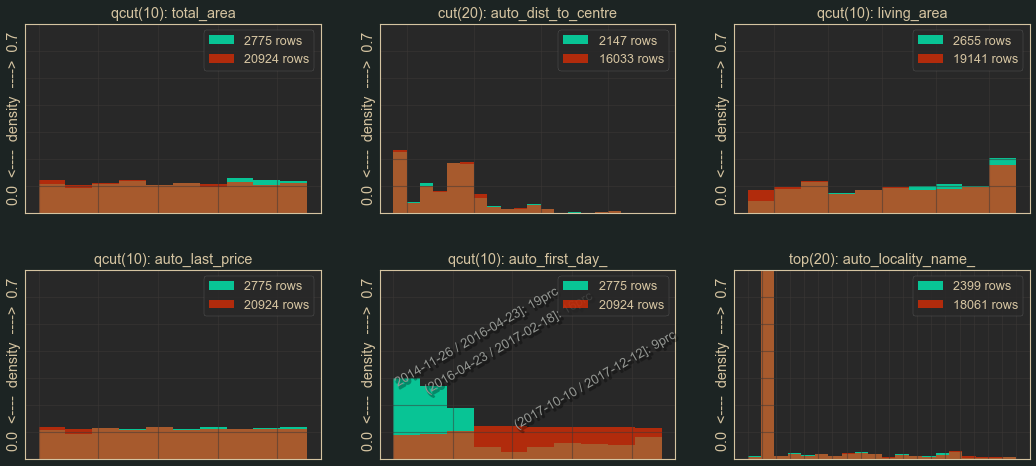

In [35]:
gaps_histograms('is_apartment', 'auto_locality_name', 'total_area',
                'auto_dist_to_centre', 'living_area', 'auto_last_price', 
                datetime = 'auto_first_day', rotation = 30)

Всё что удалось найти - что большая часть ненулевых значений попала в базу данных до 2017 года. На самом деле, на рынке где-то до 2017 года было больше апартаментов. Значит ли это, что пропуски стоят вместо значений False? Судя по всему, большинство людей считают необзятельным заполнять то поле, в котором ответом не является "да". Но тогда их количество должно быть обратно пропорционально количеству ненулевых значениям, а гистограмма этого не показывает. Если это так, то значений False в столбце должно быть меньше, чем на самом деле (чем можно было бы ожидать) - ведь некоторую часть от ответов "нет" на себя перетянули, согласно гипотезе, пропуски.

In [36]:
df['is_apartment'].value_counts(normalize = True, dropna = True)

False    0.981982
True     0.018018
Name: is_apartment, dtype: float64

А получается наоборот, всего два значения из ста - "да, апартаменты". Здесь данные становятся совсем подозрительные. Согласно spb.cian.ru, сейчас (когда я пишу проект) 53 из 658 объявлений, то есть ~8% - это продажа апартаментов, а до 2017 года, насколько удалось узнать, доля апартаментов на рынке никак не была ниже, если не значительно выше. Подводя итог, ни с 88% пропусков в столбце 'is_apartment', ни с оставшимися 12% ненулевых значений разобраться не удалось. Для проекта этот столбец не имееет большого значения, поэтому я бы предпочёл просто его удалить.

Можно было бы оттолкнуться от того, что 'is_apartment' с тремя (!) столбцами имеет более ~50% совпадающих строк, но дело, очевидно, в том, что 88% пропусков в 'is_apartment' - это почти все строки датасета, и с любым столбцом, где пропущенных значений достаточно много, у 'is_apartment' в большом количестве будут совпадающие строки.

Что можно сказать о пропусках в 'kitchen_area'?

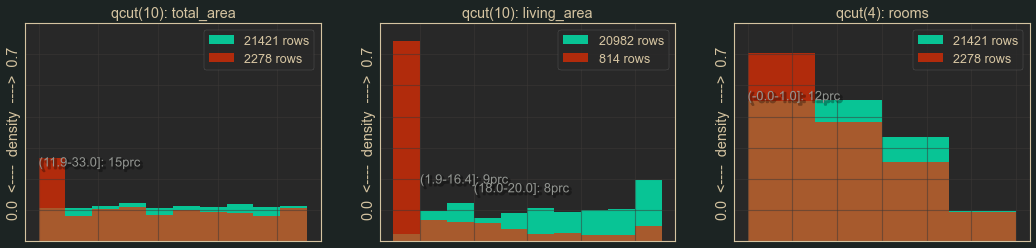

In [37]:
gaps_histograms('kitchen_area', 'total_area', 'living_area', 'rooms')

Чем меньше жилая, общая площади и число комнат, тем больше верятность пропуска в 'kitchen_area' Есть идея: меньше всего комнат и площади в квартирах-студиях и так называемых квартирах со свободной планировкой. Какая доля из них имеет пропуски вместо размера кухни?

In [38]:
df[ df['open_plan'] == True ]['kitchen_area'].value_counts(normalize = True, dropna = False)

NaN    1.0
Name: kitchen_area, dtype: float64

In [39]:
df[ df['studio'] == True ]['kitchen_area'].value_counts(normalize = True, dropna = False)

NaN    1.0
Name: kitchen_area, dtype: float64

Сто процентов! Исчерпываются ли пропуски в 'kitchen_area' квартирами-студиями и квартирами со свободной планировкой?

In [40]:
print(df[ (df['studio'] == True) & (df['open_plan'] == True) ].shape[0])
print(df[ (df['studio'] == True) | (df['open_plan'] == True) ].shape[0])
print(df[ (df['studio'] != True) & (df['open_plan'] != True) & df['kitchen_area'].isna() ].shape[0])

0
216
2062


--Они составляют лишь одну десятую от всех пропусков. По крайней мере, эту одну десятую нужно заполнить значением `zero` - кухня в таких квартирах включена в площадь 'living_area'. Что до остальных пропусков, ничего не указывает, что на их месте должен стоять ноль. 

К столбцу 'auto_days_posted'.

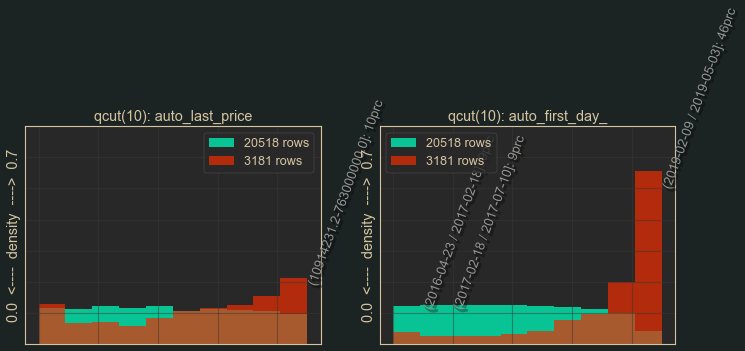

In [41]:
gaps_histograms('auto_days_posted', 'auto_last_price', datetime = 'auto_first_day', rotation = 70)

Пропусков в столбце, означающем количество дней, которое объявление висело на сайте, резко больше среди  объявлений, загруженных недавно: до трёх месяцев давности - наибольший пик. Среди объявлений, размещённых давно, такой процент ниже, однако он снова поднимается для объявлений, размещённых слишком давно. Картина такая - пропуски стоят, если объявление до сих пор не закрыто. Об этом говорит и то, что проусков в 'auto_days_posted' на 10% больше среднего среди объявлений с наивысшей ценой.

В столбце 'balcony' целых 50% пропусков. Наибольшая корреляция - 45% с 'auto_first_day'. Непонятно. Построим гистограмму и вызовем `value_counts` для 'balcony'.

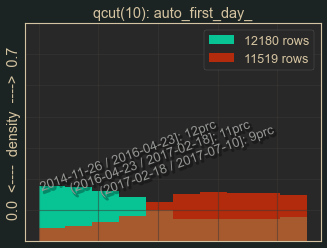

0.0     3758
1.0     4195
2.0     3659
3.0       81
4.0      183
5.0      304
NaN    11519
Name: balcony, dtype: int64

In [42]:
gaps_histograms('balcony', datetime = 'auto_first_day', rotation = 20)
df['balcony'].value_counts(dropna = False).sort_index()

Непонятно по-прежнему, хотя сейчас мы убедились в том, что корреляция 'auto_first_day' с 'balcony' затрагивает в том числе пропущенные значения. Нам в этом отношении больше даёт `value_counts`: в самом деле, трудно поверить, что квартир с двумя балконами столько же, сколько квартир без балкона. Если присоединить пропуски к нулевым значениям, то как раз получится такое распределение, в которое можно поверить. Заполнять пропуски нулём самоуверенно и неоправданно. Можно заполнить значением zero и не сильно полагаться на эти данные, если их всё-же придётся где-то задейстовать

Гистограммы для 'ceiling_height' и 'floors_total' я не привожу, потому что в них нет ничего примечательного. С другой стороны, отсутствие закономерностей и корреляций (случайное распределениепропусков) - тоже знак. И это зелный свет для предсказания пропущенных значений - мы не исказим реальную картину по другим столбцам, если возьмёмся заполнить пропуски самостоятельно.

Соберём вместе наши планы на столбцы с пропущенными значениями:

- **living_area**: предугададать с помощью коррелирующих столбцов
- **kitchen_area**: там где `studio == True` или `open_plan == True` заполнить значением `zero`, остальное предугададать с помощью коррелирующих столбцов
- **is_apartment**: удалить столбец     
- **floor**: поискать наиболее надёжный критерий для того, чтобы предугадать пропущенные значения
- **ceiling_height**: поискать наиболее надёжный критерий для того, чтобы предугадать пропущенные значения
- **balcony**: заполнить значением `zero`
- **auto_ponds_nearby**: заполнить значением `unknown`
- **auto_parks_nearby**: заполнить значением `unknown`
- **auto_dist_to_centre**: часть данных ввести вручную, остальные пропуски заполнить значением `unknown`
- **auto_dist_to_pond**: заполнить 10.000 пропусков значением `zero`, остальные заполнить значением `unknown`   
- **auto_dist_to_park**: заполнить 10.000 пропусков значением `zero`, остальные заполнить значением `unknown`
- **auto_locality_name**: заполнить значением `unknown`
- **auto_dist_to_airport**: заполнить значением `unknown`
- **auto_days_posted**: заполнить значением `zero`
<a id='target2'></a>

 ## Заполнение пропусков

In [43]:
zero = -909090
unknown = -777777

У столбца 'living_area' две >0.9 корреляции: с 'total_area' и с 'rooms'.

Ни `cut()`, ни `qcut()` не смогут разделить столбец 'rooms' так, чтобы одновременно для каждой категории хватало наблюдений, и при этом было достаточно разнообразия, чтобы на основании столбца предсказывать значения в 'living_area'. Поэтому передадим желаемые интервалы сами. Столбец 'total_area' разделим с помощью `qcut()`, сохраним медианные значения для категорий и напишем функцию, которая будет извлекать ожидаемые медианные значения и возвращать их среднее в том случае, если прогноз по 'rooms' и прогноз по 'living_area' будет отличаться не больше, чем на 15м$^2$. 

In [44]:
df['rooms'] = pd.cut(df['rooms'], [-0.1, 0.9, 1.9, 2.9, 3.9, 4.9, 5.9, 7.9, 20],
                 labels = ['0 rooms', '1 room', '2 rooms', '3 rooms',  
                           '4 rooms', '5 rooms', '6-7 rooms', '8+ rooms'],
                 ordered = True)

df['total_area_qcut_15'] = pd.qcut(df['total_area'], 15)

In [45]:
mapping_table_for_total_area = df.groupby('total_area_qcut_15')['living_area'].agg('median')
mapping_table_for_rooms = df.groupby('rooms')['living_area'].agg('median')

In [46]:
inserted_mean_values = 0
inserted_unknowns = 0

def for_living_area(row, mapping_table_for_total_area, mapping_table_for_rooms):
    
    global inserted_mean_values
    global inserted_unknowns
    unknown = -777777
    
    f_expected_value = mapping_table_for_total_area.loc[row['total_area_qcut_15']]
    s_expected_value = mapping_table_for_rooms.loc[row['rooms']]
    
    if abs(f_expected_value - s_expected_value) < 15:
        inserted_mean_values += 1
        return (f_expected_value + s_expected_value) / 2
    else:
        inserted_unknowns += 1
        return unknown

In [47]:
df.loc[ df['living_area'].isna(), ['living_area'] ] = (df[ df['living_area'].isna() ]
                                                 .apply(for_living_area, axis = 1,
                                                  args = (mapping_table_for_total_area, mapping_table_for_rooms,)))
print(inserted_mean_values, 'mean values have been inserted')
print(inserted_unknowns, "'unknowns' have been inserted")
print("Current number of gaps in 'living area' column:", df['living_area'].isna().sum())

1629 mean values have been inserted
274 'unknowns' have been inserted
Current number of gaps in 'living area' column: 0


Now we move to 'kitchen_area' column and fill with 'zero' value such rows where `studio == True or open_plan == True` 

In [48]:
df.loc[ ((df['studio'] == True) | 
     (df['open_plan'] == True)) &
     (df['kitchen_area'].isna()), 'kitchen_area'] = df.loc[ ((df['studio'] == True) | 
                                                    (df['open_plan'] == True)) & 
                                                    (df['kitchen_area'].isna()), 'kitchen_area' ].fillna(zero)

Now we repeat previous steps one more time.

In [49]:
df['living_area_qcut_15'] = pd.qcut(df[ df['living_area'] != unknown ]['living_area'], 15)
df['living_area_qcut_15'] = df['living_area_qcut_15'].cat.add_categories(unknown)
df['living_area_qcut_15'] = df['living_area_qcut_15'].fillna(unknown)
    # the living_area_qcut_15 for those rows that have 'unknown' in 'living_area' will be -777777
mapping_table_for_total_area = df.groupby('total_area_qcut_15')['kitchen_area'].agg('median')
mapping_table_for_living_area = df.groupby('living_area_qcut_15')['kitchen_area'].agg('median')

In [50]:
mapping_table_for_living_area.loc[unknown] = unknown

In [51]:
inserted_mean_values = 0
inserted_unknowns = 0

def for_kitchen_area(row, mapping_table_for_total_area, mapping_table_for_living_area):
    
    global inserted_mean_values
    global inserted_unknowns
    unknown = -777777
    
    f_expected_value = mapping_table_for_total_area.loc[row['total_area_qcut_15']]
    s_expected_value = mapping_table_for_living_area.loc[row['living_area_qcut_15']]
    
    if abs(f_expected_value - s_expected_value) < 5:
        inserted_mean_values += 1
        return (f_expected_value + s_expected_value) / 2
    else:
        inserted_unknowns += 1
        return unknown

In [52]:
df.loc[ df['kitchen_area'].isna(), 'kitchen_area' ] = (df[ df['kitchen_area'].isna() ]
                                                       .apply(for_kitchen_area, axis = 1,
                                                        args = (mapping_table_for_total_area, 
                                                        mapping_table_for_living_area,)))

print(inserted_mean_values, 'mean values have been inserted')
print(inserted_unknowns, "'unknowns' have been inserted")
print("Current number of gaps in 'kitchen area' column:", df['kitchen_area'].isna().sum())

1860 mean values have been inserted
202 'unknowns' have been inserted
Current number of gaps in 'kitchen area' column: 0


Убираем столбец 'is_apartment'.

In [53]:
df = df.drop('is_apartment', axis = 1)

Теперь заполним расстояние до центра Санкт-Петербурга из двадцати наиболее популяных локаций, для которых это расстояние не было подсчитано автоматически. Делаем это с помощью онлайн-карт на той же платформе, откуда получили датасет.

In [54]:
list(df[ df['auto_dist_to_centre'].isna() ]['auto_locality_name'].value_counts().iloc[:20].index)

['посёлок Мурино',
 'Всеволожск',
 'Гатчина',
 'деревня Кудрово',
 'Выборг',
 'Кудрово',
 'деревня Новое Девяткино',
 'Сертолово',
 'Кириши',
 'Сланцы',
 'Волхов',
 'Тосно',
 'Кингисепп',
 'Никольское',
 'Коммунар',
 'Сосновый Бор',
 'Кировск',
 'Отрадное',
 'посёлок Бугры',
 'Приозерск']

In [55]:
distance_to_centre = {
    'посёлок Мурино': 23000,
    'Всеволожск': 26000,
    'Гатчина': 46000,
    'деревня Кудрово': 15000,
    'Выборг': 140000,
    'Кудрово': 15000,       ## Note an implicit duplicate: 'Кудрово' and 'деревня Кудрово'!
    'деревня Новое Девяткино': 21000,
    'Сертолово': 26000,
    'Кириши': 160000,
    'Сланцы': 190000,
    'Волхов': 130000,
    'Тосно': 57000,
    'Кингисепп': 130000,
    'Коммунар': 55000,
    'Сосновый Бор': 94000,
    'Кировск': 48000,
    'Отрадное': 38000,
    'посёлок Бугры': 18000,
    'Приозерск': 140000,    
}

df.loc[ df['auto_dist_to_centre'].isna(), 'auto_dist_to_centre' ] = (df[ df['auto_dist_to_centre'].isna() ]
                                                                     ['auto_locality_name']
                                                                     .map(distance_to_centre))
df['auto_dist_to_centre'].isna().mean()

0.0956158487699903

Теперь 9% пропусков вместо 23%. Остальные пропуски в 'auto_dist_to_centre' можно заполнить значением 'zero' - при необходимости мы сможем достать и эти данные (этим пропуски в 'auto_dist_to_centre' существенно отличаются от тех, которые мы заменяем на 'unknown'). 

Самая запутанная часть, похоже, связана со пропусками, которые ни заполнить с достаточной степенью уверенностью, ни проигнорировать нельзя: 'floors_total' и 'ceiling_height'

Корреляция 'floor' и 'floors_total' - 63%, и, к счастью, в столбце 'floor' пропусков нет. Но какой природы зависимость между этими столбцами? Попробуем визуализировать, в 3-, 5-, 7-, 9-, 12-, и 15-этажных домах квартиры с каких этажей чаще всего выставляют на продажу.

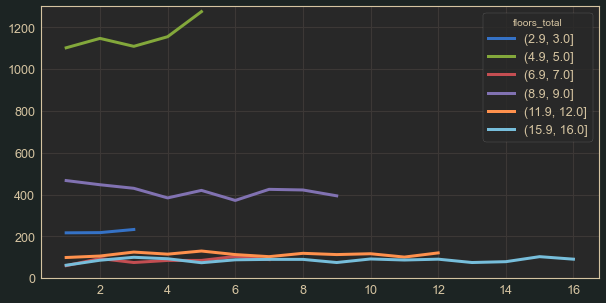

In [56]:
bins = pd.IntervalIndex.from_tuples([(2.9, 3), (4.9, 5), (6.9, 7), (8.9, 9), (11.9, 12), (15.9, 16)])
(df.pivot_table(index = 'floor', columns = pd.cut(df['floors_total'], bins = bins, 
                duplicates = 'drop'), values = 'total_area', aggfunc = 'count')
                .plot(style = '-', linewidth = 3, ylim = (0, 1300), xlabel = '', figsize = (10, 5)));

Была мысль, что квартиры на последних этажах высотных зданий продают реже, потому что они видовые и их берегут для души. Но это не так, этажность дома никак не влияет на то, квартиры с какого этажа продаются чаще или реже. Разве что, в пятиэтажных домах квартиры на последних этажах выставляют на продажу на 15% чаще, чем остальные - единственное объяснение может быть в том, что в пятиэтажных домах (многие из которых в Петербурге построены по одному проекту), жить на последних этажах неудобно: может быть, с потолка течёт, а может - нет лифта.

Коль скоро с помощью здравого смысла критерий для предказания пропусков не найти, обратимся к вероятности: какова вероятность того, что данный этаж или один из следующих двух будет последним? Извлечём статистическую вероятность из тех данных, что у нас в наличии.

Для множества n-этажей, где эта вероятность достаточно высока, установим общее число этажей как n +1. Добавлять единицу важно, поскольку один из вопросов, на которые предстоит ответить - это особенности, связанные с продажами квартир на последних этажах. А таких квартир не так много, и данные по ним лучше оставить в нетронутом, неискажённом виде.

В тех строчках, где с большой вероятностью утверждать n +1 не получится, заполним пропуски значением 'unknown'.

In [57]:
probab_penulti = df.loc[ df['floors_total'] - df['floor'] <= 2, 'floor' ].value_counts()
probab_penulti = pd.concat([probab_penulti, df['floor'].value_counts()], join = 'inner', axis = 1)
probab_penulti['probab_penulti'] = probab_penulti.iloc[:, 0].div(probab_penulti.iloc[:, 1])
display(probab_penulti.sort_values(by = 'probab_penulti', ascending = False).head(10))

list_of_penulti = probab_penulti[ probab_penulti['probab_penulti'] > 0.5 ].index #probab_penulti
dict_for_mapping = {}
for x in list_of_penulti:
    dict_for_mapping[x] = x + 1
    
df.loc[ df['floors_total'].isna(), 'floors_total' ] = (df
                                                       .loc[ df['floors_total'].isna(), 'floor' ]
                                                       .map(dict_for_mapping))

df.loc[ df['floors_total'].isna(), 'floors_total' ] = unknown

,floor,floor,probab_penulti
32,1,1,1.000000
33,1,1,1.000000
25,46,46,1.000000
26,22,24,0.916667
24,53,63,0.841270
23,80,100,0.800000
27,8,10,0.800000
4,1652,2804,0.589158
5,1521,2621,0.580313
8,576,1083,0.531856


Сделано. Теперь о высоте потолков. Покажем на графике зависимость высоты потолков от цены и от расстояния до центра. В таблице 'gaps_investigation' есть указание на то, что к высоте потолков имеет какое-то отношение размер кухни, а если размер кухни имеет значение, то зависимость от размера жилой площади тоже можно проверить.

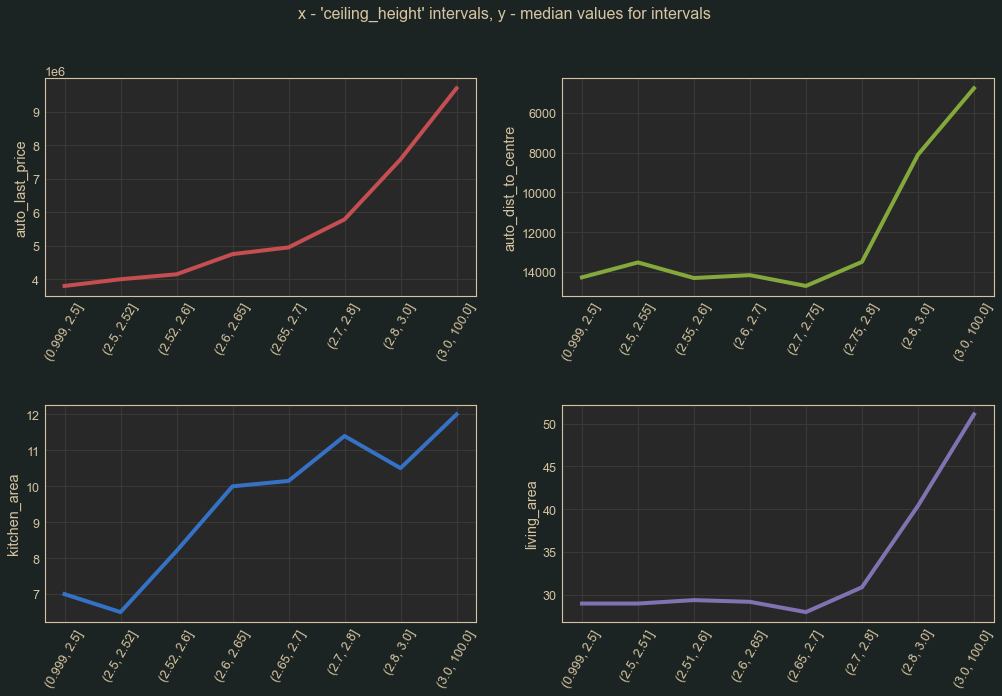

In [58]:
fig = plt.figure(figsize = (17, 10))
fig.suptitle("x - 'ceiling_height' intervals, y - median values for intervals", fontsize = 16)
grid = fig.add_gridspec(ncols = 2, nrows = 2, hspace = 0.5)
ax1 = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[0, 1])
ax3 = fig.add_subplot(grid[1, 0])
ax3 = fig.add_subplot(grid[1, 1])

cost_table = df.groupby(pd.qcut(df['ceiling_height'], 8)).agg({'auto_last_price': ['median', 'std']}).reset_index()
distance_table = (df[ df['auto_dist_to_centre'] < 30000 ]
                  .groupby(pd.qcut(df.loc[ df['auto_dist_to_centre'] < 30000, 'ceiling_height'], 8))
                  .agg({'auto_dist_to_centre': ['median', 'std']})
                  .reset_index())
k_area_table = (df[ df['kitchen_area'] != unknown ]
              .groupby(pd.qcut(df.loc[ df['kitchen_area'] != unknown, 'ceiling_height'], 8))
              .agg({'kitchen_area': ['median', 'std']}).reset_index())
l_area_table = (df[ df['living_area'] != unknown ]
              .groupby(pd.qcut(df.loc[ df['living_area'] != unknown, 'ceiling_height'], 8))
              .agg({'living_area': ['median', 'std']}).reset_index())

for ax, table, color in zip(fig.axes, 
                            [cost_table, distance_table, k_area_table, l_area_table], 
                            ['r', 'g', 'b', 'm']):
    ax.plot(table.index, table.iloc[:, 1], linewidth = 4, color = color)
    ax.set(ylabel = list(table.columns)[1][0], xticks = list(table.index))
    ax.set_xticklabels(table.iloc[:, 0].astype('object'), rotation = 60)
    
ax2.invert_yaxis()

display(fig)
plt.close(fig)

In [59]:
for col in ['auto_last_price', 'auto_dist_to_centre', 'kitchen_area', 'living_area']:
    corr_spr = df['ceiling_height'].corr(df[col], method = 'spearman')
    print(f"spearman corr. 'ceiling_height'/'{col}' = {round(corr_spr, 2)}")

spearman corr. 'ceiling_height'/'auto_last_price' = 0.54
spearman corr. 'ceiling_height'/'auto_dist_to_centre' = -0.41
spearman corr. 'ceiling_height'/'kitchen_area' = 0.54
spearman corr. 'ceiling_height'/'living_area' = 0.28


До отметки в 2.7 метров высоты единственный фактор, который соотносится с размером потолков - это размер кухни. Зато после 2.7. начинается линейная, притом резкая корреляция со ценой, жилой площадью и расстоянием до центра. Наиболее постоянная и равномерная корреляция - с ценой. Таким образом, стартовой точке в 2.7 метра соответствует цена в 6 млн., расстояние до центра меньше 13 км и жилая площадь больше 31 квадратного метра. Если квартира удовлетворяет любым двум из этих условий, я берусь спрогнозировать высоту потолков. 

Но пропусков более 40%, поэтому запустим ещё один алгоритм: если строчка не подходит под условия, с помощью которых мы находим значения в зоне линейной корреляции, мы, тем ни менее, рассматриваем медианные значения, которые получены при std менее чем 0.5. Если таких медианных значений меньше двух (из тех трёх, которые мы рассчитываем) или если их разность больше восьми сантиметров высоты, то всё-таки вставляем 'unknown'. Если таких медиан две или три и разность минимальной и максимальной медианы меньше 8 сантиметров, то вставляем среднее значение.

In [60]:
df['dist_to_centre_qcut_30'] = pd.qcut(df.loc[ df['auto_dist_to_centre'].notna(), 'auto_dist_to_centre' ], 30)
df['auto_last_price_qcut_40'] = pd.qcut(df['auto_last_price'], 40)
df['living_area_qcut_15'] = pd.qcut(df.loc[ df['living_area'] != unknown, 'living_area' ] , 15)

mapping_table_dist = df.groupby('dist_to_centre_qcut_30')['ceiling_height'].agg(['median', 'std'])
mapping_table_price = df.groupby('auto_last_price_qcut_40')['ceiling_height'].agg(['median', 'std'])
mapping_table_area = (df[ df['living_area'] != unknown ]
                      .groupby('living_area_qcut_15')['ceiling_height'].agg(['median', 'std']))

In [61]:
inserted_from_progression = 0
inserted_low_std = 0
inserted_unknowns = 0

def for_ceiling_height(row, mapping_table_dist, mapping_table_price, mapping_table_area):

    global inserted_from_progression
    global inserted_low_std
    global inserted_unknowns
                                
    if (((row['auto_last_price'] > 7000000) and (row['living_area'] > 31))
          or ((row['auto_dist_to_centre'] < 13000) and (row['living_area'] > 31))
            or ((row['auto_last_price'] > 7000000) and (row['auto_dist_to_centre'] < 13000))):
        
        mean_median = (mapping_table_dist.loc[row['dist_to_centre_qcut_30'], 'median'] +
                       mapping_table_price.loc[row['auto_last_price_qcut_40'], 'median'] +
                       mapping_table_area.loc[row['living_area_qcut_15'], 'median']) / 3
        inserted_from_progression += 1
        return mean_median
    
    else:
        medians_low_std = []
        for table, accessor in [(mapping_table_dist, 'dist_to_centre_qcut_30'),
                                (mapping_table_price, 'auto_last_price_qcut_40'),
                                (mapping_table_area, 'living_area_qcut_15')]:
            if table.loc[ row[accessor], 'std' ] <=  0.5:
                medians_low_std.append(table.loc[ row[accessor], 'median' ])
        if (len(medians_low_std) <= 1) or (max(medians_low_std) - min(medians_low_std) > 0.8):
            inserted_unknowns += 1
            return unknown
        else:
            inserted_low_std += 1
            return round(sum(medians_low_std) / len(medians_low_std), 2)

In [62]:
(df.loc[ ((df['ceiling_height'].isna()) & 
         (df['living_area'] != unknown) &
         (df['auto_dist_to_centre'].notna())),
          'ceiling_height']) = (df[ ((df['ceiling_height'].isna()) & 
                                    (df['living_area'] != unknown) &
                                    (df['auto_dist_to_centre'].notna())) ]
                                    .apply(for_ceiling_height, axis = 1,
                                                       args = (mapping_table_dist, 
                                                       mapping_table_price, mapping_table_area,)))
print(inserted_from_progression, 'median values above ~2.75 have been inserted')
print(inserted_low_std, 'median values with low std have been inserted')
print(inserted_unknowns, "'unknowns' have been inserted")
print("Current number of gaps in 'ceiling_height' column:", df['ceiling_height'].isna().sum())

2169 median values above ~2.75 have been inserted
2743 median values with low std have been inserted
3125 'unknowns' have been inserted
Current number of gaps in 'ceiling_height' column: 1158


Мы применили функцию к тому срезу, в котором в столбцах 
'kitchen_area' и 'dist_to_centre' нет пропусков. Из-за этого в срез не была включена и часть пропущенных значений 'ceiling_height' - именно про них последняя строчка этого вывода. В целом,эти пропуски стоит заполнить значением 'unknown', так как в столбцах, которые мы используем для предказания, не хватает данных. И, в конечном итоге, мы сделали что могли - от большей части пропусков всё же избавились, и сделали это хоть и абы как, зато красиво!

Оставшуюся часть пропусков можно заполнить в одной ячейке. 

In [63]:
df.loc[:, 'ceiling_height'] = df['ceiling_height'].fillna(unknown)
df.loc[:, 'auto_parks_nearby'] = df['auto_parks_nearby'].fillna(unknown)
df.loc[:, 'auto_dist_to_airport'] = df['auto_dist_to_airport'].fillna(unknown)
df.loc[ (df['auto_ponds_nearby'].isna()) & (df['auto_dist_to_park'].isna()), 'auto_dist_to_park'] = (df[ 
    (df['auto_ponds_nearby'].isna()) & (df['auto_dist_to_park'].isna())]['auto_dist_to_park']).fillna(unknown)
df.loc[ (df['auto_ponds_nearby'].isna()) & (df['auto_dist_to_pond'].isna()), 'auto_dist_to_pond'] = (df[ 
    (df['auto_ponds_nearby'].isna()) & (df['auto_dist_to_pond'].isna())]['auto_dist_to_pond']).fillna(unknown)
df.loc[:, 'auto_ponds_nearby'] = df['auto_ponds_nearby'].fillna(unknown)
    
df.loc[:, 'auto_days_posted'] = df['auto_days_posted'].fillna(zero)
df.loc[:, 'auto_dist_to_pond'] = df['auto_dist_to_pond'].fillna(zero)
df.loc[:, 'auto_dist_to_park'] = df['auto_dist_to_park'].fillna(zero)
df.loc[:, 'balcony'] = df['balcony'].fillna(zero)
df.loc[:, 'auto_dist_to_centre'] = df['auto_dist_to_centre'].fillna(zero)

df.loc[:, 'auto_locality_name'] = df['auto_locality_name'].cat.add_categories('unknown').fillna('unknown')
df.loc[:, 'dist_to_centre_qcut_30'] = df['dist_to_centre_qcut_30'].cat.add_categories(unknown).fillna(unknown)
df.loc[:, 'living_area_qcut_15'] = df['living_area_qcut_15'].cat.add_categories(unknown).fillna(unknown)

Мы закончили с пропусками?  
-Ноль значит "да"

In [64]:
df.isna().sum().sum()

0

## Переформатирование 
<a id='target3'></a>

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   total_area               23699 non-null  float32       
 1   studio                   23699 non-null  bool          
 2   rooms                    23699 non-null  category      
 3   open_plan                23699 non-null  bool          
 4   living_area              23699 non-null  float32       
 5   kitchen_area             23699 non-null  float32       
 6   floors_total             23699 non-null  float32       
 7   floor                    23699 non-null  uint8         
 8   ceiling_height           23699 non-null  float32       
 9   balcony                  23699 non-null  float32       
 10  auto_total_images        23699 non-null  uint8         
 11  auto_ponds_nearby        23699 non-null  float32       
 12  auto_parks_nearby        23699 n

В начале проекта мы отформатировали данные, передав параметр `downcast` и сделав строковые столбцы категориальными. Остаётся поменять float на int - во-первых, вещественные числа лучше воспринимаются, чем целые. Во-вторых, они быстрее и точнее обрабатываются. 
Вызовем столбцы float чтобы были перед глазами.

In [66]:
df.select_dtypes(include = 'float32').head(3).iloc[:, :8]

,total_area,living_area,kitchen_area,floors_total,ceiling_height,balcony,auto_ponds_nearby,auto_parks_nearby
0,108.000000,51.000000,25.0,16.0,2.70,-909090.0,2.0,1.0
1,40.400002,18.600000,11.0,11.0,2.58,2.0,0.0,0.0
2,56.000000,34.299999,8.3,5.0,2.60,0.0,2.0,1.0


In [67]:
df.select_dtypes(include = 'float32').head(3).iloc[:, 8:]

,auto_last_price,auto_dist_to_pond,auto_dist_to_park,auto_dist_to_centre,auto_dist_to_airport,auto_days_posted
0,13000000.0,755.0,482.0,16028.0,18863.0,-909090.0
1,3350000.0,-909090.0,-909090.0,18603.0,12817.0,81.0
2,5196000.0,574.0,90.0,13933.0,21741.0,558.0


Большинство из них легко трансформировать - достаточно отбросить ноль там, где ноль - единственный символ в дробной части. Высоту потолков, измеряемую сейчас в метрах, можно исчислять и в сантиметрах - умножить на сто и конвертировать в int. А столбцы с площадью придётся оставить какие есть, лишь округлим дроби до десятков. Само собой, квадратные метры можно по формуле перевести в квадратные сантиметры, но этим мы больше запутаем себя, чем принесём пользу. Дело не в ювелирной точности, просто такие данные даже не квантильные группы толком не разбить (не провести границу), а строить графики для четырёх точек плохо с точки зрения даже элементарной точности. Оставим одну цифру после запятой.

In [68]:
df.loc[ df['ceiling_height'] != unknown, 'ceiling_height'] = (df.loc[ df['ceiling_height'] != unknown, 
                                                                     'ceiling_height'] * 100).round(0)

for col in ['floors_total', 'balcony', 'auto_ponds_nearby', 'auto_last_price', 'auto_parks_nearby',
            'auto_dist_to_airport', 'auto_dist_to_pond', 'auto_dist_to_park', 'auto_days_posted', 
            'auto_dist_to_centre', 'auto_dist_to_airport', 'ceiling_height']:
    df[col] = pd.to_numeric(df[col], errors = 'raise', downcast = 'signed')

for col in ['total_area', 'living_area', 'kitchen_area']:
    df[col] = df[col].apply(lambda x: round(x, 1))

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   total_area               23699 non-null  float64       
 1   studio                   23699 non-null  bool          
 2   rooms                    23699 non-null  category      
 3   open_plan                23699 non-null  bool          
 4   living_area              23699 non-null  float64       
 5   kitchen_area             23699 non-null  float64       
 6   floors_total             23699 non-null  int32         
 7   floor                    23699 non-null  uint8         
 8   ceiling_height           23699 non-null  int32         
 9   balcony                  23699 non-null  int32         
 10  auto_total_images        23699 non-null  uint8         
 11  auto_ponds_nearby        23699 non-null  int32         
 12  auto_parks_nearby        23699 n

<a id='target4'></a>

## Duplicated values

Есть грубые дубликаты в датасете?

In [70]:
df[df.duplicated()].shape[0]

0

Нет, но чуть ранее мы случайно наткнулись на неявные дубликаты в столбце 'auto_locality_name'. Машина не может совершить описку, а значит, неявные дубликаты вроде 'Кудрово' и 'деревня Кудрово' ограничены в количестве и  обусловлены взаимозаменяемостью. Вызову список уникальных имён в столбце 'auto_locality_name', соберу их в одну строчку и разобью методом `split()` на месте пробелов. С помощью функции `Counter` из библиотеки `collections` посчитаю, какие элементы списка встречаются более одного раза. В данных, с которыми мы сейчас работаем, имена собственные написаны, можно заметить, с заглавной буквы, а такие слова как "посёлок", "станция" - со строчной. Можно настроить двойное условие: элемент списка должен не только повторяться больше одного раза, но и начинаться с заглавной буквы. 

In [71]:
duplicated_names = []
for key, value in Counter(' '.join(list(df['auto_locality_name'].dropna().unique())).split()).items():
    if value > 1:
        if key[0].istitle():
            duplicated_names.append(key)
            
print(duplicated_names)

['Янино-1', 'Мурино', 'Кудрово', 'Красный', 'Бор', 'Фёдоровское', 'Лебяжье', 'Кузьмоловский', 'Новая', 'Ропша', 'Аннино', 'Старая', 'Новый', 'Свет', 'Никольское', 'Романовка', 'Бугры', 'Рощино', 'Павлово', 'Победа', 'Терволово', 'Советский', 'Петровское', 'Токсово', 'Вырица', 'Тельмана', 'Большая', 'Ижора', 'Лесогорский', 'Рахья', 'Колпаны', 'Ладога', 'Зимитицы', 'Свердлова', 'Рябово', 'Бегуницы', 'Поляны', 'Мга', 'Малое', 'Мичуринское', 'Ильичёво', 'Вещево', 'Калитино', 'Приладожский', 'Щеглово', 'Гаврилово', 'Рабитицы', 'Назия', 'Малукса', 'Гарболово', 'Приветнинское', 'Мельниково', 'Усть-Луга', 'Любань', 'Стеклянный', 'Форносово', 'Сумино', 'Возрождение', 'Красная', 'Горка', 'Лисий', 'Нос', 'Жилгородок', 'Громово', 'Коробицыно', 'Кобралово', 'Лесное', 'Перово', 'Пансионат', 'Зелёный']


Всё верно, но в списке есть такие имена собственные, которые могут входить в названия разных населённых пунктов. Чтобы не сделать случайно из двух разных населённых пунктов один, вызовем для них названия полностью.

In [72]:
for name in df['auto_locality_name'].cat.categories:
    # iteration over a list is quite faster than over categories
    if any(('Большая' in name, 'Красная' in name, 'Малое' in name, 
            'Новый' in name, 'Новая' in name, 'Старая' in name)):
        print(name)

Новая Ладога
городской поселок Большая Ижора
деревня Большая Вруда
деревня Большая Пустомержа
деревня Малое Верево
деревня Малое Карлино
деревня Старая
деревня Старая Пустошь
поселок Красная Долина
поселок Новый Свет
поселок Новый Учхоз
поселок Старая Малукса
поселок городского типа Большая Ижора
посёлок Новый Свет
посёлок Старая Малукса
посёлок Форт Красная Горка
садовое товарищество Новая Ропша
село Старая Ладога


Так и получилось - повторение всех шести имен, а также, как выяснилось, повторение имени "Ладога" не показательно в поиске дубликатов. Удалим их из списка и осуществим замену дублей.

In [73]:
[duplicated_names.remove(x) for x in ['Новая', 'Старая', 'Большая', 'Красная', 'Новый', 'Малое', 'Ладога']];

In [74]:
print('In auto_locality_name column there were', 
      df['auto_locality_name'].cat.categories.shape[0], 
      'unique values.', end = '')

for x in duplicated_names:
    try:
        df['auto_locality_name'] = df['auto_locality_name'].cat.add_categories(x)
    except ValueError:
    # if the value that i am trying to add is already a category,
    # a ValueError will be raised, but it's all right and we can skip it
        pass
    
def for_duplicated_names(value, duplicated_names_copy):
    for x in value.split():
        if x in duplicated_names_copy:
            return x
    return value

(df.loc[ df['auto_locality_name'].notna(), 
        'auto_locality_name' ]) = (df.loc[ df['auto_locality_name'].notna(), 'auto_locality_name' ]
                                   .apply(for_duplicated_names, args = (duplicated_names,)))
                                   
df['auto_locality_name'] = df['auto_locality_name'].cat.remove_unused_categories()
print(' Now there are', df['auto_locality_name'].cat.categories.shape[0], 'unique values')                                  

In auto_locality_name column there were 365 unique values. Now there are 298 unique values


# Анализ выбросов и последние приготовления
<a id='target5'></a>

## Выбросы

In [75]:
def outliers_investigation(include = '', top_whisker = 1.5, bot_whisker = 1.5, 
                           exclude = '', exclude_cat = '', zero = -909090, unknown = -777777):
    """
    Работает с переменной df. Нужно предварительно подготовить df и перевести столбцы в категориальный 
    тип, есть подозрения на то, что выбросы как-то увязаны с этими столбцами. 
    Функция перебирает все числовые столбцы, для каждого строит боксплот, собирает информацию отдельно
    про верхние и про нижние выбросы (выводит таблицами под рисунком) Если в какой-либо категории выбросов 
    на 10+% больше, чем в среднем (и более 3% от общего числа), выводит информацию о ней на экран. Для 
    исключения столбцов типа category нужно передать их в кавычках через пробел в параметре exclude_cat=
    В параметрах include= и exclude= принимает названия столбцов, разделённые пробелом. Если параметры 
    не переданы, будет работать со всеми числовыми столбцами. Если передан include= , будет работать 
    только с теми столбцами, которые в include. От значений bot_whiskers= и top_whiskers= (пер. 'усы') 
    зависит то, какие значения будут считаться выбросами. По умолчанию все whiskers= 1.5 (полтора 
    межквартильных размаха), значения zero и unknown - -909090 и -777777.
    В рисунке, выполненном функцией, верхние и нижние выбросы масштабируются
    по собственным осям Y, и рисунок даёт представление о том, как распределены значения не 
    только за пределами полутора (или сколько задано) межквартильных размахов, но и внутри. 
    Нужно иметь в виду, что пустое расстояние между столбцами сокращено. Гистограмма построена с помощью
    функции cut( ), начиная от значений Q1 и Q3, но при выбросах на значительную величину
    большая часть значений между Q1, Q3 и 1.5iqr попадает в первые несколько корзин. Визуально это
    выглядит так: всего несколько столбцов заходят внутрь боксплота. Несмотря на это неудобство, cut( ) 
    предпочтительнее чем qcut( ) в работе с редкими, случайно или ошибочно возникающими значениями. 
    С qcut( ) получилось бы наоборот - почти все корзины пошли бы на регулярные значения, и всего несколько - 
    на выбросы.
    """
    global df
        
    style = dict(size = 11, color = '#929591',  
             path_effects = [path_effects.SimpleLineShadow(linewidth = 2, foreground = 'black'), 
                             path_effects.Normal()])
    counter = 0
    
    categories_list = list(df.select_dtypes(include = ['category']).columns)
    if len(exclude_cat) > 0:
        for x in exclude_cat.split():
            categories_list.remove(x)
    
    proceeding_list = list(
                           df.select_dtypes(include = ['uint8', 'uint16', 'uint32', 'uint64', 
                                                       'int8', 'int16', 'int32', 'int64', 'integer', 
                                                       'float16', 'float32', 'float64']).columns)
    if len(exclude) > 0:
        for x in exclude.split():
            proceeding_list.remove(x)
    
    if len(include) > 0:
        proceeding_list = include.split()
        
    leng = len(proceeding_list) # for a counter
        
    outliers_table = pd.DataFrame(index = ['top', 'bottom'], 
                                  columns = ['total_rows', 'count', 'prc', 'min', 'max'])
    # outliers_tables' cells will be renewed in every iteration
  
    for col in proceeding_list:
        counter += 1
        print(f'Processing {counter} out of {leng}: {col}...')

        df_no_gaps = df[ (df[col] != unknown) & (df[col] != zero) & df[col].notna() ]
        total_rows = df_no_gaps.shape[0]   
    
        Q3 = df_no_gaps[col].quantile(0.75)
        Q2 = df_no_gaps[col].quantile(0.5)
        Q1 = df_no_gaps[col].quantile(0.25)
        iq_range = Q3 - Q1
        top_threshold = Q3 + (iq_range * top_whisker)
        bot_threshold = Q1 - (iq_range * bot_whisker)

        # making two slices containing all df columns (i'll need them to learn the way outskirts spread)
        df_top_slice = df_no_gaps[ df_no_gaps[col] > top_threshold ]
        df_bot_slice = df_no_gaps[ df_no_gaps[col] < bot_threshold ]
        
        if (df_top_slice.shape[0] == 0) and (df_bot_slice.shape[0] == 0):
            print(f"Outlying values in '{col}' column are not found.")
            print('Type anything to continue or type [exit]:', end = '')
            if input() == 'exit':
                return
            continue 
            
        # making two booleans: top_outliers_exist and bot_outliers_exist for future actions
        bot_outliers_exist = False
        top_outliers_exist = False
        if df_top_slice.shape[0] > 0:
            top_outliers_exist = True
        if df_bot_slice.shape[0] > 0:
            bot_outliers_exist = True

        # making two slices of a target column from min() to Q1 and from Q3 to max()
        if top_outliers_exist:
            right_slice = df_no_gaps[ df_no_gaps[col] > Q3 ][col]

        # creating top_value_counts and bot_value_counts (that's what we'll be plotting) via many 
        # functions combined
            top_value_counts = pd.cut(right_slice, 100, precision = 3, duplicates = 'drop').value_counts()
            top_value_counts = top_value_counts[ top_value_counts > 0 ].sort_index().reset_index()
            # due to 32b-Win i cant run some cut( )s when the number of bins exceeds 100. 
            # an error 'cannot cast array from dtype...' raises. so the numver is 100. 
            # if 100 is too much - 'duplicates=' parameter will work. if it works, i am
            # not concerned about losing steady progression. i lose it anyway after 
            # completing [... > 0] slice. i need to make this slice cause the distance between 
            # outlying values can be enormous - i have no need in illustrating it via
            # drawing all empty intervals on an ax.

        # receiving a closest to bot_threshold and top_threshold interval:
        # getting and index of the value that is the closest to a threshold and repeating
        # a cut( ) operation on a series, then receiving purposed interval via .loc[]
            closest_to_top_thr = right_slice.loc[ right_slice > top_threshold ].sort_values().iloc[0]
            top_thr_interval = (pd.cut(right_slice.append(pd.Series(closest_to_top_thr)), 
                                 100, precision = 3, duplicates = 'drop').iloc[-1])
            # append( ) operation doesn't change bins' intervals that are fabricated by cut( ) 
            # (comparing to '_value_counts'), cause the value we're appending is the same 
            # one that already exists a base slice

        # what is the counting number of an interval that contains a threshold? 
            top_thr_bin = list(top_value_counts.query('index == @top_thr_interval').index)[0]
            # a counting number is a number of bar that will represent an interval on a plot.
            # we need the counting number of an interval that includes a threshold value for three things:
            # we'll adjust boxplots' location using it as a reference point, all the bars before/after 
            # top/bot_thr_bin we'll make progressively transparent, and we'll use it as a key for slicing, 
            # like on the next step

        # receiving ylim for ax_top (1.2 of max occurence among outliers)
            top_ylim = top_value_counts.loc[top_thr_bin:, col].max() * 1.2
            # as you may've noticed, we've made one slice to Q1, and one from Q3, although the plot is 
            # dedicated to outliers, not to the values beyond Q1 and above Q3. That's why we need to 
            # explicitly set such ylim that would let us examine both outlying values and their relation 
            # to 'in-lying' values at the same time
            
        # searching for the closest (to the threshold) 'in-lier' value within iqr. if i set as xlim a 
        # 'theoretical' threshold, which results relatively far from the closest 'in-lier',  
        # a whisker of a boxplot will be shorter than axs' border
            closest_to_top_thr_from_inside = right_slice.loc[ right_slice <= top_threshold ].sort_values().iloc[-1]
        
        # counting the number of bins for top
            top_bins = top_value_counts.shape[0]
            
        # creating alpha_mask - list of an alpha parameter for every bar. the idea is to make bars 
        # more transparent while they are getting closer to Q3/Q1 
            alpha_mask_top = list(np.linspace(0, 1, top_thr_bin))
            alpha_mask_top.extend([1 for i in range(top_bins - top_thr_bin)])
            
        # if y-lim is six times higher than some bar, i'm afraid that we won't see the bar itself. i want to
        # add text descriptions to such bars. for this reason i'm making another column in '_value_counts'
            top_value_counts['needs_description'] = (top_value_counts[col] * 6 <= top_ylim)
            
        # finally i want to pick every forth bars' location as a place for a tick, starting from the last one.
        # i stop placing ticks when it is 3 bars to threshold
            tick_locations_top = [i for i in range(top_bins -1, top_thr_bin + 3, -4)]
            # there will be no error, just an empty list if the command is, e.g. '... in range(5, 12, -10)'
            # -1 cause the index of 54th element is 53
        
        else:
            top_bins = 1
            # i assign one bin to empty slices to reserve the possibility to create an ax

        # now we do all the same things to bottom outliers
        if bot_outliers_exist:
            left_slice = df_no_gaps[ df_no_gaps[col] < Q1 ][col]
            bot_value_counts = pd.cut(left_slice, 100, precision = 3, duplicates = 'drop').value_counts()
            bot_value_counts = bot_value_counts[ bot_value_counts > 0 ].sort_index().reset_index()
            closest_to_bot_thr = left_slice.loc[ left_slice < bot_threshold ].sort_values().iloc[-1]
            bot_thr_interval = (pd.cut(left_slice.append(pd.Series(closest_to_bot_thr)), 
                                 100, precision = 3, duplicates = 'drop').iloc[-1])
            bot_thr_bin = list(bot_value_counts.query('index == @bot_thr_interval').index)[0]
            bot_ylim = bot_value_counts.loc[:bot_thr_bin, col].max() * 1.2
            closest_to_bot_thr_from_inside = left_slice.loc[ left_slice >= bot_threshold ].sort_values().iloc[0]
            bot_bins = bot_value_counts.shape[0]
            alpha_mask_bot = [1 for i in range(bot_thr_bin +1)]
            alpha_mask_bot.extend(list(np.linspace(1, 0, (bot_bins - bot_thr_bin))))
            bot_value_counts['needs_description'] = (bot_value_counts[col] * 6 <= bot_ylim)
            tick_locations_bot = [i for i in range(0, bot_thr_bin -3, 4)]
        else:
            bot_bins = 1

        # counting the number of bins for center
        center_bins = (pd.cut(
            df_no_gaps.loc[ (df_no_gaps[col] >= Q1) & (df_no_gaps[col] <= Q3), col], 50, duplicates = 'drop' )
            .cat.categories.shape[0])
            # bins = 50 means (while edges had 100) that ideally i want to have a 1:2 proportion boxplot:edges

        # counting the total number of bins on picture and the width of a picture (= of a bin)
        bins_total = center_bins + top_bins + bot_bins
        figure_width = 0.13 * bins_total
        if figure_width > 18:
            figure_width = 18
        if figure_width < 8:
            figure_width = 8
        
        
        """
        # DEBUG PACK:
        
        print(bins_total)
        print(center_bins, 'center')
        print(top_bins, 'top')
        print(bot_bins, 'bot')
        print('\n' * 2)
        
        if bot_outliers_exist:
            print('BOTTOM')
            print('\n')
            print(bot_value_counts)
            print('\n')
            print('ax_bot = fig.add_subplot(grid[:, :bot_bins])')
            print('\n')
            print(bot_threshold, 'bot threshold')
            print(bot_thr_bin, 'bot threshold bin')
            print(len(alpha_mask_bot), 'alpha_mask_lengh bot')
            print(tick_locations_bot, 'tick locations bot')
            print('\n' * 2)
        
        if top_outliers_exist:
            print('TOP')
            print('\n')
            print(top_value_counts)
            print('\n')
            print('ax_top = fig.add_subplot(grid[:, -(top_bins):])')
            print('\n')
            print(top_threshold, 'top threshold')
            print(top_thr_bin, 'top threshold bin')
            print(len(alpha_mask_top), 'alpha_mask_lengh bot')
            print(tick_locations_top, 'tick locations top')
            print('\n' * 2)
        """
            
        # creating a column with customized spelling of intervals
        def customizing_intervals(interval):
            interval = str(interval)
            left, right = interval.split()
            left_integer, left_decimals = left.split('.')
            left_integer = left_integer[1:]
            left_decimals = left_decimals[0]
            right_integer, right_decimals = right.split('.')
            right_decimals = right_decimals[0]
            return ''.join([left_integer, '.', left_decimals, ' - ', right_integer, '.', right_decimals])
        if bot_outliers_exist:
            bot_value_counts['labels'] = bot_value_counts['index'].apply(customizing_intervals)
        if top_outliers_exist:
            top_value_counts['labels'] = top_value_counts['index'].apply(customizing_intervals)
          
        # creating a figure and an empty_ax that will fulfill an emtpy space. disabling all ticks
        # creating grid with 5 rows (boxplot will be placed on two lowests) and as many rows as there will be bins
        fig = plt.figure(figsize = (figure_width, 5))
        grid = fig.add_gridspec(6, bins_total, wspace = 0, hspace = 0)
        empty_ax = fig.add_subplot(grid[:5, :])
        empty_ax.tick_params(labelleft = False, labelbottom = False, grid_alpha = 0)
        
        # creating bars: all the code below is just one conditional expression with one fragment pasted 
        # three times, so don't be jaded if you are
        if top_outliers_exist and bot_outliers_exist:
            fig.suptitle(f'{col}: cut({bot_bins}) from min to Q1, cut({top_bins}) from Q3 to max', fontsize = 15)
            ax_bot = fig.add_subplot(grid[:5, :bot_bins])
            ax_bot.tick_params(grid_alpha = 0)
            ax_bot.set(xlim = (0, bot_bins), ylim = (0, bot_ylim))
            for i in list(bot_value_counts.index):
                ax_bot.bar(i, bot_value_counts.loc[i, col], width = 0.6, color = '#ff000d', alpha = alpha_mask_bot[i])
                if bot_value_counts.loc[i, 'needs_description']:
                    ax_bot.text(i, bot_value_counts.loc[i, col], bot_value_counts.loc[i, col], **style)
            ax_bot.set_xticks(tick_locations_bot)
            ax_bot.set_xticklabels([bot_value_counts.loc[i, 'labels'] for i in tick_locations_bot], rotation = 60)
            ax_bot.spines['right'].set_visible(False)

            ax_top = fig.add_subplot(grid[:5, -(top_bins):])
            ax_top.tick_params(labelright = True, labelleft = False, grid_alpha = 0)               
            ax_top.set(xlim = (0, top_bins), ylim = (0, top_ylim))
            for i in list(top_value_counts.index):
                ax_top.bar(i, top_value_counts.loc[i, col], width = 0.6, color = '#0504aa', alpha = alpha_mask_top[i])
                if top_value_counts.loc[i, 'needs_description']:
                    ax_top.text(i, top_value_counts.loc[i, col], top_value_counts.loc[i, col], **style)
            ax_top.set_xticks(tick_locations_top)
            ax_top.set_xticklabels([top_value_counts.loc[i, 'labels'] for i in tick_locations_top], rotation = 60)
            ax_top.spines['left'].set_visible(False)
            
       # creating central_ax in the the bottom of the figure. creating a boxplot over a definite slice. 
       # setting ylim from 0.9 to 1.1 to widen the box of boxplot, setting xlim and xticks
            ax_central = fig.add_subplot(grid[4:6, (bot_thr_bin +1):-(top_bins - top_thr_bin +1)])
            ax_central.set(xlim = (closest_to_bot_thr_from_inside, closest_to_top_thr_from_inside), ylim = (0.8, 1.2))
            ax_central.tick_params(labelleft = False, labelbottom = True, grid_alpha = 0)
            ax_central.set_xticks([closest_to_bot_thr_from_inside, Q1, Q2, Q3, closest_to_top_thr_from_inside])
            ax_central.set_xticklabels(['{:.1f}'.format(bot_threshold), '{:.1f}'.format(Q1), 
                                        '{:.1f}'.format(Q2), '{:.1f}'.format(Q3), '{:.1f}'.format(top_threshold)])
            
        
        elif top_outliers_exist:
            fig.suptitle(f'{col}: cut({top_bins}) from Q3 to max', fontsize = 15)
            empty_ax.tick_params(labelleft = False)
            empty_ax.set(ylabel = 'No bottom outliers')
            ax_top = fig.add_subplot(grid[:5, -(top_bins):])
            ax_top.tick_params(labelright = True, labelleft = False, grid_alpha = 0)               
            ax_top.set(xlim = (0, top_bins), ylim = (0, top_ylim))      
            for i in list(top_value_counts.index):
                ax_top.bar(i, top_value_counts.loc[i, col], width = 0.6, color = '#0504aa', alpha = alpha_mask_top[i])
                if top_value_counts.loc[i, 'needs_description']:
                    ax_top.text(i, top_value_counts.loc[i, col], top_value_counts.loc[i, col], **style)
            ax_top.set_xticks(tick_locations_top)
            ax_top.set_xticklabels([top_value_counts.loc[i, 'labels'] for i in tick_locations_top], rotation = 60)
            ax_top.spines['left'].set_visible(False)
            
            ax_central = fig.add_subplot(grid[4:6, :-(top_bins - top_thr_bin)])
            ax_central.set(xlim = (df_no_gaps[col].min(), closest_to_top_thr_from_inside), ylim = (0.8, 1.2))
            ax_central.tick_params(labelleft = False, labelbottom = True, grid_alpha = 0)
            ax_central.set_xticks([df_no_gaps[col].min(), Q1, Q2, Q3, closest_to_top_thr_from_inside])
            ax_central.set_xticklabels(['{:.1f}'.format(df_no_gaps[col].min()), '{:.1f}'.format(Q1), 
                                        '{:.1f}'.format(Q2), '{:.1f}'.format(Q3), '{:.1f}'.format(top_threshold)])
            

        elif bot_outliers_exist:
            fig.suptitle(f'{col}: cut({bot_bins}) from min to Q1', fontsize = 15)             
            empty_ax.tick_params(labelleft = False)
            empty_ax.yaxis.set_label_position('right')
            empty_ax.set_ylabel('No top outliers')
            ax_bot = fig.add_subplot(grid[:5, :bot_bins])
            ax_bot.tick_params(grid_alpha = 0)
            ax_bot.set(xlim = (0, bot_bins), ylim = (0, bot_ylim))
            for i in list(bot_value_counts.index):
                ax_bot.bar(i, bot_value_counts.loc[i, col], width = 0.6, color = '#ff000d', alpha = alpha_mask_bot[i])
                if bot_value_counts.loc[i, 'needs_description']:
                    ax_bot.text(i, bot_value_counts.loc[i, col], bot_value_counts.loc[i, col], **style)
            ax_bot.set_xticks(tick_locations_bot)
            ax_bot.set_xticklabels([bot_value_counts.loc[i, 'labels'] for i in tick_locations_bot], rotation = 60)
            ax_bot.spines['right'].set_visible(False)
            
            ax_central = fig.add_subplot(grid[4:6, (bot_thr_bin +1):])
            ax_central.set(xlim = (closest_to_bot_thr_from_inside, df_no_gaps[col].max()), ylim = (0.8, 1.2))
            ax_central.tick_params(labelleft = False, labelbottom = True, grid_alpha = 0)
            ax_central.set_xticks([closest_to_bot_thr_from_inside, Q1, Q2, Q3, df_no_gaps[col].max()])
            ax_central.set_xticklabels(['{:.1f}'.format(bot_threshold), '{:.1f}'.format(Q1), 
                                        '{:.1f}'.format(Q2), '{:.1f}'.format(Q3), '{:.1f}'.format(df_no_gaps[col].max())])

           
        # creating and customizing boxplot     
        bp = ax_central.boxplot(df_no_gaps[col], 
                        vert = False, patch_artist = True, showfliers = False, 
                        whis = max([bot_whisker, top_whisker]), notch = True)
        for whiskers in bp['whiskers']:
            whiskers = whiskers.set(color = '#ad8150', linewidth = 10)
        for caps in bp['caps']:
            caps = caps.set(color = '#ad8150', linewidth = 10)
        for medians in bp['medians']:
            medians = medians.set(color = 'red', linewidth = 2)
        for boxes in bp['boxes']:
            boxes = boxes.set_facecolor('grey')
            
        display(fig)
        plt.close(fig)


        outliers_table.loc[:, 'total_rows'] = total_rows
        outliers_table.loc['top', 'count'] = df_top_slice.shape[0]
        outliers_table.loc['bottom', 'count'] = df_bot_slice.shape[0]
        outliers_table.loc['top', 'prc'] = '{:.2%}'.format(outliers_table.loc['top', 'count'] / total_rows)
        outliers_table.loc['bottom', 'prc'] = '{:.2%}'.format(outliers_table.loc['bottom', 'count'] / total_rows)
        outliers_table.loc['top', 'min'] = df_top_slice[col].min()
        outliers_table.loc['bottom', 'min'] = df_bot_slice[col].min()
        outliers_table.loc['top', 'max'] = df_top_slice[col].max()
        outliers_table.loc['bottom', 'max'] = df_bot_slice[col].max()
        display(outliers_table.fillna('-'))
        print('\n')
    
        for cat_col in categories_list:
            comparing_categories = pd.concat([df_no_gaps[cat_col].value_counts(),
                                              df_top_slice[cat_col].value_counts(),
                                              df_top_slice[cat_col].value_counts(normalize = True),
                                              # top_outliers in each_category
                                              df_bot_slice[cat_col].value_counts(),
                                              df_bot_slice[cat_col].value_counts(normalize = True)],
                                              # bot_outliers in each_category
                                              axis = 1)
            comparing_categories.columns = ['values_in_category', 'top_outliers', 'top_outliers_prc', 
                                            'bot_outliers', 'bot_outliers_prc']
            comparing_categories['consists_of_top_outliers'] = (comparing_categories['top_outliers']
                                                                .div(comparing_categories['values_in_category'])
                                                                .fillna(0))
            comparing_categories['consists_of_bot_outliers'] = (comparing_categories['bot_outliers']
                                                                .div(comparing_categories['values_in_category'])
                                                                .fillna(0))
            # div( ) method supports division by zero, 
            # i can use it confidently even if a column has unused categories with 0 in 'value_counts'
            
            
            top_threshold_cat = comparing_categories['top_outliers'].mean() * 1.1
            bot_threshold_cat = comparing_categories['bot_outliers'].mean() * 1.1
            # all categories are included to .value_counts( ) resulting dataframe, even
            # if their count is 0, so .mean( ) will represent the situation correctly.
            # 0.1 (10%) i consider as an acceptable fluctuation within a category.
            # if more, want to be informed about this category
            
            remarkable_cats_top = (comparing_categories.loc[ 
                                                (comparing_categories['top_outliers'] > top_threshold_cat) &
                                                (comparing_categories['top_outliers_prc'] > 0.03)].index)
            remarkable_cats_bot = (comparing_categories.loc[ 
                                                (comparing_categories['bot_outliers'] > bot_threshold_cat) &
                                                (comparing_categories['bot_outliers_prc'] > 0.03)].index)
            homogeneous_cats_top = (comparing_categories.loc[ 
                                                comparing_categories['consists_of_top_outliers'] > 0.5].index)
            homogeneous_cats_bot = (comparing_categories.loc[ 
                                                comparing_categories['consists_of_bot_outliers'] > 0.5].index)
            # i want to be informed if any category consists of the rows 
            # with top or bot outliers more more than 0.5 (50%) percent
            
            if ((len(remarkable_cats_top) == 0) and (len(remarkable_cats_bot) == 0) and 
                (len(homogeneous_cats_top) == 0) and (len(homogeneous_cats_bot) == 0)):
                print(f"There is nothing special about '{col}' outliers in '{cat_col}' column.")
                continue
                
            top_mean_for_ordinary_cats = (comparing_categories.loc[ ~comparing_categories
                                                                  .index.isin(remarkable_cats_top),
                                                                  'top_outliers_prc']).mean()
            bot_mean_for_ordinary_cats = (comparing_categories.loc[ ~comparing_categories
                                                                  .index.isin(remarkable_cats_bot),
                                                                  'bot_outliers_prc']).mean()
            # i need these variables just to make an output that i will be able to understand
            
            if len(remarkable_cats_top) > 0:
                for remarkable_cat in remarkable_cats_top:
                    print('{: <25}'.format(cat_col), 
                          '> {: <25}'.format('{}'.format(remarkable_cat)), 
                          ' {:.1%}'.format(comparing_categories.loc[remarkable_cat, 'top_outliers_prc']), 
                          ' of all TOP outliers', sep = '')
                number_of_others = comparing_categories.shape[0] - len(remarkable_cats_top)
                print('{: <25}'.format(cat_col), 
                          '> {: <24}'.format(f'other categories ({number_of_others})'), 
                          ' ~{:.1%}'.format(top_mean_for_ordinary_cats), 
                          ' of all TOP outliers in each one', sep = '')
                print()
            if len(homogeneous_cats_top) > 0:
                for homogeneous_cat in homogeneous_cats_top:
                    print('{: <25}'.format(cat_col), 
                      '> {: <25}'.format('{}'.format(homogeneous_cat)), 
                      ' {:.1%}'.format(comparing_categories.loc[homogeneous_cat, 'consists_of_top_outliers']), 
                      f' of rows are TOP outliers', 
                      sep = '')
                print()
            else:
                print()
            
            if len(remarkable_cats_bot) > 0:
                for remarkable_cat in remarkable_cats_bot:
                    print('{: <25}'.format(cat_col), 
                          '> {: <25}'.format('{}'.format(remarkable_cat)), 
                          ' {:.1%}'.format(comparing_categories.loc[remarkable_cat, 'bot_outliers_prc']), 
                          ' of all BOTTOM outliers', sep = '')
                    number_of_others = comparing_categories.shape[0] - len(remarkable_cats_bot)
                print('{: <25}'.format(cat_col), 
                          '> {: <24}'.format(f'other categories ({number_of_others})'), 
                          ' ~{:.1%}'.format(bot_mean_for_ordinary_cats), 
                          ' of all BOTTOM outliers in each one', sep = '')
                print()
            if len(homogeneous_cats_bot) > 0:
                for homogeneous_cat in homogeneous_cats_bot:
                    print('{: <25}'.format(cat_col), 
                      '> {: <25}'.format('{}'.format(homogeneous_cat)), 
                      ' {:.1%}'.format(comparing_categories.loc[homogeneous_cat, 'consists_of_bot_outliers']), 
                      f' of rows are BOTTOM outliers', 
                      sep = '')
                    
            print('{:_<100}'.format(''))
            print()              
                
                
        incorrect = True
        print('Make a decision. Enter [all / top .* / bot .* / n / exit]:', end = ' ')
        while incorrect:
            command = input()
            if len(command.split()) == 2:
                try:
                    key = float(command.split()[1])
                    key_is_given = True
                except ValueError:
                    print("Can't convert your key to float type. Try again:", end = ' ')
                    continue
            else:
                key_is_given = False

            if command == 'all':
                before = df[ ((df[col] <= bot_threshold) | (df[col] >= top_threshold)) & (df[col].notna()) 
                             & (df[col] != zero) & (df[col] != unknown) ].shape[0]
                df[col] = df[col].where( (df[col].isna()) | (df[col] == zero) | (df[col] == unknown) | 
                                               (df[col] > bot_threshold) | (df[col] < top_threshold), unknown )
                if before != 0:
                    incorrect = False
                    print(f"{before} values in '{col}' were replaced by '{unknown}'", end = '\n')
                else: 
                    print("There is no sence in removing data from an empty slice. Try again:", end = ' ')
            elif command == 'top':
                before = df[ (df[col] >= top_threshold) & (df[col].notna()) & (df[col] != zero) & 
                                    (df[col] != unknown) ].shape[0]
                df[col] = df[col].where( (df[col].isna()) | (df[col] == zero) | (df[col] == unknown) | 
                                               (df[col] < top_threshold), unknown )
                if before != 0:
                    incorrect = False
                    print(f"{before} top-outliers in '{col}' were replaced by '{unknown}'", end = '\n')
                else: 
                    print("There is no sence in removing data from an empty slice. Try again:", end = ' ')
            elif command == 'bot':
                before = df[ (df[col] <= bot_threshold) & (df[col].notna()) & (df[col] != zero) & 
                                    (df[col] != unknown) ].shape[0]
                df[col] = df[col].where( (df[col].isna()) | (df[col] == zero) | (df[col] == unknown) | 
                                               (df[col] > bot_threshold), unknown )
                if before != 0:
                    incorrect = False
                    print(f"{before} bot-outliers in '{col}' were replaced by '{unknown}'", end = '\n')
                else: 
                    print("There is no sence in removing data from an empty slice. Try again:", end = ' ')
            elif command == 'n':
                incorrect = False
                pass
            elif command == 'exit':
                return
            elif key_is_given:
                if command.split()[0] == 'top':
                    try:
                        before = df[ (df[col] >= key) & (df[col].notna()) & (df[col] != zero) & 
                                    (df[col] != unknown) ].shape[0]
                        df[col] = df[col].where( (df[col].isna()) | (df[col] == zero) | 
                                                       (df[col] == unknown) | (df[col] < key), unknown )
                        if before != 0:
                            incorrect = False
                            print(f"{before} values equal or greater than {key} were replaced by '{unknown}' in '{col}'", end = '\n')
                        else: 
                            print("You've probably passed a wrong key: there is no sence in removing data from an empty slice. Try again:", end = ' ')
                    except TypeError:
                        print("You've passed an invalid key - TypeError has arised. Try again:", end = ' ')
                elif command.split()[0] == 'bot':
                    try:
                        before = df[ (df[col] <= key) & (df[col].notna()) & (df[col] != zero) & 
                                    (df[col] != unknown) ].shape[0]
                        df[col] = df[col].where( (df[col].isna()) | (df[col] == zero) | 
                                                       (df[col] == unknown) | (df[col] > key), unknown )
                        if before != 0:
                            incorrect = False
                            print(f"{before} values equal or less than {key} were replaced by '{unknown}' in '{col}'", end = '\n')
                        else: 
                            print("You've probably passed a wrong key: there is no sence in removing data from an empty slice. Try again:", end = ' ')
                    except TypeError:
                        print("You've passed an invalid key - TypeError has arised. Try again:", end = ' ')
                else:
                    print("Seems like you've tried to pass a key, but haven't mentioned whether you want to remove 'bot' or 'top' values. Try again:", end = ' ')
            else: 
                print('Incorrect input. Try again:', end = ' ')
        
    return

Функция, среди прочего, ищет закономерности в распределении выбросов по категориям категориальных столбцов. Большую часть интересующих нас переменных мы уже разбили на категории. Ещё интересно проверить, не связаны ли выбросы с какими-то конкретными датами, и я это проверил - не связаны. Сейчас не буду переводить столбец datetime в формат category, чтобы не занимать слишком много места данными, из которых никакого значимого вывода не последует. И исключу столбец 'auto_locality_name' - хотя с ним связаны любопытные вещи, выводы по нему тоже займут много места, а принципиальных выводов не последует.

Комментарии оставлю после вывода функции.

Processing 1 out of 16: total_area...


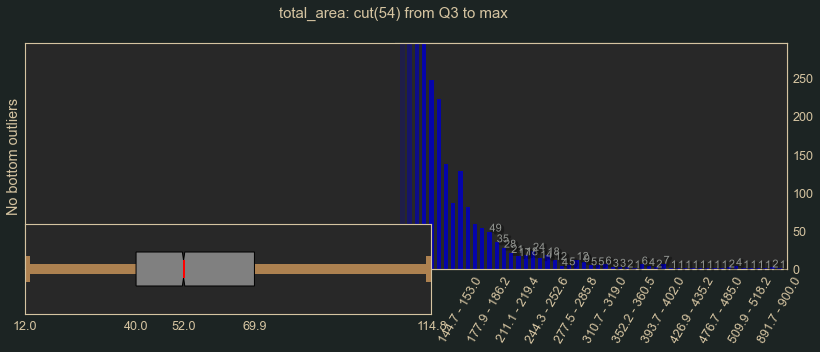

,total_rows,count,prc,min,max
top,23699,1240,5.23%,114.8,900
bottom,23699,0,0.00%,-,-




rooms                    > 3 rooms                   29.8% of all TOP outliers
rooms                    > 4 rooms                   31.2% of all TOP outliers
rooms                    > 5 rooms                   20.5% of all TOP outliers
rooms                    > other categories (5)     ~3.7% of all TOP outliers in each one

rooms                    > 5 rooms                   77.9% of rows are TOP outliers
rooms                    > 6-7 rooms                 93.9% of rows are TOP outliers
rooms                    > 8+ rooms                  100.0% of rows are TOP outliers

____________________________________________________________________________________________________

total_area_qcut_15       > (106.0, 900.0]            100.0% of all TOP outliers
total_area_qcut_15       > other categories (14)    ~0.0% of all TOP outliers in each one

total_area_qcut_15       > (106.0, 900.0]            79.0% of rows are TOP outliers

__________________________________________________________

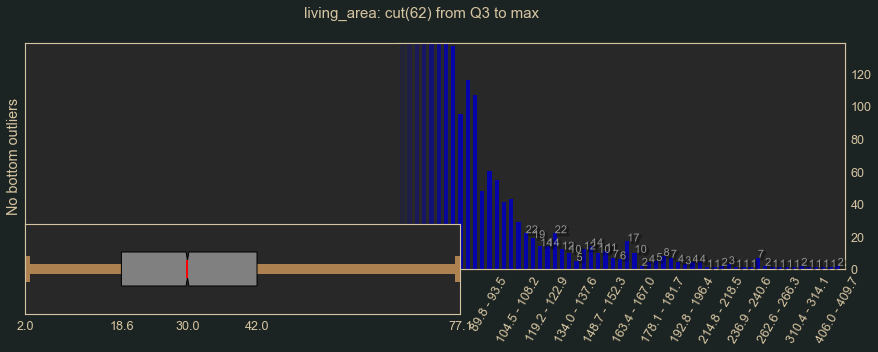

,total_rows,count,prc,min,max
top,23425,812,3.47%,77.2,409.7
bottom,23425,0,0.00%,-,-




rooms                    > 3 rooms                   16.4% of all TOP outliers
rooms                    > 4 rooms                   31.5% of all TOP outliers
rooms                    > 5 rooms                   30.2% of all TOP outliers
rooms                    > 6-7 rooms                 17.6% of all TOP outliers
rooms                    > other categories (4)     ~1.1% of all TOP outliers in each one

rooms                    > 5 rooms                   76.3% of rows are TOP outliers
rooms                    > 6-7 rooms                 94.1% of rows are TOP outliers
rooms                    > 8+ rooms                  100.0% of rows are TOP outliers

____________________________________________________________________________________________________

total_area_qcut_15       > (106.0, 900.0]            98.3% of all TOP outliers
total_area_qcut_15       > other categories (14)    ~0.1% of all TOP outliers in each one

total_area_qcut_15       > (106.0, 900.0]            55.5% of row

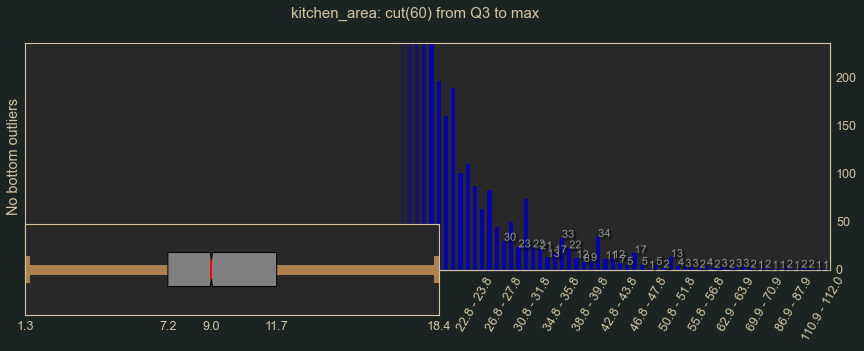

,total_rows,count,prc,min,max
top,23281,1370,5.88%,18.5,112
bottom,23281,0,0.00%,-,-




rooms                    > 2 rooms                   26.9% of all TOP outliers
rooms                    > 3 rooms                   34.6% of all TOP outliers
rooms                    > 4 rooms                   14.0% of all TOP outliers
rooms                    > other categories (5)     ~4.9% of all TOP outliers in each one

rooms                    > 6-7 rooms                 53.2% of rows are TOP outliers
rooms                    > 8+ rooms                  56.7% of rows are TOP outliers

____________________________________________________________________________________________________

total_area_qcut_15       > (75.0, 85.0]              9.6% of all TOP outliers
total_area_qcut_15       > (85.0, 106.0]             16.9% of all TOP outliers
total_area_qcut_15       > (106.0, 900.0]            49.0% of all TOP outliers
total_area_qcut_15       > other categories (12)    ~2.0% of all TOP outliers in each one


_______________________________________________________________________

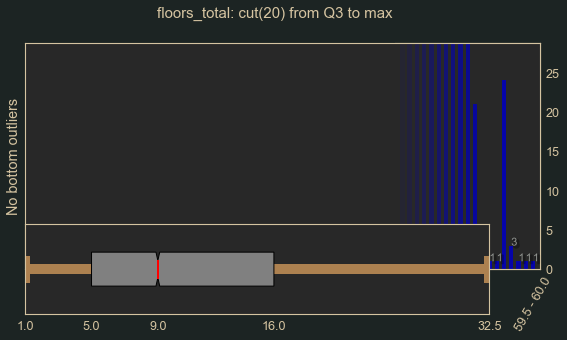

,total_rows,count,prc,min,max
top,23650,32,0.14%,33,60
bottom,23650,0,0.00%,-,-




rooms                    > 1 room                    28.1% of all TOP outliers
rooms                    > 2 rooms                   50.0% of all TOP outliers
rooms                    > 3 rooms                   15.6% of all TOP outliers
rooms                    > other categories (5)     ~1.2% of all TOP outliers in each one


____________________________________________________________________________________________________

total_area_qcut_15       > (11.999, 31.3]            9.4% of all TOP outliers
total_area_qcut_15       > (46.0, 50.0]              9.4% of all TOP outliers
total_area_qcut_15       > (50.0, 54.0]              12.5% of all TOP outliers
total_area_qcut_15       > (67.9, 75.0]              28.1% of all TOP outliers
total_area_qcut_15       > (85.0, 106.0]             9.4% of all TOP outliers
total_area_qcut_15       > other categories (10)    ~3.1% of all TOP outliers in each one


___________________________________________________________________________________

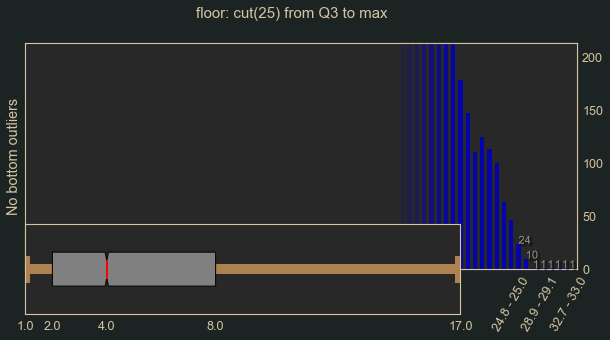

,total_rows,count,prc,min,max
top,23699,922,3.89%,18,33
bottom,23699,0,0.00%,-,-




rooms                    > 1 room                    49.9% of all TOP outliers
rooms                    > 2 rooms                   29.1% of all TOP outliers
rooms                    > 3 rooms                   15.9% of all TOP outliers
rooms                    > other categories (5)     ~1.0% of all TOP outliers in each one


____________________________________________________________________________________________________

total_area_qcut_15       > (31.3, 34.5]              8.1% of all TOP outliers
total_area_qcut_15       > (34.5, 37.6]              12.3% of all TOP outliers
total_area_qcut_15       > (37.6, 41.0]              11.9% of all TOP outliers
total_area_qcut_15       > (62.0, 67.9]              8.1% of all TOP outliers
total_area_qcut_15       > other categories (11)    ~5.4% of all TOP outliers in each one


____________________________________________________________________________________________________

living_area_qcut_15      > (1.999, 16.0]             19.3% 

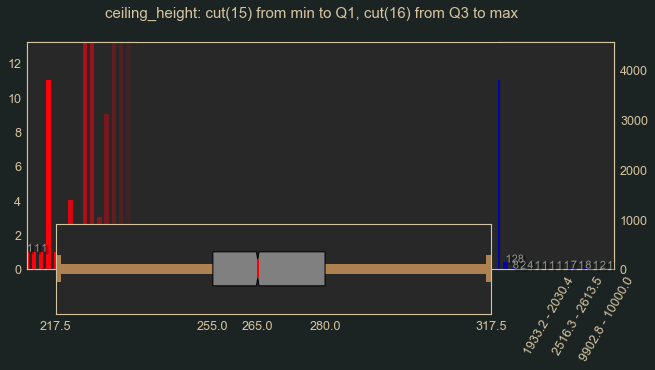

,total_rows,count,prc,min,max
top,19416,1105,5.69%,318,10000
bottom,19416,14,0.07%,100,200




rooms                    > 2 rooms                   25.2% of all TOP outliers
rooms                    > 3 rooms                   31.1% of all TOP outliers
rooms                    > 4 rooms                   16.4% of all TOP outliers
rooms                    > other categories (5)     ~5.5% of all TOP outliers in each one


rooms                    > 1 room                    50.0% of all BOTTOM outliers
rooms                    > 2 rooms                   28.6% of all BOTTOM outliers
rooms                    > 3 rooms                   21.4% of all BOTTOM outliers
rooms                    > other categories (5)     ~0.0% of all BOTTOM outliers in each one

____________________________________________________________________________________________________

total_area_qcut_15       > (67.9, 75.0]              9.4% of all TOP outliers
total_area_qcut_15       > (75.0, 85.0]              10.8% of all TOP outliers
total_area_qcut_15       > (85.0, 106.0]             16.9% of all TOP 

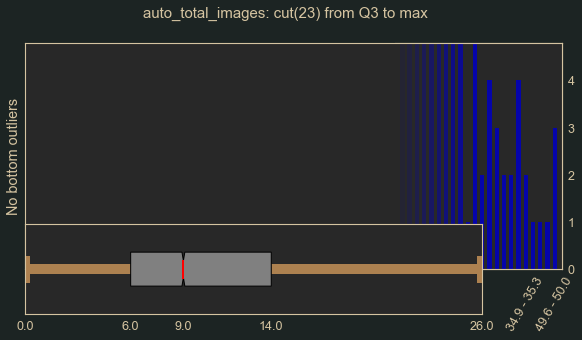

,total_rows,count,prc,min,max
top,23699,25,0.11%,27,50
bottom,23699,0,0.00%,-,-




rooms                    > 3 rooms                   60.0% of all TOP outliers
rooms                    > 4 rooms                   20.0% of all TOP outliers
rooms                    > other categories (6)     ~3.3% of all TOP outliers in each one


____________________________________________________________________________________________________

total_area_qcut_15       > (58.0, 62.0]              8.0% of all TOP outliers
total_area_qcut_15       > (62.0, 67.9]              8.0% of all TOP outliers
total_area_qcut_15       > (67.9, 75.0]              8.0% of all TOP outliers
total_area_qcut_15       > (75.0, 85.0]              16.0% of all TOP outliers
total_area_qcut_15       > (85.0, 106.0]             24.0% of all TOP outliers
total_area_qcut_15       > (106.0, 900.0]            28.0% of all TOP outliers
total_area_qcut_15       > other categories (9)     ~0.9% of all TOP outliers in each one


___________________________________________________________________________________

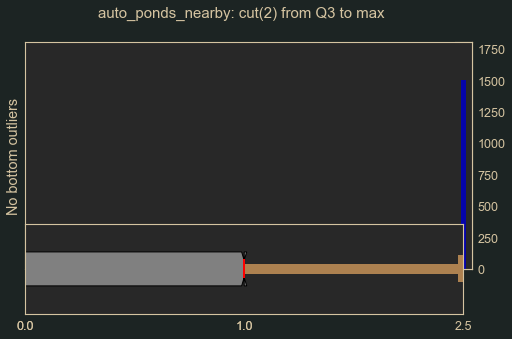

,total_rows,count,prc,min,max
top,18181,1501,8.26%,3,3
bottom,18181,0,0.00%,-,-




rooms                    > 1 room                    22.2% of all TOP outliers
rooms                    > 2 rooms                   33.7% of all TOP outliers
rooms                    > 3 rooms                   28.4% of all TOP outliers
rooms                    > other categories (5)     ~3.1% of all TOP outliers in each one


____________________________________________________________________________________________________

total_area_qcut_15       > (67.9, 75.0]              11.2% of all TOP outliers
total_area_qcut_15       > (75.0, 85.0]              9.7% of all TOP outliers
total_area_qcut_15       > (85.0, 106.0]             13.2% of all TOP outliers
total_area_qcut_15       > (106.0, 900.0]            19.1% of all TOP outliers
total_area_qcut_15       > other categories (11)    ~4.3% of all TOP outliers in each one


____________________________________________________________________________________________________

living_area_qcut_15      > (19.0, 22.0]              7.0% 

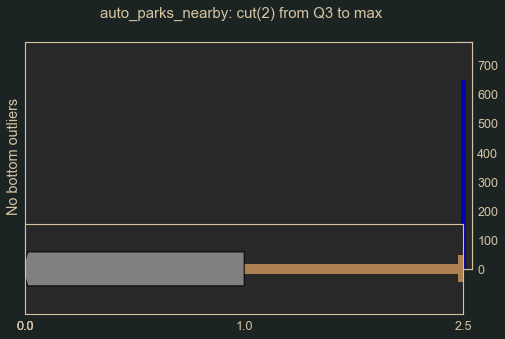

,total_rows,count,prc,min,max
top,18181,647,3.56%,3,3
bottom,18181,0,0.00%,-,-




rooms                    > 1 room                    21.6% of all TOP outliers
rooms                    > 2 rooms                   31.1% of all TOP outliers
rooms                    > 3 rooms                   24.9% of all TOP outliers
rooms                    > other categories (5)     ~4.5% of all TOP outliers in each one


____________________________________________________________________________________________________

total_area_qcut_15       > (85.0, 106.0]             12.7% of all TOP outliers
total_area_qcut_15       > (106.0, 900.0]            24.1% of all TOP outliers
total_area_qcut_15       > other categories (13)    ~4.9% of all TOP outliers in each one


____________________________________________________________________________________________________

living_area_qcut_15      > (44.7, 50.0]              7.9% of all TOP outliers
living_area_qcut_15      > (50.0, 61.7]              10.5% of all TOP outliers
living_area_qcut_15      > (61.7, 409.7]             26.0%

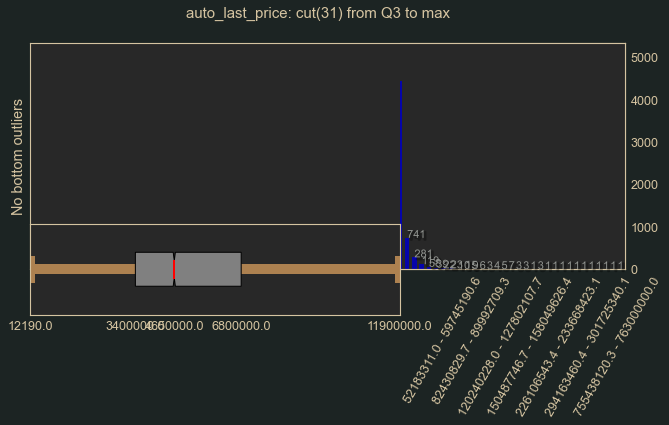

,total_rows,count,prc,min,max
top,23699,2034,8.58%,11935000,763000000
bottom,23699,0,0.00%,-,-




rooms                    > 2 rooms                   16.4% of all TOP outliers
rooms                    > 3 rooms                   42.1% of all TOP outliers
rooms                    > 4 rooms                   20.5% of all TOP outliers
rooms                    > other categories (5)     ~4.2% of all TOP outliers in each one

rooms                    > 5 rooms                   63.5% of rows are TOP outliers
rooms                    > 6-7 rooms                 89.6% of rows are TOP outliers
rooms                    > 8+ rooms                  100.0% of rows are TOP outliers

____________________________________________________________________________________________________

total_area_qcut_15       > (75.0, 85.0]              7.9% of all TOP outliers
total_area_qcut_15       > (85.0, 106.0]             23.5% of all TOP outliers
total_area_qcut_15       > (106.0, 900.0]            61.6% of all TOP outliers
total_area_qcut_15       > other categories (12)    ~0.6% of all TOP outliers 

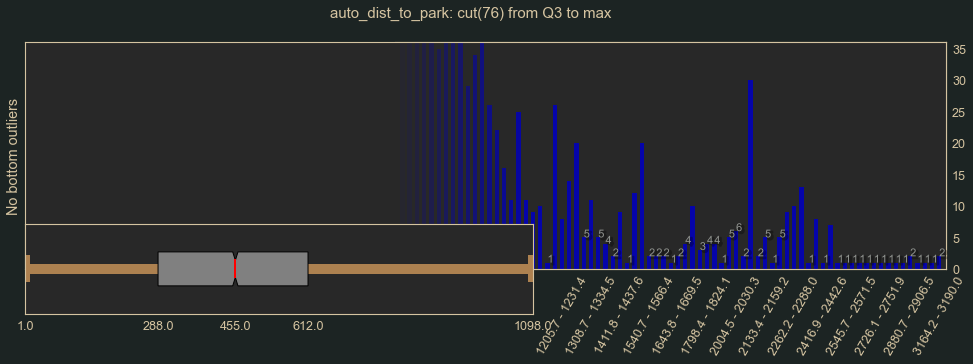

,total_rows,count,prc,min,max
top,8079,314,3.89%,1103,3190
bottom,8079,0,0.00%,-,-




rooms                    > 1 room                    36.6% of all TOP outliers
rooms                    > 2 rooms                   32.2% of all TOP outliers
rooms                    > 3 rooms                   22.6% of all TOP outliers
rooms                    > other categories (5)     ~1.7% of all TOP outliers in each one


____________________________________________________________________________________________________

total_area_qcut_15       > (37.6, 41.0]              7.6% of all TOP outliers
total_area_qcut_15       > (41.0, 43.6]              7.6% of all TOP outliers
total_area_qcut_15       > (67.9, 75.0]              9.9% of all TOP outliers
total_area_qcut_15       > (75.0, 85.0]              9.6% of all TOP outliers
total_area_qcut_15       > (85.0, 106.0]             11.5% of all TOP outliers
total_area_qcut_15       > (106.0, 900.0]            11.1% of all TOP outliers
total_area_qcut_15       > other categories (9)     ~4.7% of all TOP outliers in each one


_____

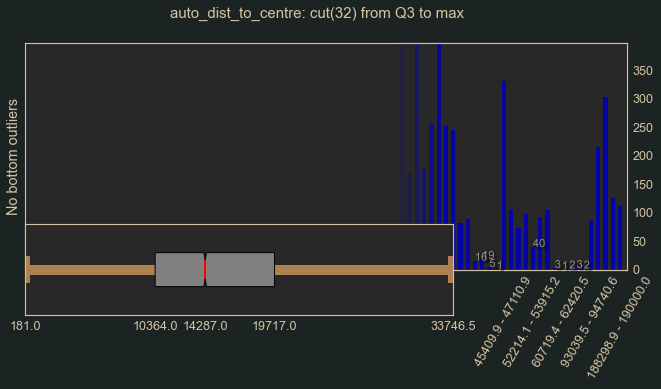

,total_rows,count,prc,min,max
top,21433,2124,9.91%,33752,190000
bottom,21433,0,0.00%,-,-




rooms                    > 1 room                    31.6% of all TOP outliers
rooms                    > 2 rooms                   39.5% of all TOP outliers
rooms                    > 3 rooms                   24.5% of all TOP outliers
rooms                    > other categories (5)     ~0.9% of all TOP outliers in each one


____________________________________________________________________________________________________

total_area_qcut_15       > (11.999, 31.3]            9.2% of all TOP outliers
total_area_qcut_15       > (31.3, 34.5]              7.5% of all TOP outliers
total_area_qcut_15       > (43.6, 46.0]              8.9% of all TOP outliers
total_area_qcut_15       > (46.0, 50.0]              7.6% of all TOP outliers
total_area_qcut_15       > (50.0, 54.0]              7.6% of all TOP outliers
total_area_qcut_15       > (54.0, 58.0]              8.2% of all TOP outliers
total_area_qcut_15       > (58.0, 62.0]              7.8% of all TOP outliers
total_area_qcut_15   

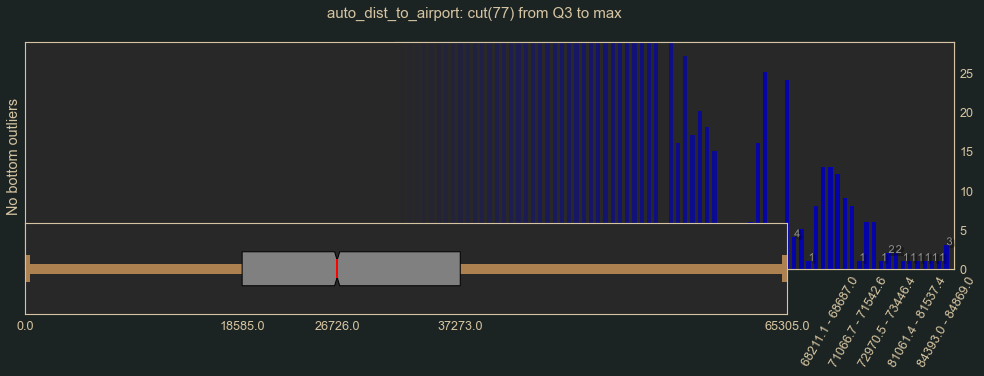

,total_rows,count,prc,min,max
top,18157,103,0.57%,65328,84869
bottom,18157,0,0.00%,-,-




rooms                    > 1 room                    35.9% of all TOP outliers
rooms                    > 2 rooms                   42.7% of all TOP outliers
rooms                    > 3 rooms                   16.5% of all TOP outliers
rooms                    > other categories (5)     ~1.0% of all TOP outliers in each one


____________________________________________________________________________________________________

total_area_qcut_15       > (11.999, 31.3]            15.5% of all TOP outliers
total_area_qcut_15       > (41.0, 43.6]              7.8% of all TOP outliers
total_area_qcut_15       > (46.0, 50.0]              10.7% of all TOP outliers
total_area_qcut_15       > (50.0, 54.0]              7.8% of all TOP outliers
total_area_qcut_15       > (67.9, 75.0]              7.8% of all TOP outliers
total_area_qcut_15       > other categories (10)    ~5.0% of all TOP outliers in each one


___________________________________________________________________________________

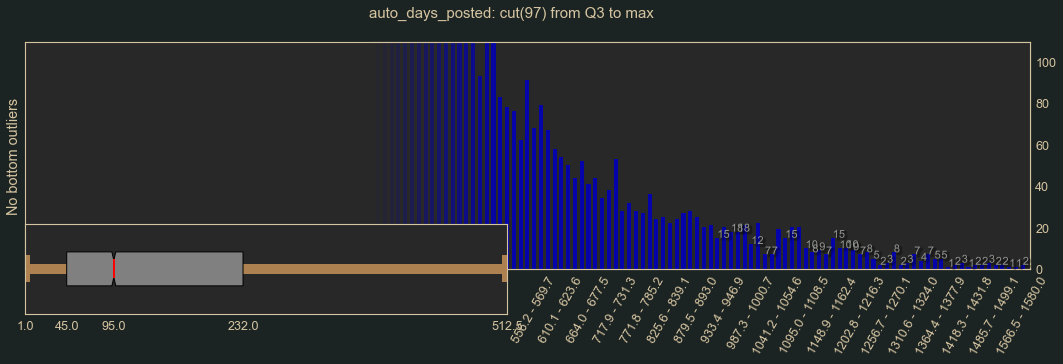

,total_rows,count,prc,min,max
top,20518,1669,8.13%,513,1580
bottom,20518,0,0.00%,-,-




rooms                    > 1 room                    28.4% of all TOP outliers
rooms                    > 2 rooms                   30.0% of all TOP outliers
rooms                    > 3 rooms                   28.5% of all TOP outliers
rooms                    > other categories (5)     ~2.6% of all TOP outliers in each one


____________________________________________________________________________________________________

total_area_qcut_15       > (85.0, 106.0]             10.7% of all TOP outliers
total_area_qcut_15       > (106.0, 900.0]            13.2% of all TOP outliers
total_area_qcut_15       > other categories (13)    ~5.9% of all TOP outliers in each one


____________________________________________________________________________________________________

living_area_qcut_15      > (1.999, 16.0]             7.6% of all TOP outliers
living_area_qcut_15      > (44.7, 50.0]              8.0% of all TOP outliers
living_area_qcut_15      > (50.0, 61.7]              9.2% o

In [76]:
outliers_investigation(exclude_cat = 'auto_locality_name')

- **'_area', '_price' и '_images' columns** - распределение нормальное. Рынок недвижимости разнообразен - большинство объясвлений нацелены на среднего покупателя, но и "хвосты" у распределения толстые - предложение элит-класса тоже большое (1-2 тысячи значений выше 1.5 iqr). Похоже, что в этих столбцах мы рассматриваем одни и те же строчки: к примеру, возьмём выбросы 'kitchen_area'. Большая часть лежит в наивысших интервалах столбцов '_area', в ближайших к центру города интервалах столбца 'dist_to_centre', в наивысших интервалах по цене, но точно так же и наоборот! Выбросы в этих колонках объединяет один любопытный момент: объявления, стоящие за ними, как правило сопровождаются большим числом фотографий. Нет причины выкидывать эти значения из анализа. 
- **'floors_total' и 'floor'** В этих столбцах легко проверить аномалии: в Санкт-Петербурге нет жилых зданий выше 37 этажей. 37-этажное здание находится на расстоянии 19 километров от центра города. И в самом деле, все выбросы в этих двух столбцах лежат на расстоянии 18-22 км от центра города, часть из них - наверняка из этого здания. Максимальное значение в столбце 'floor' - 33 этаж. По крайней мере, нужно отбросить все несуществующие этажи выше 37го. Если возникнет необходимость глубоко поработать со столбцами 'floors_total' и 'floor', можно будет рассмотреть случаи, когда этажей указано больше тридцати - таких зданий в Санкт-Петербурге не очень много.
- **disances to parks & ponds** Три парка или водоёма на расстоянии до трёх километров - и ты выходишь за границы полутора межквартильных размахов, потому что Q1 - ноль, а Q3 - один. Тем ни менее, ничего необычного в том, чтобы иметь три парка рядом, нет, тем более для тех, кто живёт в центре города - а таких, как мы видим, среди рассматриваемых случаев большинство.
- **distances to centre & airport** 190км, максимальное расстояние- это то же самое, что расстояние от Санкт-Петербурга до Великого Новгорода. Некоторые из этих значений, я помню, мы сами вносили: до Выборга, Приозерска, Кингисеппа. Но границей Санкт-Петербурга, как мысленной, так и, в конце концов, официальной считаются Павловск, Колпино, Сертолово - населённые пункты, лежащие на расстоянии приблизительно 40км до центра города. За ними начинается Ленинградская область со своим рынком недвижимости. Расстояние до аэропорта из самой далёкой точке в черте города - 60 км. Большие значения, очевидно, относятся к объявленим из Ленобласти. Заменяем на 'unknown' то что не имеет отношения к Санкт-Петербургу.
- **days posted** - здесь нормальное распределение. большинство выбросов - объявления, опубликованные в 2014, 2015 и 2016 годах, объявления откуда-то из далёкой от центра города глубинки (категория -777777) и объявления с высокой ценой. Все логично, оставляем как есть.
- **'ceiling_height'**  Судя по всему, одинаковые значения, пришедшие наверняка из спальных районых, заполонили столбец и вылились в то, что значение межквартильного размаха сильно прижато к медиане - и мы получили огромное количество выбросов, ничем не примечательных: ниже 2.17 метров и выше 3.17 метров. По гистограмме видно, что резкое падение частотности, которое обычно и отделяет выбросы от регулярных значений происходит дальше. Значит, для этого столбца надо отдельно уточнить параметр `whiskers`.

Processing 1 out of 1: ceiling_height...


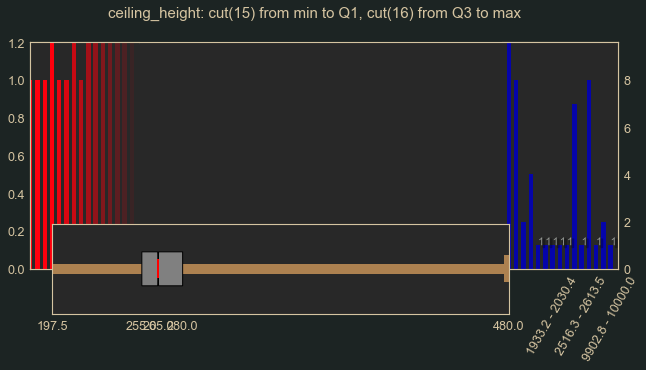

,total_rows,count,prc,min,max
top,19416,38,0.20%,490,10000
bottom,19416,3,0.02%,100,175




rooms                    > 1 room                    28.9% of all TOP outliers
rooms                    > 2 rooms                   34.2% of all TOP outliers
rooms                    > 3 rooms                   15.8% of all TOP outliers
rooms                    > other categories (5)     ~4.2% of all TOP outliers in each one


rooms                    > 1 room                    33.3% of all BOTTOM outliers
rooms                    > 2 rooms                   66.7% of all BOTTOM outliers
rooms                    > other categories (6)     ~0.0% of all BOTTOM outliers in each one

____________________________________________________________________________________________________

total_area_qcut_15       > (11.999, 31.3]            13.2% of all TOP outliers
total_area_qcut_15       > (41.0, 43.6]              7.9% of all TOP outliers
total_area_qcut_15       > (43.6, 46.0]              15.8% of all TOP outliers
total_area_qcut_15       > (54.0, 58.0]              10.5% of all TOP out

In [77]:
outliers_investigation(include = 'ceiling_height', 
                       top_whisker = 8, bot_whisker = 2.3, 
                       exclude_cat = 'auto_locality_name')

Мы сильно сократили число выбросов, и теперь получили такие данные, которые на самом деле выглядят странно. Потолки ниже 1.9 и выше 4.8 это само по себе странно, но тут ещё эти аномальные значения без какого-либо порядка распределены по разным категориям в других столбцах. Это приводит меня к мысли, что здесь наверняка какая-то ошибка, и эти значения лучше удалить - тем более, их всего 42 штуки.


С помощью стандартного 1.5 межквартильного размаха удалось поймать верхние выбросы, но были ещё и нижние, которые охватить не удалось: например, 2м$^2$ жилой площади, 12000₽ цена за квартиру и 0km расстояние до аэропорта, хотя рядом с аэропортом никто не живёт. Сделаем теперь так, чтобы видеть нижние выбросы и не видеть верхние.

Processing 1 out of 4: total_area...


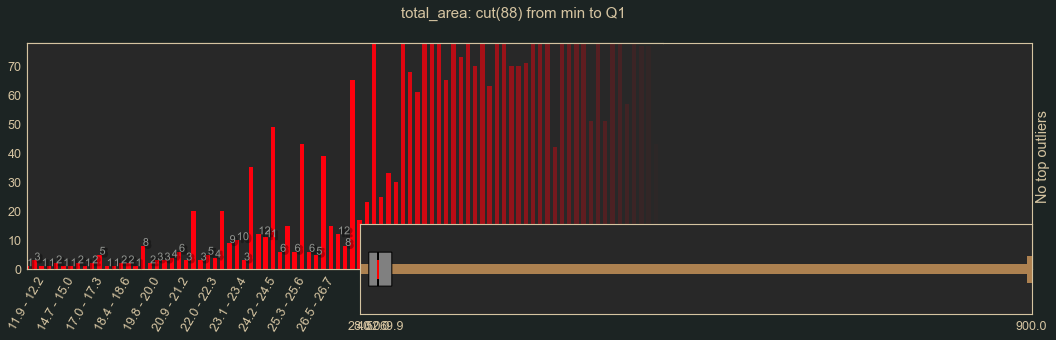

,total_rows,count,prc,min,max
top,23699,0,0.00%,-,-
bottom,23699,450,1.90%,12,28





rooms                    > 0 rooms                   31.8% of all BOTTOM outliers
rooms                    > 1 room                    67.3% of all BOTTOM outliers
rooms                    > other categories (6)     ~0.1% of all BOTTOM outliers in each one

rooms                    > 0 rooms                   72.6% of rows are BOTTOM outliers
____________________________________________________________________________________________________


auto_locality_name       > Кудрово                   9.8% of all BOTTOM outliers
auto_locality_name       > Мурино                    15.8% of all BOTTOM outliers
auto_locality_name       > Санкт-Петербург           51.3% of all BOTTOM outliers
auto_locality_name       > other categories (295)   ~0.1% of all BOTTOM outliers in each one

auto_locality_name       > деревня Рапполово         100.0% of rows are BOTTOM outliers
auto_locality_name       > поселок станции Корнево   100.0% of rows are BOTTOM outliers
auto_locality_name       > посёлок

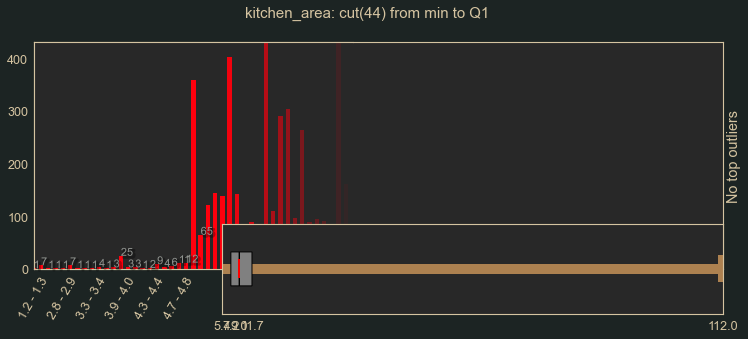

,total_rows,count,prc,min,max
top,23281,0,0.00%,-,-
bottom,23281,794,3.41%,1.3,5.3





rooms                    > 1 room                    28.8% of all BOTTOM outliers
rooms                    > 2 rooms                   41.8% of all BOTTOM outliers
rooms                    > 3 rooms                   23.4% of all BOTTOM outliers
rooms                    > other categories (5)     ~1.2% of all BOTTOM outliers in each one

____________________________________________________________________________________________________


auto_locality_name       > Гатчина                   4.9% of all BOTTOM outliers
auto_locality_name       > Ломоносов                 3.3% of all BOTTOM outliers
auto_locality_name       > Петергоф                  3.4% of all BOTTOM outliers
auto_locality_name       > Пушкин                    5.5% of all BOTTOM outliers
auto_locality_name       > Санкт-Петербург           43.5% of all BOTTOM outliers
auto_locality_name       > other categories (293)   ~0.1% of all BOTTOM outliers in each one

auto_locality_name       > поселок Кирпичное         1

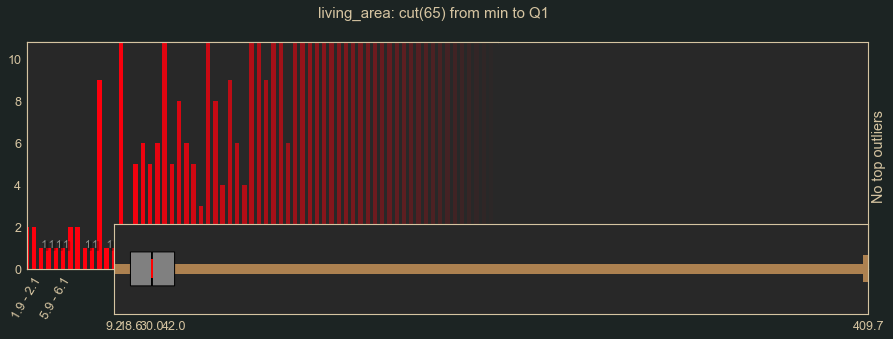

,total_rows,count,prc,min,max
top,23425,0,0.00%,-,-
bottom,23425,24,0.10%,2,9.1





rooms                    > 1 room                    54.2% of all BOTTOM outliers
rooms                    > 2 rooms                   29.2% of all BOTTOM outliers
rooms                    > other categories (6)     ~2.8% of all BOTTOM outliers in each one

____________________________________________________________________________________________________


auto_locality_name       > Мурино                    4.2% of all BOTTOM outliers
auto_locality_name       > Санкт-Петербург           91.7% of all BOTTOM outliers
auto_locality_name       > посёлок Шушары            4.2% of all BOTTOM outliers
auto_locality_name       > other categories (295)   ~0.0% of all BOTTOM outliers in each one

____________________________________________________________________________________________________


total_area_qcut_15       > (11.999, 31.3]            25.0% of all BOTTOM outliers
total_area_qcut_15       > (31.3, 34.5]              20.8% of all BOTTOM outliers
total_area_qcut_15       > (34.

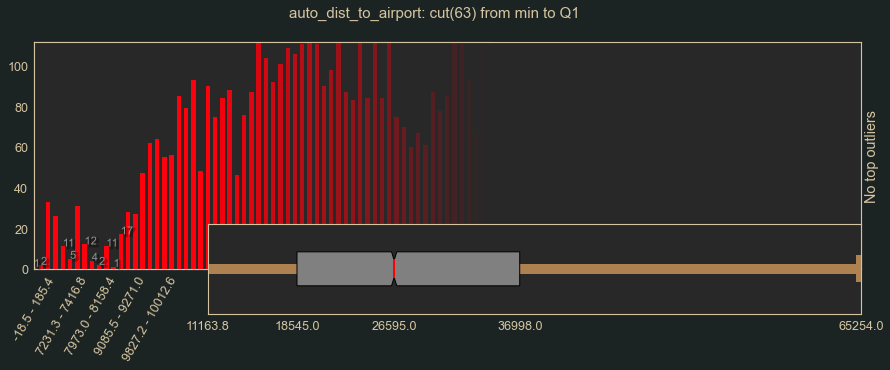

,total_rows,count,prc,min,max
top,18054,0,0.00%,-,-
bottom,18054,761,4.22%,0,11151





rooms                    > 1 room                    37.8% of all BOTTOM outliers
rooms                    > 2 rooms                   34.7% of all BOTTOM outliers
rooms                    > 3 rooms                   21.3% of all BOTTOM outliers
rooms                    > other categories (5)     ~1.2% of all BOTTOM outliers in each one

____________________________________________________________________________________________________


auto_locality_name       > Санкт-Петербург           97.8% of all BOTTOM outliers
auto_locality_name       > other categories (297)   ~0.0% of all BOTTOM outliers in each one

____________________________________________________________________________________________________


total_area_qcut_15       > (11.999, 31.3]            10.8% of all BOTTOM outliers
total_area_qcut_15       > (37.6, 41.0]              9.9% of all BOTTOM outliers
total_area_qcut_15       > (41.0, 43.6]              8.3% of all BOTTOM outliers
total_area_qcut_15       > (43.

In [78]:
outliers_investigation(include = 'total_area kitchen_area living_area auto_dist_to_airport', 
                       bot_whisker = 0.4, top_whisker = 30)

Получаетсся, что не только верхние, но и нижние выбросы столбцов '_area' в целом соотносятся друг с другом. Они одинаково распределены по тем категориям, в которых мы и ожидаем их увидеть: 0 или 1 комната, расположение за пределами СПб, студия или свободная планировка (видно по значениям zero в 'kitchen_area', далеко до центра и так далее. Однако это не правило: встречаются и труднообъяснимые вещи, как, например, 12% 3-5м$^2$ кухонь в квартирах 37-41м$^2$ площадью.

Воо всех столбцах первый пик (9+ значений) приходится после нескольких единичных аномалий. Возможно, в этом месте в самом деле появляется какое-то жильё супер-эконом класса, откуда на платформу поступило 9 объявлений о продаже. В пользу этого говорит то, что этот пик случается на такихзначениях оси х, которые уже не кажутся сильно невозможными: 17м$^2$ для 'total_area', 3.5м$^2$ для 'kitchen_area' и 7м$^2$ для 'living_area'. Думаю, что по границе этого пика можно отделить аномалии от допустимых выбросов.

Строчки с нижними выбросами в столбце 'auto_dist_to_airport' (неправдоподобно небольшое расстояние до аэропортое) в ячейках 'distance_to_centre' содержат значение 12-14 км до центра города. Даже если считать Обводный Канал центром, а не границей центра, его отделяет от аэропорта 18км. Это значит, что в нашем датасете никак не может быть объявления с расстоянием до аэропорта менее 4км (18км - 14км), которое было бы правдивым (безошибочным).

Processing 1 out of 1: auto_last_price...


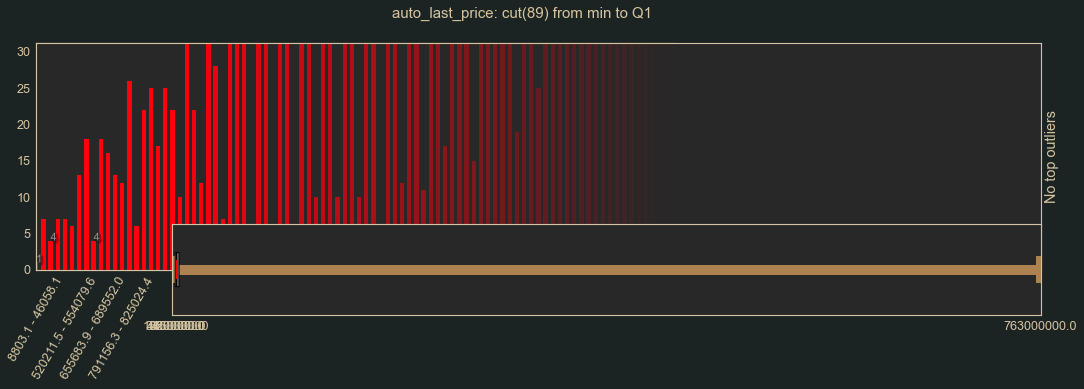

,total_rows,count,prc,min,max
top,23699,0,0.00%,-,-
bottom,23699,246,1.04%,12190,1010000





rooms                    > 1 room                    45.5% of all BOTTOM outliers
rooms                    > 2 rooms                   40.2% of all BOTTOM outliers
rooms                    > other categories (6)     ~2.4% of all BOTTOM outliers in each one

____________________________________________________________________________________________________


auto_locality_name       > Бокситогорск              5.7% of all BOTTOM outliers
auto_locality_name       > Пикалёво                  5.3% of all BOTTOM outliers
auto_locality_name       > Сланцы                    35.4% of all BOTTOM outliers
auto_locality_name       > other categories (295)   ~0.2% of all BOTTOM outliers in each one

auto_locality_name       > Бокситогорск              87.5% of rows are BOTTOM outliers
auto_locality_name       > Пикалёво                  72.2% of rows are BOTTOM outliers
auto_locality_name       > Сланцы                    77.7% of rows are BOTTOM outliers
auto_locality_name       > деревня Бо

In [79]:
outliers_investigation('auto_last_price', bot_whisker = 0.7, top_whisker = 1000)

Нижние выбросы в столбце 'auto_last_price' совершенно не встречатся в объявлениях из Санкт-Петербурга или даже из близлежащих к нему населённых пунктов. Объявления из Ленобласти в одном месте мы уже удалили - сейчас их требуется удалить во втором, либо же удалить все строки полностью, коль скоро мы не собираемся брать их в расчёт. В противном случае значения из этих строк так или иначе попадут на графики.

In [80]:
print('Rows before: ', df.shape[0], end = '. ')
df = df.drop(df[ df['auto_dist_to_centre'] == unknown ].index, axis = 0)
print('Rows after: ', df.shape[0])

Rows before:  23699. Rows after:  22001


На самом деле, не так много их, к счастью, оказалось. Нужно обратить внимание, что мы не выбросили все строки, в которых содержится неизвестное нам значение, а только те, в которых стоит 'unknown'. Остальные мы при работе с пропусками заполнили значением 'zero'.

## Рассчитываем метрики

Осталось добавить несколько элементарных метрик: 
- **'price_psm'** - цена за квадратный метр
- **'weekday'** - день недели, когда было опубликовано объявление
- **'month'** - месяц, когда было опубликовано объявление
- **'year'** - год, когда было опубликовано объявление
- **'floor'** - этаж является первым, последним или располагается между первым и последним
- **'liv_ratio'** - отношение жилой площади к общей
- **'kit_ratio'** - отношение площади кухни к общей

In [81]:
def floor_location(row):
    floor = row['floor']
    if floor == 1:
        return 'first'
    elif floor == row['floors_total']:
        return 'last'
    else:
        return 'in-between' 

df['price_psm'] = df['auto_last_price'].div(df['total_area']).round(0)
df['price_psm'] = pd.to_numeric(df['price_psm'], downcast = 'signed')
df['price_psm_qcut_50'] = pd.qcut(df['price_psm'], 50)
df['weekday'] = df['auto_first_day'].dt.weekday
df['month'] = df['auto_first_day'].dt.month
df['year'] = df['auto_first_day'].dt.year
df['floor_loc'] = df.apply(floor_location, axis = 1).astype('category')
df['liv_ratio'] = df['living_area'].div(df['total_area']).apply(lambda x: unknown if (x < 0) else x).round(2)
df['kit_ratio'] = df['kitchen_area'].div(df['total_area']).apply(lambda x: unknown if (x < 0) else x).round(2)

display(df.iloc[:, -8:].head())

,price_psm,price_psm_qcut_50,weekday,month,year,floor_loc,liv_ratio,kit_ratio
0,120370,"(119608.0, 122137.0]",3,3,2019,in-between,0.47,0.23
1,82921,"(82781.0, 84259.0]",1,12,2018,first,0.46,0.27
2,92786,"(92188.0, 93458.0]",3,8,2015,in-between,0.61,0.15
3,408176,"(211250.0, 1907500.0]",4,7,2015,in-between,-777777.00,-777777.00
4,100000,"(99778.0, 100673.0]",1,6,2018,in-between,0.32,0.41


Предобработка было долгой, и хочется избавиться от множества переменных, которые по ходу дела были созданы. Это не вопрос жизни и смерти, но это полезно с точки зрения использования памяти и, тем более, дарит чувство 'c чистого листа'.

In [82]:
def wipe_globals(*but_keep_those):
    """
    Функция выполняет магические команды %reset_selective и %xdel, 
    очищая память ото всех глобальных переменных, кроме тех, которые
    отсылают к основным рабочим библиотекам и тех, которые присутствуют 
    в памяти сразу после запуска. Функция примет любое количество 
    строк с именами - объекты под этими именами будут защищены от удаления.
    Себя также не удаляет.
    """
    import re
    from IPython import get_ipython
    from gc import collect
    
    keep_those_too = '_(i|o|d|n)(1|h|i|m)?(i|s)?$|re$|tf$|path_effects$|quit$|exit$|jtplot$|wipe_globals$|sns$|sklearn$|scipy.fftpack$|req$|mlines$|robjects$|nltk$|get_ipython$|__.*$|NamespaceMagics$|_Jupyter$|json$|getsizeof$|var_dic_list$|_$|__$|np$|mm$|pd$|plt$|In$|Out$).*'
    regex_filter = ('^(?!' 
                    + ''.join([f'{x}$|' for x in but_keep_those]) 
                    + ''.join([f'{x}$|' for x in list(locals())]) 
                    + keep_those_too)
    
    already_removed = []
    for x in globals().copy():
        if x in already_removed:
            continue
        if re.match(regex_filter, x):
            try:
                get_ipython().run_line_magic('xdel', x)
                already_removed.append(x)
            except:
                pass
    
    get_ipython().run_line_magic('reset_selective', regex_filter)
    collect()
    
    print('Global namespace has been cleared')
    return

In [83]:
wipe_globals('df')

NameError: name '_24' is not defined
NameError: name '_25' is not defined
NameError: name 'ax' is not defined
NameError: name 'table' is not defined
NameError: name '_70' is not defined
Once deleted, variables cannot be recovered. Proceed (y/[n])?  y
Global namespace has been cleared


# Отвечаем на вопросы

Пригород можно определить двумя способами. Можно отнести к пригородам те объявления, у которых в 'auto_locality_name' значения, отличающиеся от "Санкт-Петербург", а можно определить как пригород ту область, за пределами которой метрики либо резко идут вверх (пригород переходит в окраину города), либо идут вниз (город заканчивается). Также, то есть двумя способами, можно было бы определить и окраину города, если бы в датасете был столбец с названием района. Но его нет, поэтому окраину нужно будет опредлить так, как её определяет рынок - по изменению рыночных показателей. Но пока этого не требуется, просто отделим пригороды от самого города и не будем их смешивать, чтобы не получать усреднённый результат, который не будет достаточно точен ни относительно города, ни пригорода.
<a id='target6'></a>

In [84]:
spb_df = df[ df['auto_locality_name'] == 'Санкт-Петербург' ]
out_df = df[ df['auto_locality_name'] != 'Санкт-Петербург' ]

## Зависимость цены за квадратный метр от переменных с ограниченным числом значений

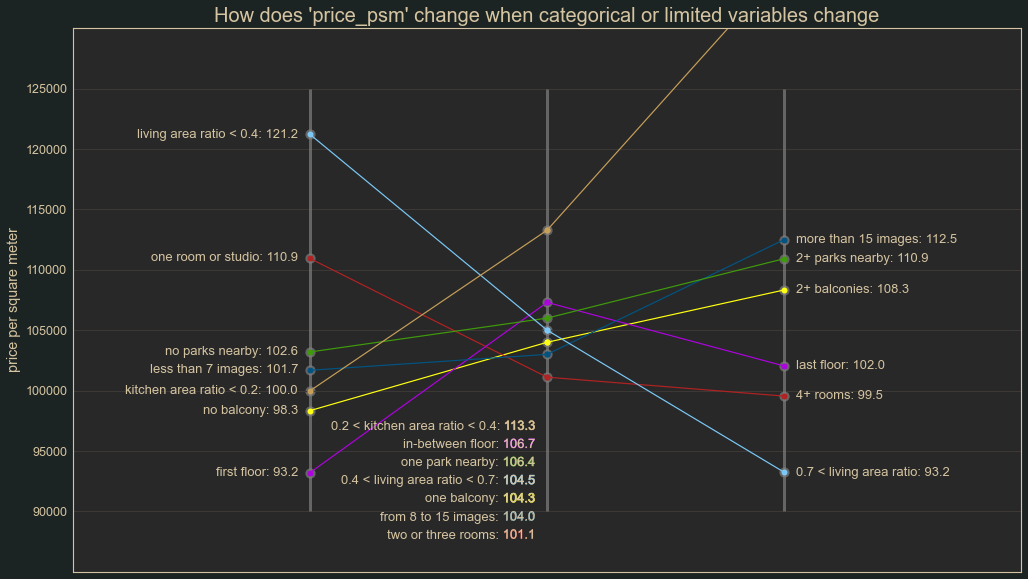

In [85]:
def distributing(groupby_object):
    global fir_df
    global sec_df
    global thi_df
    fir_df = fir_df.append(pd.Series(groupby_object.iloc[0, 0]), ignore_index = True)
    sec_df = sec_df.append(pd.Series(groupby_object.iloc[1, 0]), ignore_index = True)
    thi_df = thi_df.append(pd.Series(groupby_object.iloc[2, 0]), ignore_index = True)
    
def rooms_grouped(value):
    if value == '1 room' or value == '0 rooms':
        return 1
    elif value == '2 rooms' or value == '3 rooms':
        return 2
    else:
        return 3
    
def draw_a_line(xy_one, xy_another):
    import matplotlib.lines as mlines
    ax = plt.gca()
    line = mlines.Line2D([xy_one[0], xy_another[0]], [xy_one[1], xy_another[1]], 
                         marker = 'o', markersize = 6)
    ax.add_line(line)
    return line

fir_df = pd.Series(dtype = 'float')
sec_df = pd.Series(dtype = 'float') 
thi_df = pd.Series(dtype = 'float') 

distributing(spb_df.groupby(pd.cut(spb_df['balcony'], [-0.1, 0.9, 1.9, 100])).agg({'price_psm': 'median'}))
distributing(spb_df.groupby(spb_df['rooms'].apply(rooms_grouped)).agg({'price_psm': 'median'}))
distributing(spb_df.groupby(spb_df['floor_loc']).agg({'price_psm': 'median'}).sort_index())
    # sorting indexes by ascii alphabetical order will give us what we need: First < In-between < Last
distributing(spb_df.groupby(pd.cut(spb_df['auto_total_images'], [-0.1, 7.1, 15.1, 100])).agg({'price_psm': 'median'}))
distributing(spb_df.groupby(pd.cut(spb_df['auto_parks_nearby'], [-0.1, 0.9, 1.9, 100])).agg({'price_psm': 'median'}))
distributing(spb_df.groupby(pd.cut(spb_df['liv_ratio'], [-0.1, 0.4, 0.7, 100])).agg({'price_psm': 'median'}))
distributing(spb_df.groupby(pd.cut(spb_df['kit_ratio'], [-0.1, 0.2, 0.4, 100])).agg({'price_psm': 'median'}))

fir_labels = ['no balcony', 'one room or studio', 'first floor', 'less than 7 images', 'no parks nearby', 
              'living area ratio < 0.4', 'kitchen area ratio < 0.2' ]
sec_labels = ['one balcony', 'two or three rooms', 'in-between floor', 'from 8 to 15 images', 'one park nearby',
              '0.4 < living area ratio < 0.7', '0.2 < kitchen area ratio < 0.4' ]
thi_labels = ['2+ balconies', '4+ rooms', 'last floor', 'more than 15 images', '2+ parks nearby', 
              '0.7 < living area ratio', '0.4 < kitchen area ratio' ]

fir_labels = [text + ': ' + '{:.1f}'.format(median_psm / 1000) for text, median_psm in zip(fir_labels, fir_df)]
sec_labels = [text + ': ' + '{:.1f}'.format(median_psm / 1000) for text, median_psm in zip(sec_labels, sec_df)]
thi_labels = [text + ': ' + '{:.1f}'.format(median_psm / 1000) if median_psm < 125000 else '' 
              for text, median_psm in zip(thi_labels, thi_df)]

fir_df.loc[4] = 103197
sec_df.loc[0] = 104000
sec_df.loc[2] = 107300
sec_df.loc[3] = 103000
sec_df.loc[4] = 106000
sec_df.loc[5] = 105000
     # i've rounded values to thousands to correct thier location on the second line (otherwise dots would overlay).

sec_order = sec_df.sort_values(ascending = True).reset_index()
sec_order = pd.concat([sec_order, pd.Series([i for i in range(88000, 98500, 1500)])], axis = 1)
sec_order = list(sec_order.set_index('index').sort_index().iloc[:, 1])
    # it will be a mess if i put second line inscriptions along with the dots - i will place them at at the bottom.
    # these rows - making series with y-coordinates for this inscriptions in order of appeearance.
    
fig, ax = plt.subplots(figsize = (17,10))
ax.set_title("How does 'price_psm' change when categorical or limited variables change", fontsize = 20)
ax.grid(b = False, axis = 'x')
for x_tick, medians in zip([1, 3, 5], [fir_df, sec_df, thi_df]):
    ax.vlines(x = x_tick, ymin = 90000, ymax = 125000, color = 'grey', alpha = 0.7, linewidth = 3)
    ax.scatter(x = [x_tick for i in range(7)], y = medians, s = 100, color = 'grey', alpha = 0.7)
ax.set(yticks = np.arange(90000, 130000, 5000), ylim = (85000, 130000), xlim = (-1, 7), 
       ylabel = 'price per square meter')
ax.tick_params(labelbottom = False)

colors_list = ['#ffff14', '#b22222', '#ad03de', '#015482', '#3f9b0b', '#7bc8f6', '#c69f59']
counter = 1
for fir, sec, thi, f_lab, s_lab, t_lab, color, y_sec_lab in zip(fir_df, sec_df, thi_df, 
                                                                fir_labels, sec_labels, thi_labels, 
                                                                colors_list, sec_order):
    line = draw_a_line([1, fir], [3, sec])
    line.set_color(color)
    line = draw_a_line([3, sec], [5, thi])
    line.set_color(color)
    ax.text(1 - 0.1, fir, f_lab, horizontalalignment = 'right', verticalalignment = 'center', fontsize = 13)   
    ax.text(5 + 0.1, thi, t_lab, horizontalalignment = 'left', verticalalignment = 'center', fontsize = 13)
    ax.text(3 - 0.1, y_sec_lab, s_lab, horizontalalignment = 'right', verticalalignment = 'center', fontsize = 13)
    ax.text(3 - 0.1, y_sec_lab, s_lab.split(': ')[1], horizontalalignment = 'right', 
            verticalalignment = 'center', fontsize = 13, path_effects = [path_effects.Stroke(linewidth = 0.5, 
            foreground = color), path_effects.Normal()])

display(fig)
plt.close(fig)

Есть неожиданные результаты: отрицательный вес 'liv_ratio' (включая количество комнат), огромный вес 'kit_ratio'. Остального можно было ожидать: сниженная цена на квартиры на первом и на последних этажах, повышение цены если есть балкон или есть рядом парк (удвоенное повышение - если их больше, чем один), увеличение числа фотографий вместе с ростом цены (на это мы уже обращали внимание, изучая верхние выбросы в столбце 'auto_last_price'). Слабость построенного графика в том, что он преподносит очень обобщённые результаты, пусть даже только для Санкт-Петербурга. Некоторые вещи мы попробуем уточнить, особенно значение показателей 'kit_ratio' и 'liv_ratio' 
<a id='target7'></a>

## Цена за квадратный метр в топ-10 локация

Сейчас выделим десять самых популярных населённых пунктов на платформе и сравним их медианную стоимость за квадратный метр ('price_psm'). На графике,каким я его представляю, должно остаться достаточно свободного места, чтобы разбить строчки, относящиеся к каждой из десяти локаций на десять квантиьных групп по значению 'kit_ratio' и положить медианную цену для каждой из них на ось х. Как показал предыдущий график, значение 'kit_ratio' имеет большой вес в Санкт-Петербурге. Оценим, насколько цена на недвижимость в пригородах коррелирует с показателем 'kit_ratio'.

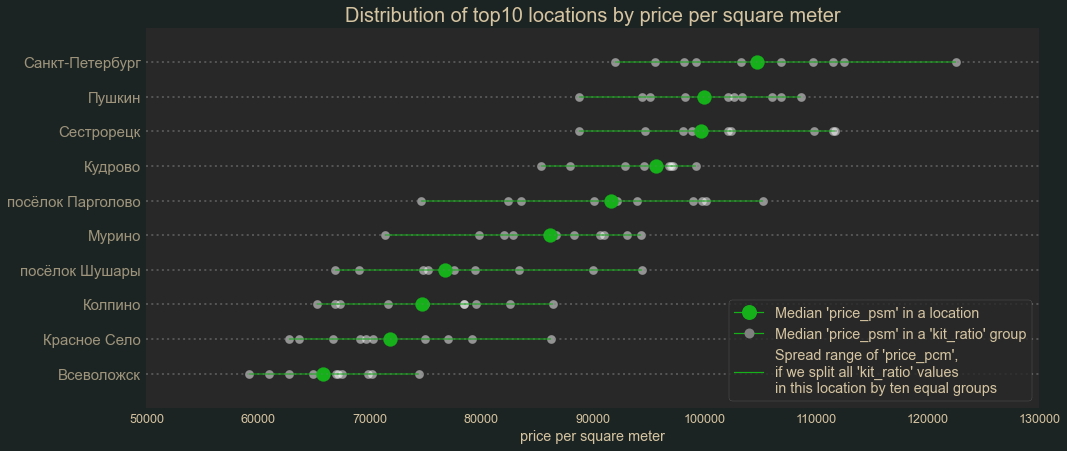

In [86]:
df['auto_locality_name'] = df['auto_locality_name'].astype('object')
    # category column is always grouped by all categories, it doesn't suit me here
top10_price_psm = df['auto_locality_name'].value_counts().head(10).index
top10_price_psm = (df[ df['auto_locality_name'].isin(top10_price_psm) ]
                                     .groupby('auto_locality_name')
                                     .agg({'price_psm': 'median'})
                                     .sort_values(by = 'price_psm', ascending = True).reset_index())

fig, ax = plt.subplots(figsize=(16,7))
ax.hlines(y = top10_price_psm.index, xmin = 50000, xmax = 130000, color = 'gray', 
          alpha = 0.5, linewidth = 2, linestyles = 'dotted')
ax.grid(b = False, axis = 'both')
ax.set_title('Distribution of top10 locations by price per square meter', fontsize = 20)
ax.set(xlim = (50000, 130000), ylim = (-1, 10), yticks = top10_price_psm.index, xlabel = 'price per square meter') 
ax.set_yticklabels(top10_price_psm['auto_locality_name'], fontdict = {'horizontalalignment': 'right'}, 
                   fontsize = 15, alpha = 0.7)
for sp in ['top', 'bottom', 'left', 'right']:
    ax.spines[sp].set_visible(False)
    
for i, name in enumerate(top10_price_psm['auto_locality_name']):
    loc_slice = df[ df['auto_locality_name'] == name ]
    median_for_kit_ratio_groups = (loc_slice[ loc_slice['kit_ratio'] > 0]
                         .groupby(pd.qcut(loc_slice.loc[ loc_slice['kit_ratio'] > 0, 'kit_ratio' ], 10))
                         .agg({'price_psm' : 'median'}))
    ax.hlines(y = i, xmin = median_for_kit_ratio_groups.min()[0], 
                     xmax = median_for_kit_ratio_groups.max()[0], 
                     color = '#15b01a', alpha = 0.5, linewidth = 2)
    ax.scatter(y = np.repeat(i, median_for_kit_ratio_groups.shape[0]), x = median_for_kit_ratio_groups, 
           s = 75, edgecolors = 'grey', c = 'w', alpha = 0.5)
    ax.scatter(y = i, x = top10_price_psm.loc[i, 'price_psm'], s = 200, c = '#15b01a', alpha = 1)
    
green_dot = ax.plot([], [], marker = 'o', ms = 15, c = '#15b01a', alpha = 1, label = "Median 'price_psm' in a location")
grey_dot = ax.plot([], [], marker = 'o', ms = 10, mfc = 'grey', c = '#15b01a', alpha = 1, label = "Median 'price_psm' in a 'kit_ratio' group")
green_line = ax.plot([], [], c = '#15b01a', alpha = 1, label = "Spread range of 'price_pcm',\nif we split all 'kit_ratio' values\nin this location by ten equal groups")

ax.legend(loc = 'lower right', fontsize = 'x-large')

display(fig)
plt.close(fig)

Смотрим на Санкт-Петербург ещё раз и убеждаемся, что в Санкт-Петербурге у каждой квантильной группы по 'kit_ratio' есть своя, отличающаяся от других медианная цена, то есть каждые дополнительные несколько процентов в пользу площади кухни относительно общей площади находят отражение в цене. В Санкт-Петербурге наиболее равномерное распределение серых точек. Но есть и другие населённые пункты, и там cерые точни лежат кучно - там либо территория застроена однообразными зданиями, в которых средние значения в десяти квантильных группах не сильно отличаются друг от друга, либо же 'kit_ratio' не имеет такого влияния на стоимость за квадратный метр. В конечном итоге, можно ориентироваться на разброс между минимальным и максимальным медианным значением. 

Этот разброс характеризует, насколько разнообразен рынок недвижимости. Если рынок разнообразен, но медианные цены для групп 'kit_ratio' кучные, как, например, в Парголово, значит, рынок в этой области сегментирован по какому-то другому принципу. Если же рынок однообразен (как в Кудрово), то кучность медиан для групп 'kit_ratio', как и смещение общей медианы в ту или иную сторону характеризуют саму застройку, а не рынок. Если общая медиана по всему населённому пункту, при наличии разнообразного рынка, смещена вниз, значит, в области преобладает недвижимость эконом-класса (например, в Шушарах).

<a id='target8'></a>

## Зависит ли цена от даты публкации

Здесь нужно исследовать, может ли продавец выставить низшую или большую цену на квартиру, чем можно было бы ожидать (а ожидать можем медианную) из-за времени года или дня недели.

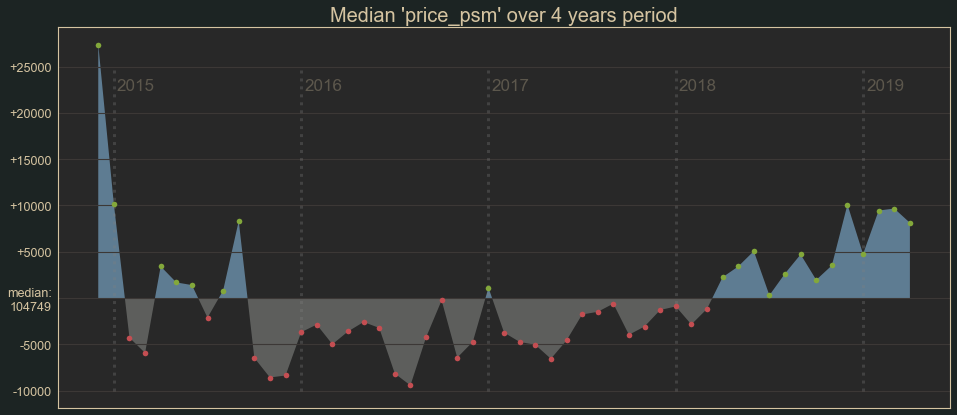

In [87]:
median_price_psm = spb_df['price_psm'].median()
psm_by_months = spb_df.groupby(['year', 'month']).agg({'price_psm' : 'median'}).iloc[1:-1]
ndarray_psm_by_months = np.array(psm_by_months['price_psm'].sub(median_price_psm), dtype = int)
psm_by_months = psm_by_months.reset_index()

fig, ax = plt.subplots(figsize=(16,7))
ax.grid(b = False, axis = 'x')
ax.set_title("Median 'price_psm' over 4 years period", fontsize = 20)
ax.tick_params(labelbottom = False)
ax.plot(psm_by_months[ psm_by_months['price_psm'].sub(median_price_psm) >= 0 ].index, 
        ndarray_psm_by_months[ndarray_psm_by_months >= 0], 'go')
ax.plot(psm_by_months[ psm_by_months['price_psm'].sub(median_price_psm) <= 0 ].index, 
        ndarray_psm_by_months[ndarray_psm_by_months <= 0], 'ro')
ax.fill_between(psm_by_months.index, ndarray_psm_by_months, 0, where = (ndarray_psm_by_months >= 0),
                facecolor = '#95d0fc', interpolate = True, alpha = 0.5)
ax.fill_between(psm_by_months.index, ndarray_psm_by_months, 0, where = (ndarray_psm_by_months <= 0),
                facecolor = '#929591', interpolate = True, alpha = 0.5)

def ytick_labels(ytick_list):
    labels_list = []
    for x in ytick_list:
        if x < 0:
            labels_list.append(str(x))
        elif x == 0:
            labels_list.append('median:\n' + str(int(median_price_psm)))
        elif x > 0:
            labels_list.append('+' + str(x))
    return labels_list
ax.set_yticks([i for i in range(-10000, 26000, 5000)])
ax.set_yticklabels(ytick_labels([i for i in range(-10000, 26000, 5000)]))

for year in [2015, 2016, 2017, 2018, 2019]:
    x_tick = psm_by_months[ psm_by_months['year'] == year ].iloc[0].name
    ax.vlines(x = x_tick, ymin = -10000, ymax = 25000, color = 'grey', 
              alpha = 0.3, linewidth = 3, linestyles = 'dotted')
    ax.text(x_tick + 0.2, 23000, year, horizontalalignment = 'left', 
            verticalalignment = 'center', fontsize = 17, alpha = 0.3)
    
display(fig)
plt.close(fig)

Диаграмма не показала никаких закономерностей, связывающих год и месяц с ценой на недвижимость. Увидели лишь то, что год на рынке недвижимости может проходить по-разному. Если искать сезонность, то, вероятно, в данных за больший промежуток времени, чем четыре года.

Использую написанный код для того, чтобы вывести похожие диаграммы для месяцев и дней недели.

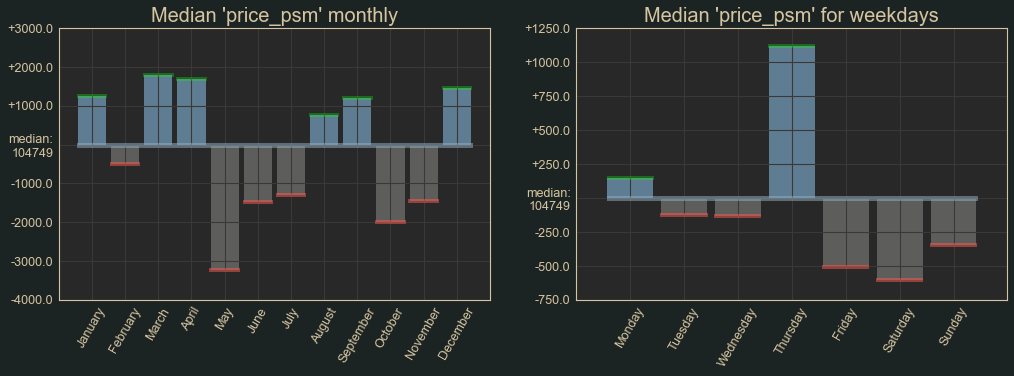

In [88]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (17, 5))

for key, ax in zip(['month', 'weekday'], [ax1, ax2]):
    psm_key = spb_df.groupby(key).agg({'price_psm' : 'median'})
    ndarray_psm_key = np.array(psm_key['price_psm'].sub(median_price_psm), dtype = int)
    
    ax.set_xlim(-1, len(ndarray_psm_key))
    ax.set_xticks([i for i in range(len(ndarray_psm_key))])
    ax.add_line(mlines.Line2D([-0.4, len(ndarray_psm_key) -0.6], [0, 0], 
                              color = '#94B3C7', alpha = 0.5, linewidth = 5))
    if key == 'month':
        ax.set_title("Median 'price_psm' monthly", fontsize = 20)
        ax.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 
                             'July', 'August', 'September', 'October', 'November', 'December'], rotation = 60)
    elif key == 'weekday':
        ax.set_title("Median 'price_psm' for weekdays", fontsize = 20)
        ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 
                             'Saturday', 'Sunday'], rotation = 60)
        
    for i, val in enumerate(ndarray_psm_key):
        if val > 0:
            ax.bar(i, val, color = '#95d0fc', alpha = 0.5, width = 0.85)
            ax.add_line(mlines.Line2D([i -0.4, i +0.4], [val, val], color = '#0cff0c', linewidth = 4, alpha = 0.3))
        else:
            ax.bar(i, val, color = '#929591', alpha = 0.5, width = 0.85)
            ax.add_line(mlines.Line2D([i -0.4, i +0.4], [val, val], color = '#fc5a50', linewidth = 4, alpha = 0.5))
    
    ax.set_yticks(ax.get_yticks()) 
    ax.set_yticklabels(ytick_labels(ax.get_yticks()))
    
display(fig)
plt.close(fig)

Положение вещей, отображённое на графиках, не должно привести к мысли, будто бы квартиры стоят меньше по субботам, а чтобы опубликовать своё объявление, стоит дождаться первого четверга марта. Графики описывают поведение, типичное для продавцов на данной торговой площадке.
<a id='target9'></a>

## Тенденции на рынке недвижимости в центре, в окраинах и в пригородах 

Пришло время выделить объявления, относящиеся к центру города. Где, с точки зрения рынка, кончается центр? Чтобы ответить, разделим с помощью `cut( )` все объявления на расстоянии до центра ближе 16км на такие группы, чтобы объявления из одной корзины охватывали примерно 700-900 метров расстояния, и посчитаем мединную цену для каждой корзины. Будем искать наибольшее падение цены в промежутке 700-900 метров между двумя корзинами.

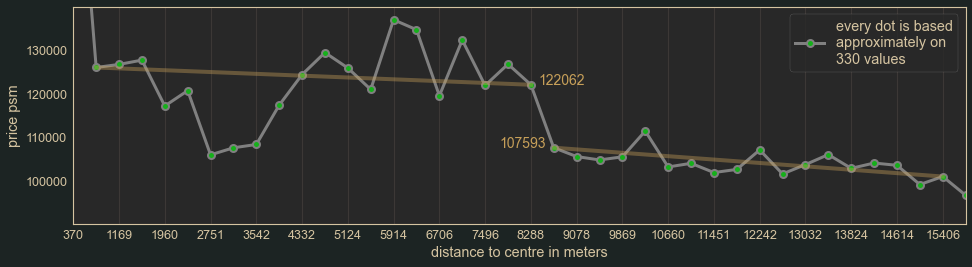

In [89]:
cut_400_meters = (spb_df[ (spb_df['auto_dist_to_centre'] < 16000) & (spb_df['auto_dist_to_centre'] != -909090)]
     .groupby(pd.cut(spb_df.loc[ ((spb_df['auto_dist_to_centre'] < 16000) & (spb_df['auto_dist_to_centre'] != -909090)), 
                                'auto_dist_to_centre' ], 
                     40)).agg({'price_psm': ['median', 'count']})).reset_index()

def rounding_intervals(interval):
    interval = str(interval)
    left, right = interval.split()
    left_integer, left_decimals = left.split('.')
    left_integer = int(left_integer[1:])
    right_integer, right_decimals = right.split('.')
    right_integer = int(right_integer)
    return int(round((left_integer + right_integer) / 2, 0))
cut_400_meters['auto_dist_to_centre'] = cut_400_meters['auto_dist_to_centre'].apply(rounding_intervals)

fig, ax = plt.subplots(figsize = (16, 4))
ax.grid(b = False, axis = 'y')
ax.set(xlim = (cut_400_meters['auto_dist_to_centre'].iloc[0], 
               cut_400_meters['auto_dist_to_centre'].iloc[-1]), 
       ylim = (90000, 140000))
ax.plot(cut_400_meters['auto_dist_to_centre'], cut_400_meters[('price_psm', 'median')], '-o', linewidth = 3, ms = 7, 
        mfc = '#15b01a', c = 'grey', mec = 'grey', mew = 2,
        label = (f"every dot is based\napproximately on\n{int(cut_400_meters[('price_psm', 'count')].sum() / cut_400_meters.shape[0])} values"))

ax.legend(loc = 'upper right', fontsize = 'x-large')
ax.set(xticks = [i for i in cut_400_meters['auto_dist_to_centre'][::2]], yticks = ax.get_yticks()[1:-1], 
      xlabel = 'distance to centre in meters', ylabel = 'price psm')
ax.add_line(mlines.Line2D([774, 8288], [126037, 122062], linewidth = 4, c = '#c69f59', alpha = 0.4))
ax.text(x = 8288 + 130, y = 122062, s = '122062', fontsize = 14, c = '#c69f59', horizontalalignment = 'left')
ax.add_line(mlines.Line2D([8682, 15406], [107593, 100962], linewidth = 4, c = '#c69f59', alpha = 0.4))
ax.text(x = 8682 - 130, y = 107593, s = '107593', fontsize = 14, c = '#c69f59', horizontalalignment = 'right')

display(fig)
plt.close(fig)

Несмотря на то, что в центре города цены достаточно волатильные, граница между центром и окраиной прослеживается ясно. Стоит объекту недвижимости пересечь отметку в 8500 метров до центра, как его рыночная возрастает на 15.000 за квадратный метр.

In [90]:
centre_df = spb_df[ (spb_df['auto_dist_to_centre'] > 0) & (spb_df['auto_dist_to_centre'] < 8500 ) ]
spb_df = spb_df[ (spb_df['auto_dist_to_centre'] > 0) & (spb_df['auto_dist_to_centre'] >= 8500 ) ]

Мы располагаем тремя срезами данных, относящихся к разным областям города: `centre_df`, `spb_df` и `out_df`. Нужно проверить предположение, что данные в них отличаются и имеют свои особенности. Чтобы проверить это, измерим влияние количественных переменных нашего датафрейма на ценообразование в каждой из областей города.

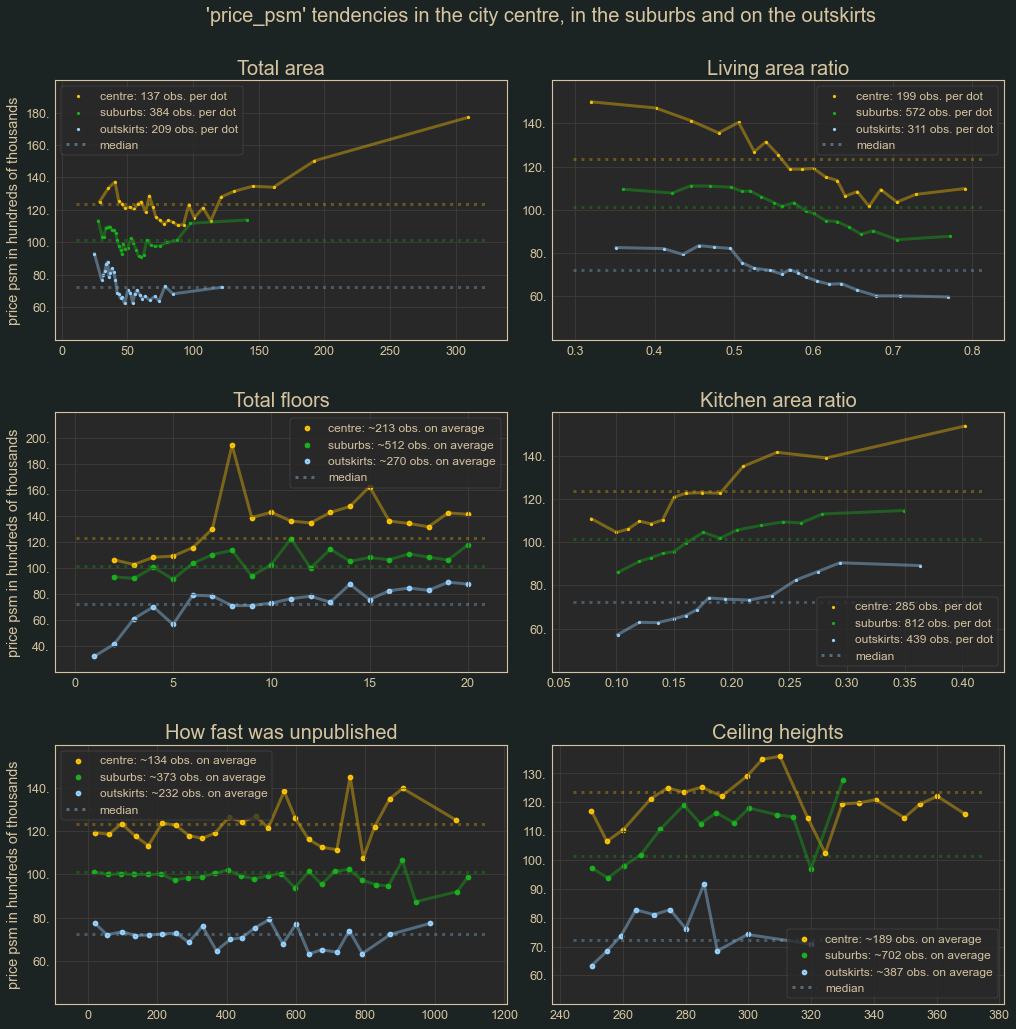

In [91]:
dic = { 'total_area': ['Total area', 30, [False]],     
        'liv_ratio': ['Living area ratio', 20, [False]],
        'floors_total': ['Total floors', 20, [True, 0, 20]],
        'kit_ratio': ['Kitchen area ratio', 14, [False]],
        'auto_days_posted': ['How fast was unpublished', 30, [True, 0, 1160]],
        'ceiling_height': ['Ceiling heights', 20, [True, 240, 370]]  }

fig, ax = plt.subplots(3, 2, figsize = (17, 17))
[*ax] = ax.flatten()
fig.subplots_adjust(hspace = 0.28, wspace = 0.1)
fig.suptitle("'price_psm' tendencies in the city centre, in the suburbs and on the outskirts", 
             fontsize = 20, y = 0.94, x = 0.522)
y_median_list = [centre_df['price_psm'].median(), spb_df['price_psm'].median(), out_df['price_psm'].median()]
counter = 0

for (key, value), ax in zip(dic.items(), ax):
    ax.set_title(value[0], fontsize = 20)
    
    for sliced, col, lab in zip([centre_df, spb_df, out_df], 
                             ['#fac205', '#15b01a', '#95d0fc'], 
                             ['centre: ', 'suburbs: ', 'outskirts: ']):
        if value[2][0] == True:
            temp_df = sliced.loc[ ((sliced[key] > value[2][1]) & (sliced[key] <= value[2][2])) ].copy()
            temp_df.loc[:, key + f'_cats_{value[1]}'] = (pd.cut(temp_df[key], value[1]))
            grouped_by_key = (temp_df.groupby(key + f'_cats_{value[1]}')
                          .agg({key: ['mean', 'count'], 'price_psm': 'median'}))
            grouped_by_key = grouped_by_key[ grouped_by_key[(key, 'count')] > 15 ]
                # if `cut( )` was completed, many calculations may be based on a small number of observations. 
                # if the number is lower than 15, i don't want to see them on a plot
            ax.plot(grouped_by_key[(key, 'mean')], grouped_by_key['price_psm'], color = col, alpha = 0.4, 
                linewidth = 3)
            lab = lab + f"~{int(grouped_by_key[(key, 'count')].mean())} " + "obs. on average"
            ax.scatter(grouped_by_key[(key, 'mean')], grouped_by_key['price_psm'], s = 5, linewidths = 3.5, 
                   c = 'grey', edgecolors = col, label = lab)
            
        else:
            temp_df = sliced.loc[ (sliced[key] > 0) ].copy()
            temp_df.loc[:, key + f'_cats_{value[1]}' ] = (pd.qcut(temp_df[key], value[1]))
            grouped_by_key = (temp_df.groupby(key + f'_cats_{value[1]}')
                              .agg({key: ['mean', 'count'], 'price_psm': 'median'}))
            ax.plot(grouped_by_key[(key, 'mean')], grouped_by_key['price_psm'], color = col, alpha = 0.4, 
                linewidth = 3)
            lab = lab + f"{int(grouped_by_key[(key, 'count')].mean())} " + 'obs. per dot'
            ax.scatter(grouped_by_key[(key, 'mean')], grouped_by_key['price_psm'], s = 3, linewidths = 1.5, 
                   c = 'grey', edgecolors = col, label = lab)
    
    xlim = ax.get_xlim()
    yticks = ax.get_yticks()
    for y, col in zip(y_median_list, ['#fac205', '#15b01a', '#95d0fc']):
        ax.hlines(y = y, xmin = xlim[0], xmax = xlim[1], 
                  color = col, linestyle = 'dotted', alpha = 0.3, linewidth = 3)
    ax.hlines([], [], [], color = col, linestyle = 'dotted', alpha = 0.4, linewidth = 3, label = 'median')
    ax.set(ylim = (yticks.min(), yticks.max()), yticks = yticks[1:-1],
           yticklabels = pd.Series((yticks[1:-1] // 1000).astype('int')).apply(lambda x: str(x)).add('.'), 
           ylabel = ['price psm in hundreds of thousands' if counter in [0, 2, 4] else ''][0])
    counter += 1
    ax.legend(fontsize = 'large')

display(fig)
plt.close(fig)

О графиках (по порядку):
1. В первую очередь обращает на себя внимание, что выбросы в центре сильно "заметнее" во всех отношениях, чем выбросы в окраинах и пригородах. Среднее значение 'total_area' для крайней квантильной группы в центре города - целых 310м$^2$, в два раза больше, чем среднее в крайней квантильной группе для городских окраин, несмотря на то, что в окраинах города цена м$^2$ для застройщика однозначно ниже, и свободной земли для реализации проектов больше. С другой стороны, платформа может не принимать объявления от застройщиков и сосредотачиваться на "вторичном" рынке - такие детали неизвестны. Возвращаясь к центру города, каждый дополнительный метр площади в центре оценивается выше, чем в других областях - цена за квадратный метр в центре вырастает на сумму до 60 тысяч за квадратный метр относительно медианы. В то же время, скажем, в пригородах дополнительные метры площади никакой "добавочной" стоимостью не облагаются, и цена за квадратный метр остаётся более-менее на уровне медианной даже при большой общей площади квартиры. В окраинах и пригородах ты заплатишь за один квадратный метр больше, если, напротив, покупаешь слишком маленькую по площади квартиру.


2. Не может быть, чтобы жилая площадь была маленькой, в то время как кухня большая. Архитекторы в первую очередь увеличили бы жилую площадь, прежде чем увеличивать площадь кухни. Так что когда отношение кухни к общей площади растёт (и, соответственно, в это же время отношение жилой площади к общей падает), это значит, что жилая площадь уже достаточно велика. Поэтому рост 'kit_ratio' так однозначно ассоциируется на рынке с недвижимостью премиум класса.


3. По неясной для меня причине восьмиэтажные здания особенно высоко ценятся в центре города, а одиннадцатиэтажные - в окраинах. В окраинах города всё просто - чем больше этажей, тем, в конечном итоге, выше может быть стоимость квадратного метра, однако рост будет незначительным. В центре многоэтажность здания является стабильным фактором, увеличивающим стоимость квадратного метра относительно медианы. А для квартир в пригороде важно, чтобы этажей было не меньше пяти: в пригородах малоэтажность - фактор, из-за которого стоимость квадратного метра может быть оценена в сторону уменьшения. 
  
  
4. Большие кухни высоко оцениваются. Высокое значение 'kit_ratio' может поднять цену за квадратный метр на 20 тысяч в окраинах и пригородах и до 30 тысяч в центре. Примечательно, что вес 'kit_ratio' в пригородах ниже, чем в черте города (уже наблюдали это, теперь видим ещё раз) - график для пригорода дважды выходит на плато, в том числе на "финальном" отрезке.
  
  
5. Стоимость квадратного метра не сказывается на том, как быстро будет продана квартиры (а мы исходим из того, что объявления сняты с публикации именно из-за продажи). С другой стороны, тому кто захочет выяснить, что влияет на скорость продажи, стоит обратить внимание на стоимость квартир в абсолютном значении, а не за квадратный метр. А на том графике, который есть, все три кривые колеблются вокруг медианы сколько бы времени с момента публикации не прошло. Глубже по оси х волатильноть увеличивается, особенно сильно - для центра города. Скорее всего, это связано только лишь с нехваткой значений в крайних группах.


6. Высота потолков наиболее ценится в городских окраинах. Там, если высота потолков превышает 270 сантиметров, то платить за квадратный метр вы будете почти столько же, как если бы покупали квартиру в центре. В центре и в пригородах ценится средняя высота потолков. Если больше, равно как если немного меньше среднего - нейтральный фактор. Почему высота больше средней не является фактором, увелииваюащим цену квадратного метра? Я думаю, что это не совсем так. Скрее всего, в той точке, где высота потолков наиболее увеличивает стоимость квадратного метра, заканчивается предложение малых по площади квартир с большими потолками, и дальше площадь квартир только увеличивается, нивелируя возросшую ранее стоимость квадратного метра. То есть, если для центра города пик установился на отметке в 3.1 метра, то вам придётся приложить немало усилий, чтобы найти однокомнатную или двухкомнатную квартиру в центре с потолками 3.2 метра. Зато такие квартиры с потолками 3.1 метр вы будете находить часто, хотя, скорее всего, их стоимость за квадратный метр будет очень высокой.
<a id='target10'></a>

# Резюме

Было сделано:
  
1. сократили использование памяти датафреймом
2. переименовали и сгруппировали столбцы
3. написали функцию, анализирующую пропуски
4. написали функцию,находящую столбцы с дублированными пропусками
5. нашли группу автоматически заполненных столбцов с дублированными пропусками
6. написали функцию, которая визализирует, как строчки с пропусками из одного столбца ведут себя в других столбцах
7. нашли вероятную причину дублированных пропусков
8. проанализировали оставшиеся пропущенные значения в столбцах, содержащих расстояние до какого-то объекта
9. поставили под вопрос качество данных в столбце 'is_apartment'
10. изучили оставшиеся пропуски и предложили как с ними поступить
11. сочинили четыре функции для предсказания пропущенных значений
12. вручную заполнили часть пропущенных значений
13. заполнили оставшиеся пропуски согласно плану
14. внесли исправления в столбцы формата float
15. нашли неявные дубли в столбце 'auto_locality_name' и избавились от них
16. написали функцию, которая анализирует числовые выбросы и воспользовались ей
17. избавились от аномальных выбросов и от объявлений, пришедших из другого региона
18. рассчитали необходимые для анализа метрики 
19. написали и запустили функцию, которая очищает глобальное пространство имён от не нужных более переменных
20. визуализировали зависимость цены от значений некоторых категориальных переменных
21. визуализировали цену за квадратный метр для топ-10 населённых пунктов и для десяти 'kit_ratio' категорий в каждом
22. визуализировали зависимость между ценой и датой публикации
23. нашли рыночную границу между центром города и окраиной
24. визуализировали зависимость цены за квадратный метр от количественных переменных отдельно для центра города, для окраины и для ближайших пригородов.

[To the beginning](#target100)